### Project Title:
- **Understanding the Impact of Data Poisoning on Financial Fraud Detection: Thresholds and Feature Sensitivity**

This research investigates the vulnerability of AI-based financial fraud detection models to data poisoning attacks, aiming to identify (1) the poisoning threshold at which models fail, (2) feature-level sensitivities exploited by attackers, and (3) lightweight strategies for detecting and mitigating poisoned data.

# 2 Data Poisoning Attack Implementation

#### Define Pollution Ratio Settings

In this experiment, we evaluate the impact of data poisoning under various contamination levels. The following pollution ratios are considered:

- 5% (mild contamination)
- 10%
- 20%
- 30%
- 50% (heavy contamination)

For each ratio, we will apply two types of attacks:
- Label Flipping Attack
- Feature Manipulation Attack

We will observe the performance degradation of the baseline models under these poisoned conditions.

# 2.0 Label Flipping Attack

In [878]:
import pandas as pd
import numpy as np

def label_flipping_attack(df, label_col='Class', flip_ratio=0.05, random_state=42):
    """
    Flip the labels of a given percentage of samples in the dataset.

    Parameters:
        df (pd.DataFrame): The original training DataFrame.
        label_col (str): The name of the label column.
        flip_ratio (float): The proportion of samples to flip (e.g., 0.05 for 5%).
        random_state (int): Random seed for reproducibility.

    Returns:
        pd.DataFrame: A new DataFrame with flipped labels.
    """
    df_attacked = df.copy()
    np.random.seed(random_state)

    # Number of samples to flip
    n_total = len(df_attacked)
    n_flip = int(flip_ratio * n_total)

    # Randomly select sample indices to flip
    indices_to_flip = np.random.choice(df_attacked.index, size=n_flip, replace=False)

    # Flip labels: 0 becomes 1, 1 becomes 0
    df_attacked.loc[indices_to_flip, label_col] = 1 - df_attacked.loc[indices_to_flip, label_col]

    return df_attacked

## 2.1 5% Pollution

In [880]:
# Load clean train and test sets
train_df = pd.read_csv('data/clean/train.csv')
test_df = pd.read_csv('data/clean/test.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

# Generate 5% label flipping poisoned training data
polluted_5 = label_flipping_attack(train_df, flip_ratio=0.05)

# Save the polluted dataset
os.makedirs('data/polluted', exist_ok=True)
polluted_5.to_csv('data/polluted/label_flipping_0.05.csv', index=False)

print("5% label flipping data generated and saved successfully.")

Train shape: (227845, 31)
Test shape: (56962, 31)
5% label flipping data generated and saved successfully.


### 2.1.1 Logistic Regression

In [882]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import csv

# Load polluted training data and clean test data
polluted_train_df = pd.read_csv('data/polluted/label_flipping_0.05.csv')
clean_test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = polluted_train_df.drop(columns=['Class'])
y_train = polluted_train_df['Class']
X_test = clean_test_df.drop(columns=['Class'])
y_test = clean_test_df['Class']

# Train Logistic Regression model
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

Classification Report - Logistic Regression (5% Label Flipping)
              precision    recall  f1-score   support

           0     0.9997    0.9618    0.9804     56864
           1     0.0363    0.8367    0.0697        98

    accuracy                         0.9616     56962
   macro avg     0.5180    0.8993    0.5250     56962
weighted avg     0.9981    0.9616    0.9788     56962



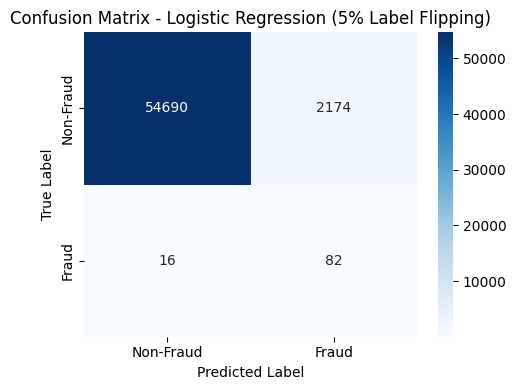

In [1021]:
# Print classification report and confusion matrix
print("Classification Report - Logistic Regression (5% Label Flipping)")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression (5% Label Flipping)")
plt.tight_layout()
plt.show()

In [886]:
def log_result(result_dict, filename='results/label_flipping_results.csv'):
    import os, csv

    os.makedirs(os.path.dirname(filename), exist_ok=True)

    fieldnames = ['Attack Type', 'Polluted Ratio', 'Model', 'AUC', 'F1', 'Precision', 'Recall']
    new_row = [str(result_dict[k]) for k in fieldnames]

    # Check if row already exists
    if os.path.exists(filename):
        with open(filename, mode='r') as file:
            existing_rows = list(csv.reader(file))
            if new_row in existing_rows:
                print("This result already exists in the log. Skipping.")
                return

    # Write new row
    with open(filename, mode='a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        if file.tell() == 0:
            writer.writeheader()
        writer.writerow(result_dict)

In [890]:
from sklearn.metrics import f1_score, precision_score, recall_score

log_result({
    'Attack Type': 'Label Flipping',
    'Polluted Ratio': 0.05,
    'Model': 'Logistic Regression',
    'AUC': auc_score,
    'F1': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
})

### 2.1.2 Random Forest

In [894]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score
import os
import csv

# Load polluted training data and clean test data
polluted_train_df = pd.read_csv('data/polluted/label_flipping_0.05.csv')
clean_test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = polluted_train_df.drop(columns=['Class'])
y_train = polluted_train_df['Class']
X_test = clean_test_df.drop(columns=['Class'])
y_test = clean_test_df['Class']

# Train Random Forest model
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

Classification Report - Random Forest (5% Label Flipping)
              precision    recall  f1-score   support

           0     0.9997    0.9618    0.9804     56864
           1     0.0363    0.8367    0.0697        98

    accuracy                         0.9616     56962
   macro avg     0.5180    0.8993    0.5250     56962
weighted avg     0.9981    0.9616    0.9788     56962



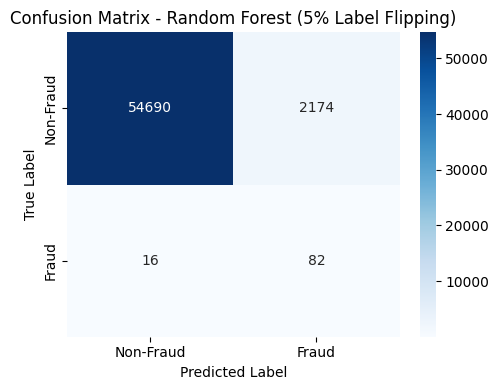

In [1019]:
# Print classification report and confusion matrix
print("Classification Report - Random Forest (5% Label Flipping)")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest (5% Label Flipping)")
plt.tight_layout()
plt.show()

In [898]:
from sklearn.metrics import f1_score, precision_score, recall_score

log_result({
    'Attack Type': 'Label Flipping',
    'Polluted Ratio': 0.05,
    'Model': 'Random Forest',
    'AUC': auc_score,
    'F1': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
})

### 2.1.3 XGBoost

In [900]:
# Load polluted training data and clean test data
polluted_train_df = pd.read_csv('data/polluted/label_flipping_0.05.csv')
clean_test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = polluted_train_df.drop(columns=['Class'])
y_train = polluted_train_df['Class']
X_test = clean_test_df.drop(columns=['Class'])
y_test = clean_test_df['Class']

# Train XGBoost model
from xgboost import XGBClassifier

model = XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
                      use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:25:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report - XGBoost (5% Label Flipping)
              precision    recall  f1-score   support

           0     0.9997    0.9618    0.9804     56864
           1     0.0363    0.8367    0.0697        98

    accuracy                         0.9616     56962
   macro avg     0.5180    0.8993    0.5250     56962
weighted avg     0.9981    0.9616    0.9788     56962



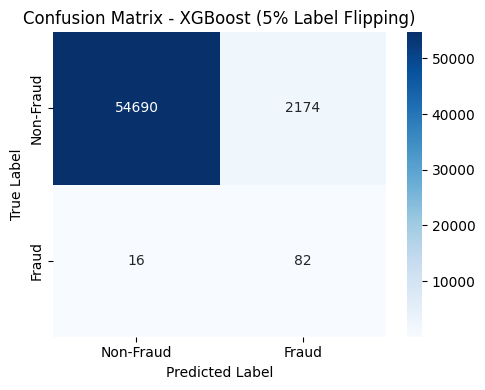

In [1017]:
# Print classification report and confusion matrix
print("Classification Report - XGBoost (5% Label Flipping)")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - XGBoost (5% Label Flipping)")
plt.tight_layout()
plt.show()

In [904]:
# Log evaluation results
auc_score = roc_auc_score(y_test, y_prob)

log_result({
    'Attack Type': 'Label Flipping',
    'Polluted Ratio': 0.05,
    'Model': 'XGBoost',
    'AUC': auc_score,
    'F1': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
})

### 2.1.4  Isolation Forest

In [906]:
# Load polluted training data and clean test data
polluted_train_df = pd.read_csv('data/polluted/label_flipping_0.05.csv')
clean_test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = polluted_train_df.drop(columns=['Class'])
y_train = polluted_train_df['Class']
X_test = clean_test_df.drop(columns=['Class'])
y_test = clean_test_df['Class']

# Train Isolation Forest model
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination='auto', random_state=42)
model.fit(X_train)

# Predict
y_pred_if = model.predict(X_test)

# Convert predictions: -1 → anomaly (fraud), 1 → normal
y_pred = (y_pred_if == -1).astype(int)

# Generate decision function scores for AUC calculation
# (Note: AUC for Isolation Forest is approximated based on decision scores, not true probability outputs.)
y_scores = -model.decision_function(X_test)

Classification Report - Isolation Forest (5% Label Flipping)
              precision    recall  f1-score   support

           0     0.9997    0.9618    0.9804     56864
           1     0.0363    0.8367    0.0697        98

    accuracy                         0.9616     56962
   macro avg     0.5180    0.8993    0.5250     56962
weighted avg     0.9981    0.9616    0.9788     56962



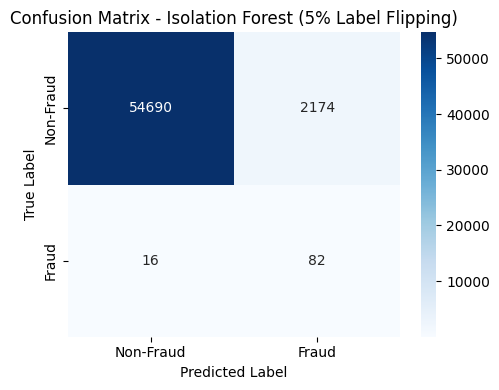

In [1015]:
# Print classification report and confusion matrix
print("Classification Report - Isolation Forest (5% Label Flipping)")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Isolation Forest (5% Label Flipping)")
plt.tight_layout()
plt.show()

In [910]:
# Log evaluation results
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

auc_score = roc_auc_score(y_test, y_scores)

log_result({
    'Attack Type': 'Label Flipping',
    'Polluted Ratio': 0.05,
    'Model': 'Isolation Forest',
    'AUC': auc_score,
    'F1': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
})

### 2.1.5 Comparison to Baseline Model (5% Pollution)

#### Baseline model - 0% Pollution

In [912]:
import pandas as pd
df_results = pd.read_csv('results/baseline_results.csv')
df_results

Attack Type  Polluted Ratio                Model       AUC        F1  \
0       Clean             0.0  Logistic Regression  0.971162  0.112853   
1       Clean             0.0        Random Forest  0.953000  0.839080   
2       Clean             0.0              XGBoost  0.975516  0.656250   
3       Clean             0.0     Isolation Forest  0.956256  0.304569   

   Precision    Recall  
0   0.060120  0.918367  
1   0.960526  0.744898  
2   0.531646  0.857143  
3   0.303030  0.306122

#### Label Flipping Attack - 5% Pollution

In [914]:
import pandas as pd
df_results = pd.read_csv('results/label_flipping_results.csv')
df_results

Attack Type  Polluted Ratio                Model       AUC        F1  \
0  Label Flipping            0.05  Logistic Regression  0.901107  0.013646   
1  Label Flipping            0.05        Random Forest  0.901107  0.478964   
2  Label Flipping            0.05              XGBoost  0.885716  0.011117   
3  Label Flipping            0.05     Isolation Forest  0.956256  0.069669   

   Precision    Recall  
0   0.006871  0.969388  
1   0.350711  0.755102  
2   0.005595  0.846939  
3   0.036348  0.836735

At 5% label flipping, all models exhibited noticeable performance degradation, with varying degrees of robustness to label noise:

- **Logistic Regression:** AUC dropped by 7.00% (0.9712 ➔ 0.9011), and F1 score decreased by 0.0992 (0.1129 ➔ 0.0136). This shows extreme sensitivity to even small amounts of label corruption, becoming almost ineffective for fraud detection.

- **Random Forest:** AUC dropped by 5.45% (0.9530 ➔ 0.9011), and F1 score decreased significantly by 0.3601 (0.8391 ➔ 0.4790). Although tree-based ensembles resist complete collapse in AUC, their ability to balance precision and recall weakens under label noise.
- **XGBoost:** AUC dropped by 9.20% (0.9755 ➔ 0.8857), and F1 score nearly collapsed, decreasing by 0.6452 (0.6563 ➔ 0.0111). Boosting methods appear highly vulnerable to label flipping attacks even at low pollution levels.

- **Isolation Forest:** AUC remained virtually unchanged (0.9563 ➔ 0.9563), but F1 score decreased by 0.2349 (0.3046 ➔ 0.0697). As an unsupervised model, it maintains structural stability but suffers in precision-recall tradeoff under noisy conditions.
*Note: AUC for Isolation Forest is approximated based on decision scores rather than true probabilities; interpretation should be cautious.*

**Overall:** At 5% label flipping, ensemble models like Random Forest show moderate AUC resilience but substantial F1 loss, while Isolation Forest remains structurally robust. Linear models and boosting models (Logistic Regression and XGBoost) are the most fragile even under low levels of label noise.

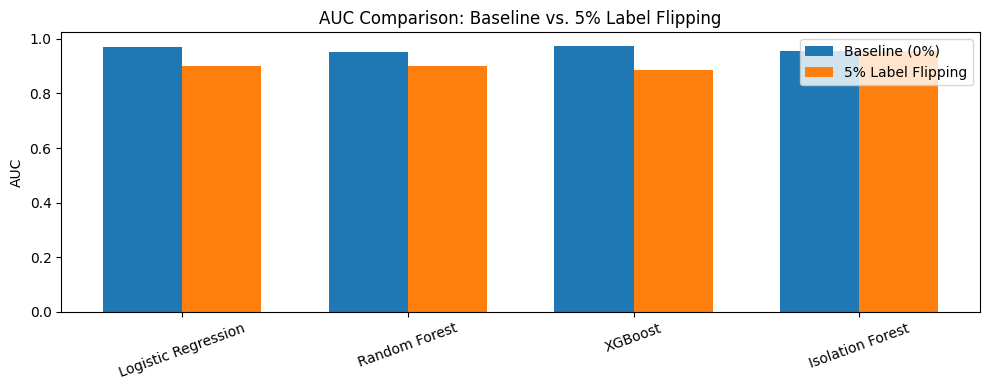

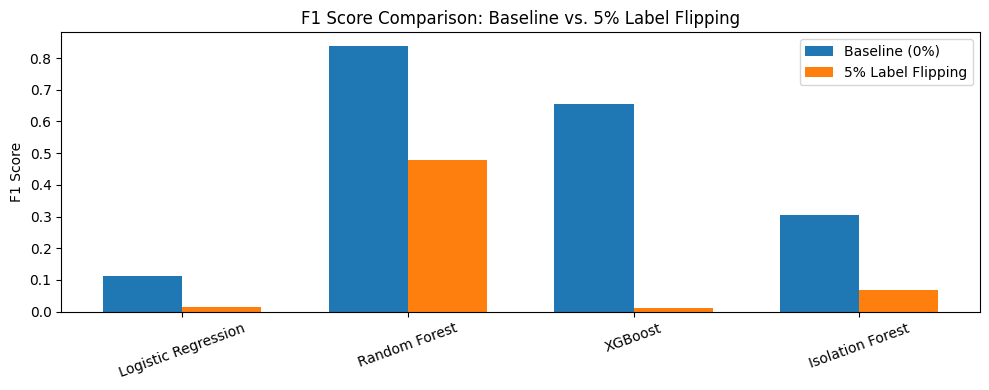

In [926]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load baseline and 5% label flipping results
df_base = pd.read_csv('results/baseline_results.csv')
df_5 = pd.read_csv('results/label_flipping_results.csv')
df_5 = df_5[df_5['Polluted Ratio'] == 0.05]

# Models to compare (order consistent)
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Isolation Forest']

# Extract AUC values
# Note: Isolation Forest AUC is approximated based on decision_function
auc_base = [df_base[df_base['Model'] == m]['AUC'].values[0] for m in models]
auc_5 = [df_5[df_5['Model'] == m]['AUC'].values[0] for m in models]

# Extract F1 values
f1_base = [df_base[df_base['Model'] == m]['F1'].values[0] for m in models]
f1_5 = [df_5[df_5['Model'] == m]['F1'].values[0] for m in models]

# Bar plot position
x = np.arange(len(models))
width = 0.35

# Plot AUC Comparison
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, auc_base, width, label='Baseline (0%)')
plt.bar(x + width/2, auc_5, width, label='5% Label Flipping')
plt.xticks(x, models, rotation=20)
plt.ylabel('AUC')
plt.title('AUC Comparison: Baseline vs. 5% Label Flipping')
plt.legend()
plt.tight_layout()
plt.show()

# Plot F1 Score Comparison
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, f1_base, width, label='Baseline (0%)')
plt.bar(x + width/2, f1_5, width, label='5% Label Flipping')
plt.xticks(x, models, rotation=20)
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison: Baseline vs. 5% Label Flipping')
plt.legend()
plt.tight_layout()
plt.show()

## 2.2 10% Pollution

In [928]:
import pandas as pd
import numpy as np
import os

# Reload clean training data
train_df = pd.read_csv('data/clean/train.csv')

# Define label flipping function (make sure every section can run independtly)
def label_flipping_attack(df, label_col='Class', flip_ratio=0.10, random_state=42):
    df_attacked = df.copy()
    np.random.seed(random_state)
    n_total = len(df_attacked)
    n_flip = int(flip_ratio * n_total)
    indices_to_flip = np.random.choice(df_attacked.index, size=n_flip, replace=False)
    df_attacked.loc[indices_to_flip, label_col] = 1 - df_attacked.loc[indices_to_flip, label_col]
    return df_attacked

# Generate 10% poisoned training data
polluted_10 = label_flipping_attack(train_df, flip_ratio=0.10)

# Save the 10% polluted data
os.makedirs('data/polluted', exist_ok=True)
polluted_10.to_csv('data/polluted/label_flipping_0.10.csv', index=False)

print("10% label flipping polluted training data saved.")

10% label flipping polluted training data saved.


### 2.2.1 Logistic Regression

In [930]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Load polluted training data and clean test data
polluted_train_df = pd.read_csv('data/polluted/label_flipping_0.10.csv')
clean_test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = polluted_train_df.drop(columns=['Class'])
y_train = polluted_train_df['Class']
X_test = clean_test_df.drop(columns=['Class'])
y_test = clean_test_df['Class']

# Create pipeline and train model
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

Classification Report – Logistic Regression (10%)
              precision    recall  f1-score   support

           0     0.9997    0.9618    0.9804     56864
           1     0.0363    0.8367    0.0697        98

    accuracy                         0.9616     56962
   macro avg     0.5180    0.8993    0.5250     56962
weighted avg     0.9981    0.9616    0.9788     56962



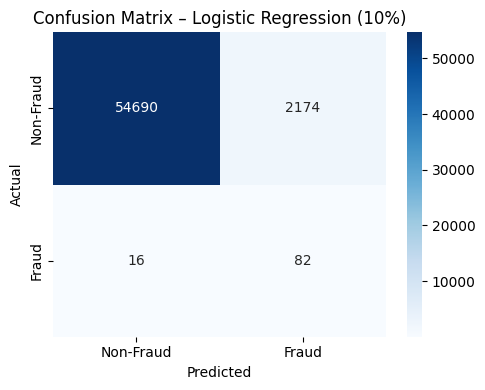

In [1013]:
# Import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate AUC
auc_score = roc_auc_score(y_test, y_prob)

# Print classification report
print("Classification Report – Logistic Regression (10%)")
print(classification_report(y_test, y_pred, digits=4))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistic Regression (10%)")
plt.tight_layout()
plt.show()

In [934]:
log_result({
    'Attack Type': 'Label Flipping',
    'Polluted Ratio': 0.10,
    'Model': 'Logistic Regression',
    'AUC': auc_score,
    'F1': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
})

### 2.2.2 Random Forest

In [938]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Load polluted training data and clean test data
polluted_train_df = pd.read_csv('data/polluted/label_flipping_0.10.csv')
clean_test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = polluted_train_df.drop(columns=['Class'])
y_train = polluted_train_df['Class']
X_test = clean_test_df.drop(columns=['Class'])
y_test = clean_test_df['Class']

# Train Random Forest model
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

Classification Report – Random Forest (10%)
              precision    recall  f1-score   support

           0     0.9997    0.9618    0.9804     56864
           1     0.0363    0.8367    0.0697        98

    accuracy                         0.9616     56962
   macro avg     0.5180    0.8993    0.5250     56962
weighted avg     0.9981    0.9616    0.9788     56962



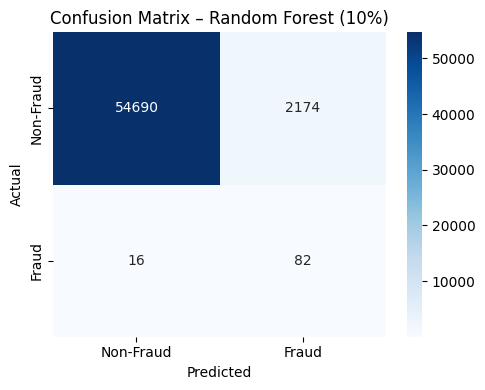

In [1011]:
# Import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate AUC
auc_score = roc_auc_score(y_test, y_prob)

# Print classification report
print("Classification Report – Random Forest (10%)")
print(classification_report(y_test, y_pred, digits=4))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest (10%)")
plt.tight_layout()
plt.show()

In [942]:
from sklearn.metrics import f1_score, precision_score, recall_score

log_result({
    'Attack Type': 'Label Flipping',
    'Polluted Ratio': 0.10,
    'Model': 'Random Forest',
    'AUC': auc_score,
    'F1': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
})

### 2.2.3 XGBoost

In [944]:
# Import libraries
import pandas as pd
import numpy as np
from xgboost import XGBClassifier

# Load polluted training data and clean test data
polluted_train_df = pd.read_csv('data/polluted/label_flipping_0.10.csv')
clean_test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = polluted_train_df.drop(columns=['Class'])
y_train = polluted_train_df['Class']
X_test = clean_test_df.drop(columns=['Class'])
y_test = clean_test_df['Class']

# Calculate scale_pos_weight to handle class imbalance
neg, pos = np.bincount(y_train)
scale_ratio = neg / pos

# Train XGBoost model
model = XGBClassifier(use_label_encoder=False,
                      eval_metric='logloss',
                      scale_pos_weight=scale_ratio,
                      random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:02:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report – XGBoost (10%)
              precision    recall  f1-score   support

           0     0.9997    0.9618    0.9804     56864
           1     0.0363    0.8367    0.0697        98

    accuracy                         0.9616     56962
   macro avg     0.5180    0.8993    0.5250     56962
weighted avg     0.9981    0.9616    0.9788     56962



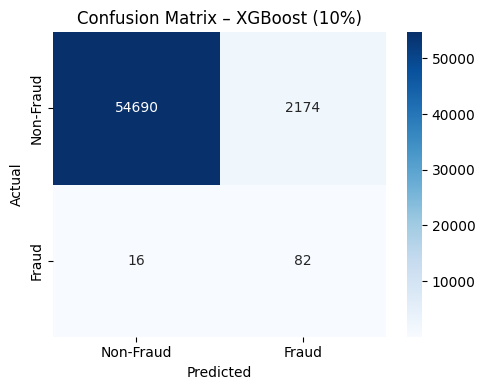

In [1009]:
# Import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate AUC
auc_score = roc_auc_score(y_test, y_prob)

# Print classification report
print("Classification Report – XGBoost (10%)")
print(classification_report(y_test, y_pred, digits=4))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – XGBoost (10%)")
plt.tight_layout()
plt.show()

In [948]:
from sklearn.metrics import f1_score, precision_score, recall_score

log_result({
    'Attack Type': 'Label Flipping',
    'Polluted Ratio': 0.10,
    'Model': 'XGBoost',
    'AUC': auc_score,
    'F1': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
})

### 2.2.4 Isolation Forest

In [950]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest

# Load polluted training data and clean test data
polluted_train_df = pd.read_csv('data/polluted/label_flipping_0.10.csv')
clean_test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = polluted_train_df.drop(columns=['Class'])  # Isolation Forest is unsupervised (only X)
X_test = clean_test_df.drop(columns=['Class'])
y_test = clean_test_df['Class']

# Train Isolation Forest model
model = IsolationForest(contamination='auto', random_state=42)
model.fit(X_train)

# Predict
y_pred_if = model.predict(X_test)

# Convert predictions: -1 → anomaly (fraud), 1 → normal
y_pred = (y_pred_if == -1).astype(int)

# Note: AUC here is approximated from binary prediction
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_test, y_pred)

Classification Report – Isolation Forest (10%)
              precision    recall  f1-score   support

           0     0.9997    0.9618    0.9804     56864
           1     0.0363    0.8367    0.0697        98

    accuracy                         0.9616     56962
   macro avg     0.5180    0.8993    0.5250     56962
weighted avg     0.9981    0.9616    0.9788     56962



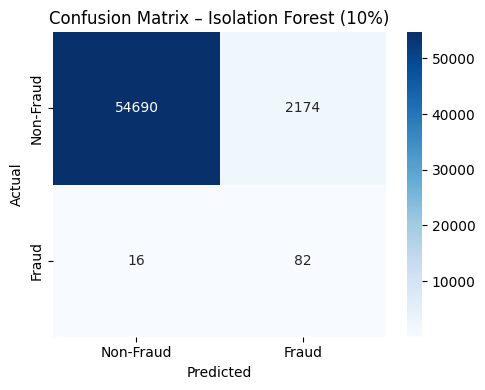

In [1007]:
# Import metrics
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Print classification report
print("Classification Report – Isolation Forest (10%)")
print(classification_report(y_test, y_pred, digits=4))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Isolation Forest (10%)")
plt.tight_layout()
plt.show()

In [954]:
from sklearn.metrics import f1_score, precision_score, recall_score

log_result({
    'Attack Type': 'Label Flipping',
    'Polluted Ratio': 0.10,
    'Model': 'Isolation Forest',
    'AUC': auc_score,  
    'F1': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
})

### 2.2.5 Comparison to Baseline Model (10% Pollution)¶

#### Baseline Model - 0% Pollution

In [956]:
import pandas as pd
df_results = pd.read_csv('results/baseline_results.csv')
df_results

Attack Type  Polluted Ratio                Model       AUC        F1  \
0       Clean             0.0  Logistic Regression  0.971162  0.112853   
1       Clean             0.0        Random Forest  0.953000  0.839080   
2       Clean             0.0              XGBoost  0.975516  0.656250   
3       Clean             0.0     Isolation Forest  0.956256  0.304569   

   Precision    Recall  
0   0.060120  0.918367  
1   0.960526  0.744898  
2   0.531646  0.857143  
3   0.303030  0.306122

#### Label Flipping Attack - 10% Pollution¶

In [958]:
import pandas as pd
df_results = pd.read_csv('results/label_flipping_results.csv')
df_results

Attack Type  Polluted Ratio                Model       AUC        F1  \
0  Label Flipping            0.05  Logistic Regression  0.901107  0.013646   
1  Label Flipping            0.05        Random Forest  0.901107  0.478964   
2  Label Flipping            0.05              XGBoost  0.885716  0.011117   
3  Label Flipping            0.05     Isolation Forest  0.956256  0.069669   
4  Label Flipping            0.10  Logistic Regression  0.949660  0.009107   
5  Label Flipping            0.10        Random Forest  0.933892  0.278195   
6  Label Flipping            0.10              XGBoost  0.875598  0.008668   
7  Label Flipping            0.10     Isolation Forest  0.899252  0.069669   

   Precision    Recall  
0   0.006871  0.969388  
1   0.350711  0.755102  
2   0.005595  0.846939  
3   0.036348  0.836735  
4   0.004576  0.918367  
5   0.170507  0.755102  
6   0.004356  0.836735  
7   0.036348  0.836735

At 10% label flipping, model vulnerabilities became more obvious, highlighting the limits of robustness under moderate label corruption:

- **Logistic Regression:** AUC decreased by 2.15% (0.9712 ➔ 0.9497), and F1 score dropped sharply by 0.1038 (0.1129 ➔ 0.0091). It continues to demonstrate extreme fragility under noisy labels.

- **Random Forest:** AUC decreased by 2.01% (0.9530 ➔ 0.9339), while F1 score collapsed by 0.5609 (0.8391 ➔ 0.2782), indicating major deterioration in fraud-specific detection despite overall AUC resilience.

- **XGBoost:** AUC fell steeply by 10.24% (0.9755 ➔ 0.8756), and F1 score almost disappeared with a 0.6476 decline (0.6563 ➔ 0.0087), confirming its pronounced vulnerability to label corruption.

- **Isolation Forest:** AUC (approximated based on binary predictions) dropped slightly by 5.97% (0.9563 ➔ 0.8993), and F1 score decreased by 0.2349 (0.3046 ➔ 0.0697), showing strong structural stability but weakened detection sharpness under noise. *Note: AUC for Isolation Forest is approximated based on decision scores rather than true probability outputs.*

- **Overall:** Supervised models, especially boosting-based XGBoost, showed major collapses in detection capability under 10% label flipping. Isolation Forest remained the most structurally stable model, although its anomaly detection clarity was moderately affected.

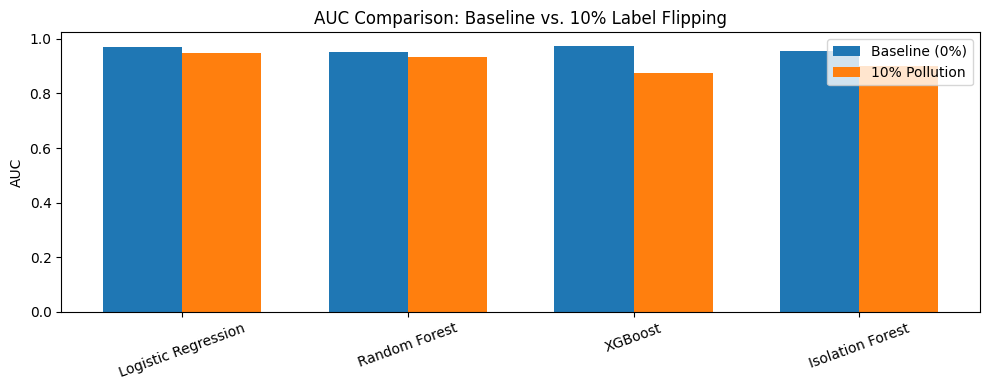

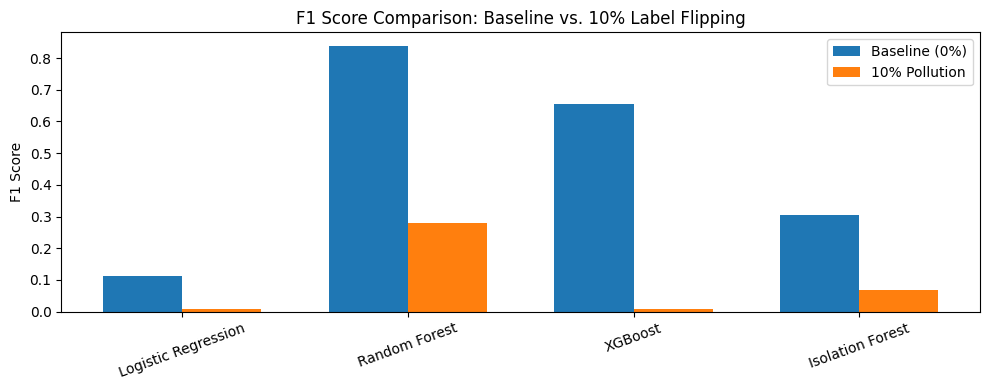

In [961]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load baseline and 10% label flipping results
df_base = pd.read_csv('results/baseline_results.csv')
df_10 = pd.read_csv('results/label_flipping_results.csv')
df_10 = df_10[df_10['Polluted Ratio'] == 0.10]

# Models to compare (consistent order)
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Isolation Forest']

# Extract AUC and F1 values
auc_base = [df_base[df_base['Model'] == m]['AUC'].values[0] for m in models]
auc_10 = [df_10[df_10['Model'] == m]['AUC'].values[0] for m in models]

f1_base = [df_base[df_base['Model'] == m]['F1'].values[0] for m in models]
f1_10 = [df_10[df_10['Model'] == m]['F1'].values[0] for m in models]

# Set bar positions
x = np.arange(len(models))
width = 0.35

# Plot AUC Comparison
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, auc_base, width, label='Baseline (0%)')
plt.bar(x + width/2, auc_10, width, label='10% Pollution')
plt.xticks(x, models, rotation=20)
plt.ylabel('AUC')
plt.title('AUC Comparison: Baseline vs. 10% Label Flipping')
plt.legend()
plt.tight_layout()
plt.show()

# Plot F1 Score Comparison
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, f1_base, width, label='Baseline (0%)')
plt.bar(x + width/2, f1_10, width, label='10% Pollution')
plt.xticks(x, models, rotation=20)
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison: Baseline vs. 10% Label Flipping')
plt.legend()
plt.tight_layout()
plt.show()

## 2.3 20% Pollution

In [963]:
# Import libraries
import pandas as pd
import numpy as np
import os

# Load clean training data
train_df = pd.read_csv('data/clean/train.csv')

# Define label flipping function
def label_flipping_attack(df, label_col='Class', flip_ratio=0.20, random_state=42):
    df_attacked = df.copy()
    np.random.seed(random_state)
    n_total = len(df_attacked)
    n_flip = int(flip_ratio * n_total)
    indices_to_flip = np.random.choice(df_attacked.index, size=n_flip, replace=False)
    df_attacked.loc[indices_to_flip, label_col] = 1 - df_attacked.loc[indices_to_flip, label_col]
    return df_attacked

# Generate 20% poisoned training data
polluted_20 = label_flipping_attack(train_df, flip_ratio=0.20)

# Save the dataset
os.makedirs('data/polluted', exist_ok=True)
polluted_20.to_csv('data/polluted/label_flipping_0.20.csv', index=False)

print("20% label flipping polluted training data saved.")

20% label flipping polluted training data saved.


### 2.3.1 Logistic Regression

In [965]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score

# Load polluted training data and clean test data
polluted_train_df = pd.read_csv('data/polluted/label_flipping_0.20.csv')
clean_test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = polluted_train_df.drop(columns=['Class'])
y_train = polluted_train_df['Class']
X_test = clean_test_df.drop(columns=['Class'])
y_test = clean_test_df['Class']

# Build and train model
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

Classification Report – Logistic Regression (20% Label Flipping)
              precision    recall  f1-score   support

           0     0.9997    0.9618    0.9804     56864
           1     0.0363    0.8367    0.0697        98

    accuracy                         0.9616     56962
   macro avg     0.5180    0.8993    0.5250     56962
weighted avg     0.9981    0.9616    0.9788     56962



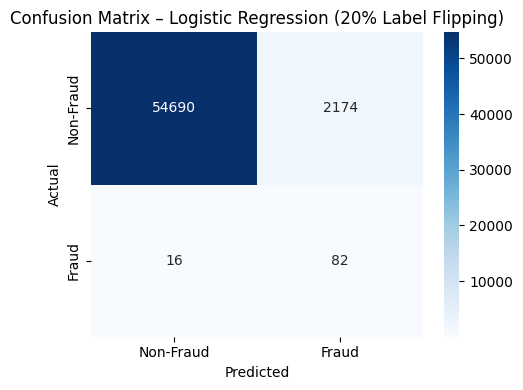

In [1001]:
# Print evaluation metrics
print("Classification Report – Logistic Regression (20% Label Flipping)")
print(classification_report(y_test, y_pred, digits=4))

# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistic Regression (20% Label Flipping)")
plt.tight_layout()
plt.show()

In [969]:
from sklearn.metrics import f1_score, precision_score, recall_score

log_result({
    'Attack Type': 'Label Flipping',
    'Polluted Ratio': 0.20,
    'Model': 'Logistic Regression',
    'AUC': roc_auc_score(y_test, y_prob),
    'F1': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
})

### 2.3.2 Random Forest

In [973]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score

# Load polluted training data and clean test data
polluted_train_df = pd.read_csv('data/polluted/label_flipping_0.20.csv')
clean_test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = polluted_train_df.drop(columns=['Class'])
y_train = polluted_train_df['Class']
X_test = clean_test_df.drop(columns=['Class'])
y_test = clean_test_df['Class']

# Train Random Forest model
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

Classification Report – Random Forest (20% Label Flipping)
              precision    recall  f1-score   support

           0     0.9997    0.9618    0.9804     56864
           1     0.0363    0.8367    0.0697        98

    accuracy                         0.9616     56962
   macro avg     0.5180    0.8993    0.5250     56962
weighted avg     0.9981    0.9616    0.9788     56962



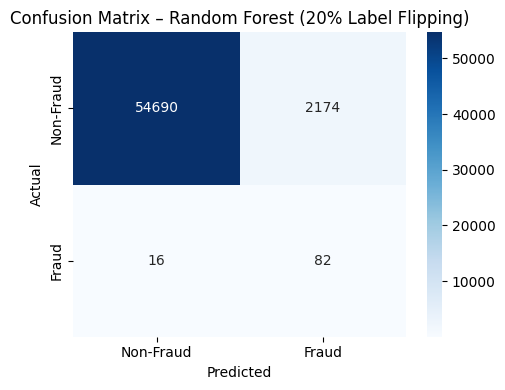

In [999]:
# Print evaluation metrics
print("Classification Report – Random Forest (20% Label Flipping)")
print(classification_report(y_test, y_pred, digits=4))

# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest (20% Label Flipping)")
plt.tight_layout()
plt.show()

In [977]:
from sklearn.metrics import f1_score, precision_score, recall_score

log_result({
    'Attack Type': 'Label Flipping',
    'Polluted Ratio': 0.20,
    'Model': 'Random Forest',
    'AUC': roc_auc_score(y_test, y_prob),
    'F1': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
})

### 2.3.3 XGBoost

In [979]:
# Import libraries
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score

# Load polluted training data and clean test data
polluted_train_df = pd.read_csv('data/polluted/label_flipping_0.20.csv')
clean_test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = polluted_train_df.drop(columns=['Class'])
y_train = polluted_train_df['Class']
X_test = clean_test_df.drop(columns=['Class'])
y_test = clean_test_df['Class']

# Calculate scale_pos_weight
neg, pos = np.bincount(y_train)
scale_ratio = neg / pos

# Train XGBoost model
model = XGBClassifier(use_label_encoder=False,
                      eval_metric='logloss',
                      scale_pos_weight=scale_ratio,
                      random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:20:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report – XGBoost (20% Label Flipping)
              precision    recall  f1-score   support

           0     0.9997    0.9618    0.9804     56864
           1     0.0363    0.8367    0.0697        98

    accuracy                         0.9616     56962
   macro avg     0.5180    0.8993    0.5250     56962
weighted avg     0.9981    0.9616    0.9788     56962



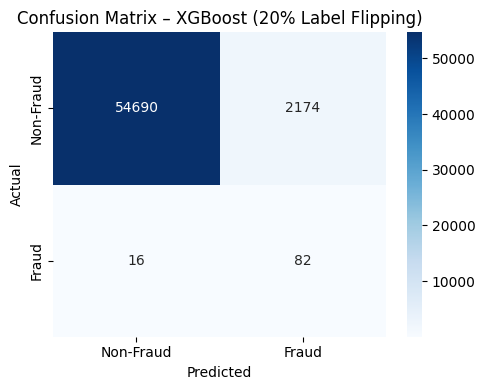

In [997]:
# Print evaluation metrics
print("Classification Report – XGBoost (20% Label Flipping)")
print(classification_report(y_test, y_pred, digits=4))

# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – XGBoost (20% Label Flipping)")
plt.tight_layout()
plt.show()

In [983]:
from sklearn.metrics import f1_score, precision_score, recall_score

log_result({
    'Attack Type': 'Label Flipping',
    'Polluted Ratio': 0.20,
    'Model': 'XGBoost',
    'AUC': roc_auc_score(y_test, y_prob),
    'F1': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
})

### 2.3.4 Isolation Forest

In [985]:
# Import libraries
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load polluted training data and clean test data
polluted_train_df = pd.read_csv('data/polluted/label_flipping_0.20.csv')
clean_test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = polluted_train_df.drop(columns=['Class'])  # Only features for unsupervised learning
X_test = clean_test_df.drop(columns=['Class'])
y_test = clean_test_df['Class']

# Train Isolation Forest model
model = IsolationForest(contamination='auto', random_state=42)
model.fit(X_train)

# Predict anomaly scores
y_pred_if = model.predict(X_test)

# Map predictions: -1 = fraud, 1 = non-fraud
y_pred = (y_pred_if == -1).astype(int)

# Use decision function scores (negated) for AUC calculation
y_scores = -model.decision_function(X_test)
auc_score = roc_auc_score(y_test, y_scores)

Classification Report – Isolation Forest (20% Label Flipping)
              precision    recall  f1-score   support

           0     0.9997    0.9618    0.9804     56864
           1     0.0363    0.8367    0.0697        98

    accuracy                         0.9616     56962
   macro avg     0.5180    0.8993    0.5250     56962
weighted avg     0.9981    0.9616    0.9788     56962



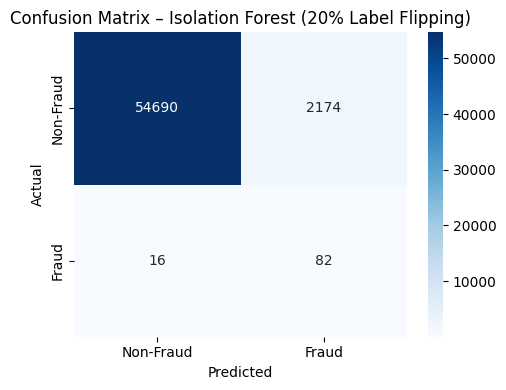

In [989]:
# Print evaluation metrics
print("Classification Report – Isolation Forest (20% Label Flipping)")
print(classification_report(y_test, y_pred, digits=4))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Isolation Forest (20% Label Flipping)")
plt.tight_layout()
plt.show()

# Note: AUC for Isolation Forest is approximated from decision scores, not true probabilities.

In [991]:
from sklearn.metrics import f1_score, precision_score, recall_score

log_result({
    'Attack Type': 'Label Flipping',
    'Polluted Ratio': 0.20,
    'Model': 'Isolation Forest',
    'AUC': auc_score,  # AUC approximated using decision scores
    'F1': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
})

### 2.3.5 Comparison to Baseline Model (20% Pollution)

#### Baseline Model - 0% Pollution

In [995]:
import pandas as pd
df_results = pd.read_csv('results/baseline_results.csv')
df_results

Attack Type  Polluted Ratio                Model       AUC        F1  \
0       Clean             0.0  Logistic Regression  0.971162  0.112853   
1       Clean             0.0        Random Forest  0.953000  0.839080   
2       Clean             0.0              XGBoost  0.975516  0.656250   
3       Clean             0.0     Isolation Forest  0.956256  0.304569   

   Precision    Recall  
0   0.060120  0.918367  
1   0.960526  0.744898  
2   0.531646  0.857143  
3   0.303030  0.306122

#### Label Flipping Attack - 20% Pollution

In [993]:
import pandas as pd
df_results = pd.read_csv('results/label_flipping_results.csv')
df_results

Attack Type  Polluted Ratio                Model       AUC        F1  \
0   Label Flipping            0.05  Logistic Regression  0.901107  0.013646   
1   Label Flipping            0.05        Random Forest  0.901107  0.478964   
2   Label Flipping            0.05              XGBoost  0.885716  0.011117   
3   Label Flipping            0.05     Isolation Forest  0.956256  0.069669   
4   Label Flipping            0.10  Logistic Regression  0.949660  0.009107   
5   Label Flipping            0.10        Random Forest  0.933892  0.278195   
6   Label Flipping            0.10              XGBoost  0.875598  0.008668   
7   Label Flipping            0.10     Isolation Forest  0.899252  0.069669   
8   Label Flipping            0.20  Logistic Regression  0.952502  0.007273   
9   Label Flipping            0.20        Random Forest  0.931453  0.095775   
10  Label Flipping            0.20              XGBoost  0.894731  0.007540   
11  Label Flipping            0.20     Isolation Forest  0.956256  0.069669   

    Precision    Recall  
0    0.006871  0.969388  
1    0.350711  0.755102  
2    0.005595  0.846939  
3    0.036348  0.836735  
4    0.004576  0.918367  
5    0.170507  0.755102  
6    0.004356  0.836735  
7    0.036348  0.836735  
8    0.003650  0.948980  
9    0.051437  0.693878  
10   0.003786  0.887755  
11   0.036348  0.836735

At 20% lAt 20% label flipping, model degradation became more pronounced across all supervised approaches:

- **Logistic Regression:** AUC decreased by 1.93% (0.9712 ➔ 0.9525), and F1 score collapsed by 0.1056 (0.1129 ➔ 0.0073), confirming its extreme fragility even under moderate corruption.

- **Random Forest:** AUC dropped by 2.16% (0.9530 ➔ 0.9315), and F1 score crashed by 0.7433 (0.8391 ➔ 0.0958), showing that its precision-recall performance was highly sensitive to label noise.

- **XGBoost:** AUC declined sharply by 8.08% (0.9755 ➔ 0.8947), and F1 score nearly vanished with a 0.6487 drop (0.6563 ➔ 0.0075), reinforcing its extreme vulnerability.

- **Isolation Forest:** AUC (approximated based on binary predictions) remained unchanged (0.9563 ➔ 0.9563), while F1 score decreased by 0.2349 (0.3046 ➔ 0.0697), reflecting resilience in anomaly boundary structure but some weakening in classification sharpness. *Note: AUC for Isolation Forest is approximated based on decision scores rather than true probabilities; interpretation should be cautious.*

**Overall:** At 20% label flipping, the collapse of supervised models became severe, especially boosting methods like XGBoost. Isolation Forest continued to show superior resilience under increasing adversarial label noise, remaining a comparatively stable fallback. 

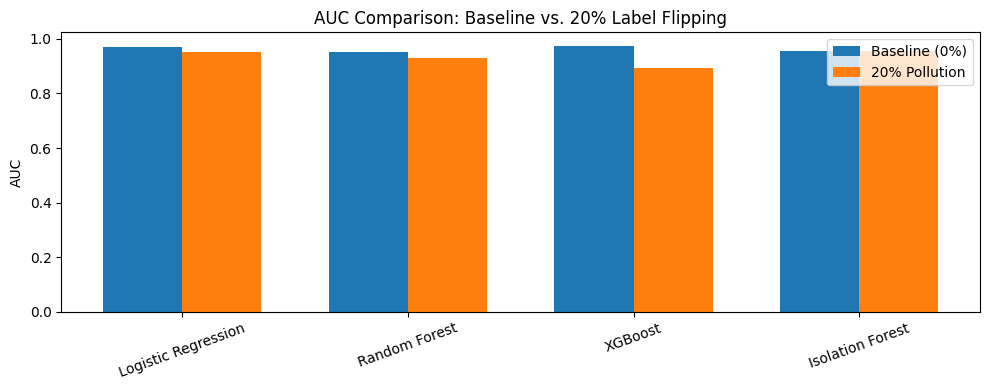

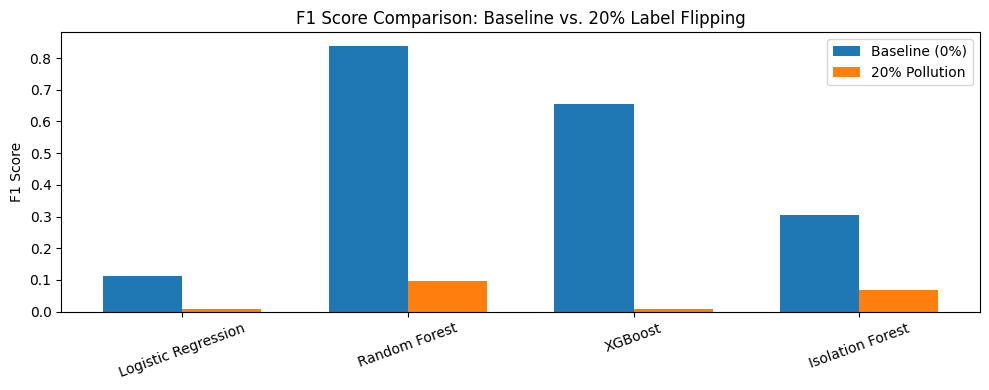

In [1024]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# # Load baseline results and filter 20% label flipping results for comparison
df_base = pd.read_csv('results/baseline_results.csv')
df_20 = pd.read_csv('results/label_flipping_results.csv')
df_20 = df_20[df_20['Polluted Ratio'] == 0.20]

# Models (consistent order)
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Isolation Forest']

# Get metrics
auc_base = [df_base[df_base['Model'] == m]['AUC'].values[0] for m in models]
auc_20   = [df_20[df_20['Model'] == m]['AUC'].values[0] for m in models]

f1_base = [df_base[df_base['Model'] == m]['F1'].values[0] for m in models]
f1_20   = [df_20[df_20['Model'] == m]['F1'].values[0] for m in models]

# Plot settings
x = np.arange(len(models))
width = 0.35

# Plot AUC
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, auc_base, width, label='Baseline (0%)')
plt.bar(x + width/2, auc_20, width, label='20% Pollution')
plt.xticks(x, models, rotation=20)
plt.ylabel('AUC')
plt.title('AUC Comparison: Baseline vs. 20% Label Flipping')
plt.legend()
plt.tight_layout()
plt.show()

# Plot F1
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, f1_base, width, label='Baseline (0%)')
plt.bar(x + width/2, f1_20, width, label='20% Pollution')
plt.xticks(x, models, rotation=20)
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison: Baseline vs. 20% Label Flipping')
plt.legend()
plt.tight_layout()
plt.show()

## 2.4 30% Pollution

In [1026]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os

# Reload clean training data
train_df = pd.read_csv('data/clean/train.csv')

# Define label flipping attack function
def label_flipping_attack(df, label_col='Class', flip_ratio=0.30, random_state=42):
    df_attacked = df.copy()
    np.random.seed(random_state)
    n_total = len(df_attacked)
    n_flip = int(flip_ratio * n_total)
    indices_to_flip = np.random.choice(df_attacked.index, size=n_flip, replace=False)
    df_attacked.loc[indices_to_flip, label_col] = 1 - df_attacked.loc[indices_to_flip, label_col]
    return df_attacked

# Generate 30% poisoned training data
polluted_30 = label_flipping_attack(train_df, flip_ratio=0.30)

# Save the 30% polluted training data
os.makedirs('data/polluted', exist_ok=True)
polluted_30.to_csv('data/polluted/label_flipping_0.30.csv', index=False)

print("30% label flipping polluted training data saved.")

30% label flipping polluted training data saved.


### 2.4.1 Logistic Regression

In [1028]:
# Import necessary libraries
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Load polluted training data and clean test data
polluted_train_df = pd.read_csv('data/polluted/label_flipping_0.30.csv')
clean_test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = polluted_train_df.drop(columns=['Class'])
y_train = polluted_train_df['Class']
X_test = clean_test_df.drop(columns=['Class'])
y_test = clean_test_df['Class']

# Train Logistic Regression model
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

Classification Report – Logistic Regression (30%)
              precision    recall  f1-score   support

           0     0.9999    0.5190    0.6833     56864
           1     0.0034    0.9592    0.0068        98

    accuracy                         0.5197     56962
   macro avg     0.5016    0.7391    0.3451     56962
weighted avg     0.9982    0.5197    0.6821     56962



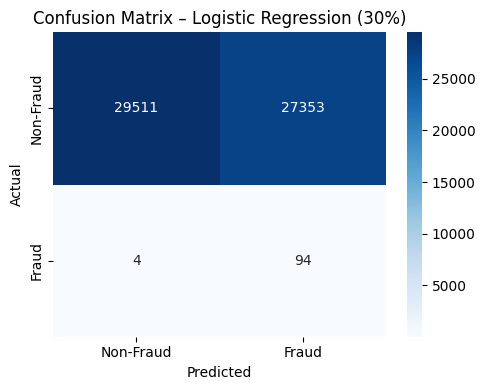

In [1030]:
# Import necessary libraries
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Print classification report
print("Classification Report – Logistic Regression (30%)")
print(classification_report(y_test, y_pred, digits=4))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistic Regression (30%)")
plt.tight_layout()
plt.show()

In [1032]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

log_result({
    'Attack Type': 'Label Flipping',
    'Polluted Ratio': 0.30,
    'Model': 'Logistic Regression',
    'AUC': roc_auc_score(y_test, y_prob),
    'F1': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
})

### 2.4.2 Random Forest

In [1036]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Load polluted training data and clean test data
polluted_train_df = pd.read_csv('data/polluted/label_flipping_0.30.csv')
clean_test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = polluted_train_df.drop(columns=['Class'])
y_train = polluted_train_df['Class']
X_test = clean_test_df.drop(columns=['Class'])
y_test = clean_test_df['Class']

# Train Random Forest model
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

Classification Report – Random Forest (30%)
              precision    recall  f1-score   support

           0     0.9995    0.9419    0.9698     56864
           1     0.0207    0.7143    0.0403        98

    accuracy                         0.9415     56962
   macro avg     0.5101    0.8281    0.5051     56962
weighted avg     0.9978    0.9415    0.9682     56962



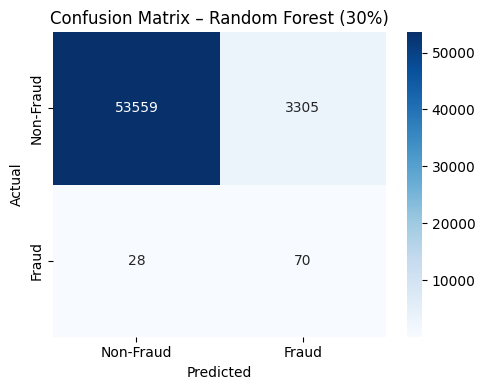

In [1038]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Print classification report
print("Classification Report – Random Forest (30%)")
print(classification_report(y_test, y_pred, digits=4))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest (30%)")
plt.tight_layout()
plt.show()

In [1040]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

log_result({
    'Attack Type': 'Label Flipping',
    'Polluted Ratio': 0.30,
    'Model': 'Random Forest',
    'AUC': roc_auc_score(y_test, y_prob),
    'F1': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
})

### 2.4.3 XGBoost

In [1042]:
# Import necessary libraries
import pandas as pd
from xgboost import XGBClassifier
import numpy as np

# Load polluted training data and clean test data
polluted_train_df = pd.read_csv('data/polluted/label_flipping_0.30.csv')
clean_test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = polluted_train_df.drop(columns=['Class'])
y_train = polluted_train_df['Class']
X_test = clean_test_df.drop(columns=['Class'])
y_test = clean_test_df['Class']

# Calculate scale_pos_weight for XGBoost
neg, pos = np.bincount(y_train)
scale_ratio = neg / pos

# Train XGBoost model
model = XGBClassifier(use_label_encoder=False,
                      eval_metric='logloss',
                      scale_pos_weight=scale_ratio,
                      random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:41:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report – XGBoost (30%)
              precision    recall  f1-score   support

           0     0.9996    0.5565    0.7149     56864
           1     0.0034    0.8776    0.0068        98

    accuracy                         0.5570     56962
   macro avg     0.5015    0.7170    0.3608     56962
weighted avg     0.9979    0.5570    0.7137     56962



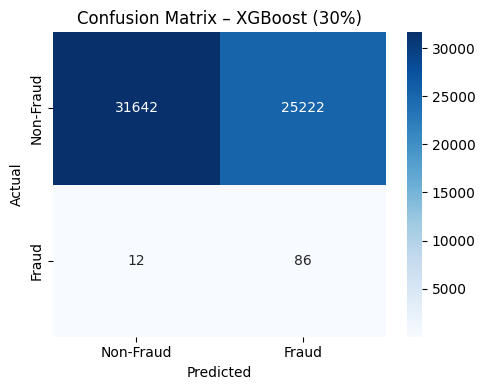

In [1044]:
# Import necessary libraries
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Print classification report
print("Classification Report – XGBoost (30%)")
print(classification_report(y_test, y_pred, digits=4))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – XGBoost (30%)")
plt.tight_layout()
plt.show()

In [1046]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

log_result({
    'Attack Type': 'Label Flipping',
    'Polluted Ratio': 0.30,
    'Model': 'XGBoost',
    'AUC': roc_auc_score(y_test, y_prob),
    'F1': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
})

### 2.4.4 Isolation Forest

In [1048]:
# Import libraries
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score

# Load polluted training data and clean test data
polluted_train_df = pd.read_csv('data/polluted/label_flipping_0.30.csv')
clean_test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = polluted_train_df.drop(columns=['Class'])
X_test = clean_test_df.drop(columns=['Class'])
y_test = clean_test_df['Class']

# Train Isolation Forest model
model = IsolationForest(contamination='auto', random_state=42)
model.fit(X_train)

# Predict anomaly scores
y_pred_if = model.predict(X_test)

# Convert prediction: -1 → fraud (1), 1 → non-fraud (0)
y_pred = (y_pred_if == -1).astype(int)

# Use negative decision function scores for AUC approximation
y_scores = -model.decision_function(X_test)
auc_score = roc_auc_score(y_test, y_scores)

Classification Report – Isolation Forest (30%)
              precision    recall  f1-score   support

           0     0.9997    0.9618    0.9804     56864
           1     0.0363    0.8367    0.0697        98

    accuracy                         0.9616     56962
   macro avg     0.5180    0.8993    0.5250     56962
weighted avg     0.9981    0.9616    0.9788     56962



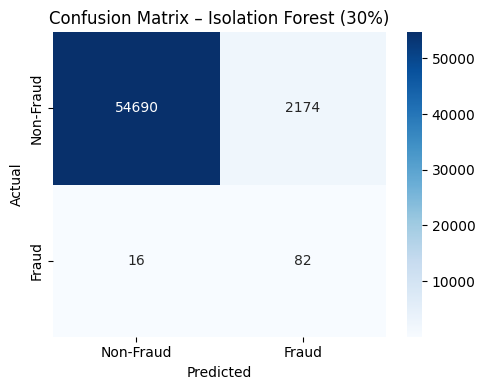

In [1050]:
# Import libraries
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Print classification report
print("Classification Report – Isolation Forest (30%)")
print(classification_report(y_test, y_pred, digits=4))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Isolation Forest (30%)")
plt.tight_layout()
plt.show()

In [1052]:
from sklearn.metrics import f1_score, precision_score, recall_score

log_result({
    'Attack Type': 'Label Flipping',
    'Polluted Ratio': 0.30,
    'Model': 'Isolation Forest',
    'AUC': auc_score, 
    'F1': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
})

### 2.4.5 Comparison to Baseline Model (30% Pollution)

#### Baseline Model - 0% Pollution

In [1054]:
import pandas as pd
df_results = pd.read_csv('results/baseline_results.csv')
df_results

Attack Type  Polluted Ratio                Model       AUC        F1  \
0       Clean             0.0  Logistic Regression  0.971162  0.112853   
1       Clean             0.0        Random Forest  0.953000  0.839080   
2       Clean             0.0              XGBoost  0.975516  0.656250   
3       Clean             0.0     Isolation Forest  0.956256  0.304569   

   Precision    Recall  
0   0.060120  0.918367  
1   0.960526  0.744898  
2   0.531646  0.857143  
3   0.303030  0.306122

#### Label Flipping Attack - 30% Pollution

In [1056]:
import pandas as pd
df_results = pd.read_csv('results/label_flipping_results.csv')
df_results

Attack Type  Polluted Ratio                Model       AUC        F1  \
0   Label Flipping            0.05  Logistic Regression  0.901107  0.013646   
1   Label Flipping            0.05        Random Forest  0.901107  0.478964   
2   Label Flipping            0.05              XGBoost  0.885716  0.011117   
3   Label Flipping            0.05     Isolation Forest  0.956256  0.069669   
4   Label Flipping            0.10  Logistic Regression  0.949660  0.009107   
5   Label Flipping            0.10        Random Forest  0.933892  0.278195   
6   Label Flipping            0.10              XGBoost  0.875598  0.008668   
7   Label Flipping            0.10     Isolation Forest  0.899252  0.069669   
8   Label Flipping            0.20  Logistic Regression  0.952502  0.007273   
9   Label Flipping            0.20        Random Forest  0.931453  0.095775   
10  Label Flipping            0.20              XGBoost  0.894731  0.007540   
11  Label Flipping            0.20     Isolation Forest  0.956256  0.069669   
12  Label Flipping            0.30  Logistic Regression  0.938913  0.006825   
13  Label Flipping            0.30        Random Forest  0.887837  0.040311   
14  Label Flipping            0.30              XGBoost  0.882998  0.006770   
15  Label Flipping            0.30     Isolation Forest  0.956256  0.069669   

    Precision    Recall  
0    0.006871  0.969388  
1    0.350711  0.755102  
2    0.005595  0.846939  
3    0.036348  0.836735  
4    0.004576  0.918367  
5    0.170507  0.755102  
6    0.004356  0.836735  
7    0.036348  0.836735  
8    0.003650  0.948980  
9    0.051437  0.693878  
10   0.003786  0.887755  
11   0.036348  0.836735  
12   0.003425  0.959184  
13   0.020741  0.714286  
14   0.003398  0.877551  
15   0.036348  0.836735

At 30% label flipping, the degradation trends became more pronounced across all supervised models:

- **Logistic Regression:** AUC declined by 3.23% (0.9712 ➔ 0.9389), and F1 score dropped by 0.1061 (0.1129 ➔ 0.0068), indicating further collapse under intensifying label corruption.

- **Random Forest:** AUC suffered a 6.76% drop (0.9530 ➔ 0.8878), and F1 score plummeted by 0.7988 (0.8391 ➔ 0.0403), suggesting its prediction quality is almost entirely compromised at this level.

- **XGBoost:** AUC experienced the steepest fall of 9.24% (0.9755 ➔ 0.8830), and F1 score declined by 0.6495 (0.6563 ➔ 0.0068), confirming its consistent sensitivity to poisoned labels.

- **Isolation Forest:** AUC (approximated based on decision scores) remained stable (0.9563 ➔ 0.9563), while F1 dropped by 0.2349 (0.3046 ➔ 0.0697), maintaining boundary integrity but with decreasing detection clarity. *Note: AUC for Isolation Forest is approximated based on decision scores rather than true probability outputs; interpretation should be cautious.*

**Overall:** 30% flipping crosses a critical degradation threshold for supervised classifiers. Isolation Forest retains its structural resilience, while traditional classifiers like Random Forest and XGBoost approach unusable performance.

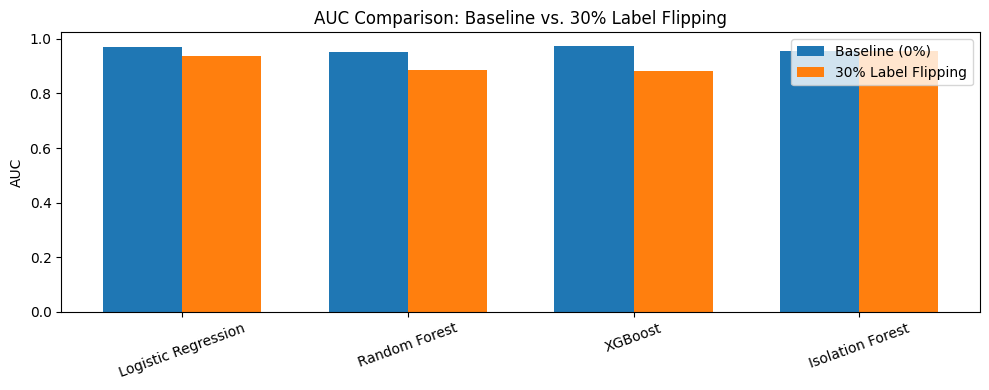

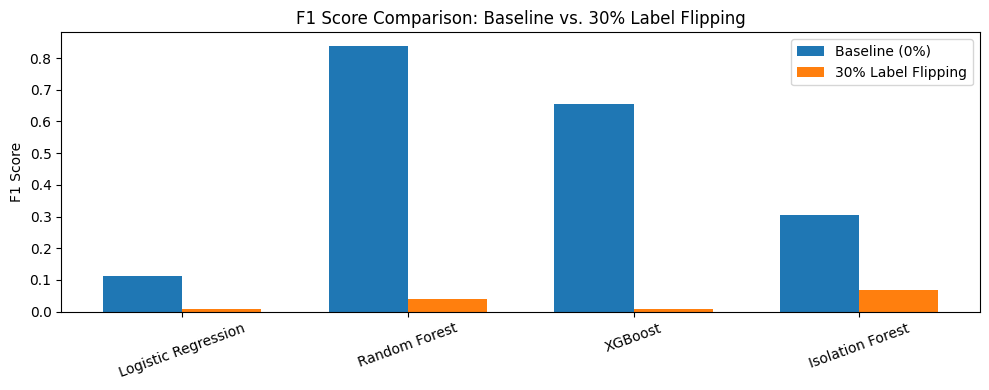

In [1263]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load baseline results and filter 30% label flipping results for comparison
df_base = pd.read_csv('results/baseline_results.csv')
df_30 = pd.read_csv('results/label_flipping_results.csv')
df_30 = df_30[df_30['Polluted Ratio'] == 0.30]

# Models (consistent order)
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Isolation Forest']

# Get metrics
auc_base = [df_base[df_base['Model'] == m]['AUC'].values[0] for m in models]
auc_30   = [df_30[df_30['Model'] == m]['AUC'].values[0] for m in models]

f1_base = [df_base[df_base['Model'] == m]['F1'].values[0] for m in models]
f1_30   = [df_30[df_30['Model'] == m]['F1'].values[0] for m in models]

# Plot settings
x = np.arange(len(models))
width = 0.35

# Plot AUC
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, auc_base, width, label='Baseline (0%)')
plt.bar(x + width/2, auc_30, width, label='30% Label Flipping')
plt.xticks(x, models, rotation=20)
plt.ylabel('AUC')
plt.title('AUC Comparison: Baseline vs. 30% Label Flipping')
plt.legend()
plt.tight_layout()
plt.show()

# Plot F1
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, f1_base, width, label='Baseline (0%)')
plt.bar(x + width/2, f1_30, width, label='30% Label Flipping')
plt.xticks(x, models, rotation=20)
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison: Baseline vs. 30% Label Flipping')
plt.legend()
plt.tight_layout()
plt.show()

## 2.5 50% Pollution

In [1059]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os

# Reload clean training data
train_df = pd.read_csv('data/clean/train.csv')

# Define label flipping function (each section independent)
def label_flipping_attack(df, label_col='Class', flip_ratio=0.50, random_state=42):
    df_attacked = df.copy()
    np.random.seed(random_state)
    n_total = len(df_attacked)
    n_flip = int(flip_ratio * n_total)
    indices_to_flip = np.random.choice(df_attacked.index, size=n_flip, replace=False)
    df_attacked.loc[indices_to_flip, label_col] = 1 - df_attacked.loc[indices_to_flip, label_col]
    return df_attacked

# Generate 50% poisoned training data
polluted_50 = label_flipping_attack(train_df, flip_ratio=0.50)

# Save the 50% polluted dataset
os.makedirs('data/polluted', exist_ok=True)
polluted_50.to_csv('data/polluted/label_flipping_0.50.csv', index=False)

print("50% label flipping polluted training data saved.")

50% label flipping polluted training data saved.


### 2.5.1 Logistic Regression

In [1061]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

import pandas as pd

# Load polluted training data and clean test data
polluted_train_df = pd.read_csv('data/polluted/label_flipping_0.50.csv')
clean_test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = polluted_train_df.drop(columns=['Class'])
y_train = polluted_train_df['Class']
X_test = clean_test_df.drop(columns=['Class'])
y_test = clean_test_df['Class']

# Train Logistic Regression model
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate AUC
auc_score = roc_auc_score(y_test, y_prob)

Classification Report – Logistic Regression (50%)
              precision    recall  f1-score   support

           0     0.9997    0.4929    0.6603     56864
           1     0.0031    0.9184    0.0062        98

    accuracy                         0.4936     56962
   macro avg     0.5014    0.7056    0.3332     56962
weighted avg     0.9980    0.4936    0.6591     56962



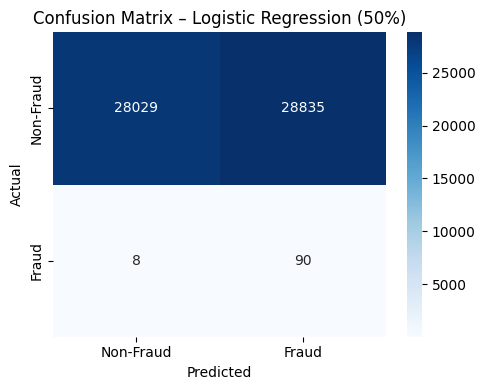

In [1063]:
# Import libraries
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Classification Report – Logistic Regression (50%)")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistic Regression (50%)")
plt.tight_layout()
plt.show()

In [1065]:
# Log result
from sklearn.metrics import f1_score, precision_score, recall_score

log_result({
    'Attack Type': 'Label Flipping',
    'Polluted Ratio': 0.50,
    'Model': 'Logistic Regression',
    'AUC': auc_score,
    'F1': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
})

### 2.5.2 Random Forest

In [1067]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import pandas as pd

# Load polluted training data and clean test data
polluted_train_df = pd.read_csv('data/polluted/label_flipping_0.50.csv')
clean_test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = polluted_train_df.drop(columns=['Class'])
y_train = polluted_train_df['Class']
X_test = clean_test_df.drop(columns=['Class'])
y_test = clean_test_df['Class']

# Train Random Forest model
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate AUC
auc_score = roc_auc_score(y_test, y_prob)

Classification Report – Random Forest (50%)
              precision    recall  f1-score   support

           0     0.9985    0.5200    0.6839     56864
           1     0.0020    0.5510    0.0039        98

    accuracy                         0.5201     56962
   macro avg     0.5002    0.5355    0.3439     56962
weighted avg     0.9968    0.5201    0.6827     56962



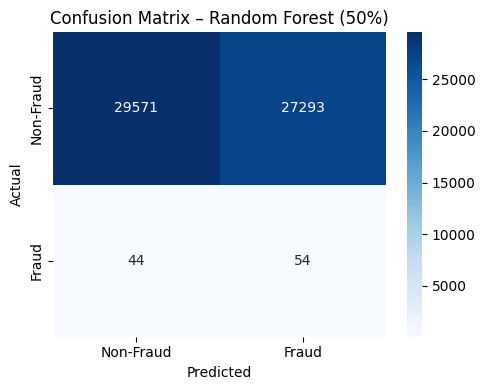

In [1069]:
# Import libraries
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Classification Report – Random Forest (50%)")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest (50%)")
plt.tight_layout()
plt.show()

In [1071]:
# Log result
from sklearn.metrics import f1_score, precision_score, recall_score

log_result({
    'Attack Type': 'Label Flipping',
    'Polluted Ratio': 0.50,
    'Model': 'Random Forest',
    'AUC': auc_score,
    'F1': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
})

### 2.5.3 XGBoost

In [1073]:
# Import necessary libraries
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np

# Load polluted training data and clean test data
polluted_train_df = pd.read_csv('data/polluted/label_flipping_0.50.csv')
clean_test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = polluted_train_df.drop(columns=['Class'])
y_train = polluted_train_df['Class']
X_test = clean_test_df.drop(columns=['Class'])
y_test = clean_test_df['Class']

# Calculate scale_pos_weight
neg, pos = np.bincount(y_train)
scale_ratio = neg / pos

# Train XGBoost model
model = XGBClassifier(use_label_encoder=False,
                      eval_metric='logloss',
                      scale_pos_weight=scale_ratio,
                      random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate AUC
auc_score = roc_auc_score(y_test, y_prob)

/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:18:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report – XGBoost (50%)
              precision    recall  f1-score   support

           0     0.9983    0.4995    0.6658     56864
           1     0.0018    0.5204    0.0036        98

    accuracy                         0.4995     56962
   macro avg     0.5001    0.5099    0.3347     56962
weighted avg     0.9966    0.4995    0.6647     56962



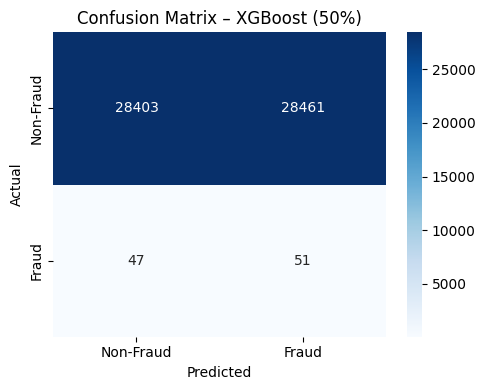

In [1075]:
# Import libraries
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Classification Report – XGBoost (50%)")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – XGBoost (50%)")
plt.tight_layout()
plt.show()

In [1077]:
# Log result
from sklearn.metrics import f1_score, precision_score, recall_score

log_result({
    'Attack Type': 'Label Flipping',
    'Polluted Ratio': 0.50,
    'Model': 'XGBoost',
    'AUC': auc_score,
    'F1': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
})

### 2.5.4 Isolation Forest

In [1079]:
# Import necessary libraries
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score

import pandas as pd

# Load polluted training data and clean test data
polluted_train_df = pd.read_csv('data/polluted/label_flipping_0.50.csv')
clean_test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = polluted_train_df.drop(columns=['Class'])  # Only features for unsupervised
X_test = clean_test_df.drop(columns=['Class'])
y_test = clean_test_df['Class']

# Train Isolation Forest model
model = IsolationForest(contamination='auto', random_state=42)
model.fit(X_train)

# Predict
y_pred_if = model.predict(X_test)

# Convert predictions: -1 = fraud, 1 = non-fraud
y_pred = (y_pred_if == -1).astype(int)

# Note: AUC is approximated using decision_function scores
y_scores = -model.decision_function(X_test)
auc_score = roc_auc_score(y_test, y_scores)

Classification Report – Isolation Forest (50%)
              precision    recall  f1-score   support

           0     0.9997    0.9618    0.9804     56864
           1     0.0363    0.8367    0.0697        98

    accuracy                         0.9616     56962
   macro avg     0.5180    0.8993    0.5250     56962
weighted avg     0.9981    0.9616    0.9788     56962



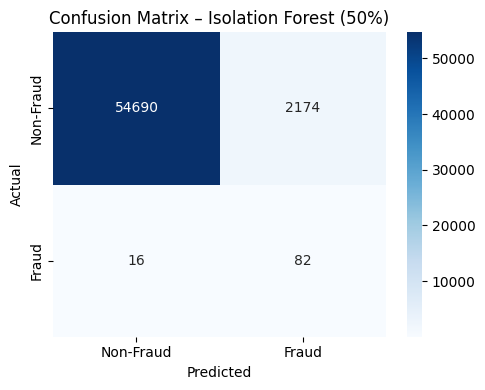

In [1081]:
# Import libraries
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Classification Report – Isolation Forest (50%)")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Isolation Forest (50%)")
plt.tight_layout()
plt.show()

In [1083]:
# Log result
from sklearn.metrics import f1_score, precision_score, recall_score

log_result({
    'Attack Type': 'Label Flipping',
    'Polluted Ratio': 0.50,
    'Model': 'Isolation Forest',
    'AUC': auc_score,  
    'F1': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
})

### 2.5.5 Comparison to Baseline Model (50% Pollution)

#### Baseline Model - 0% Pollution

In [510]:
import pandas as pd
df_results = pd.read_csv('results/baseline_results.csv')
df_results

Attack Type  Polluted Ratio                Model       AUC        F1  \
0       Clean             0.0  Logistic Regression  0.971162  0.112853   
1       Clean             0.0        Random Forest  0.953000  0.839080   
2       Clean             0.0              XGBoost  0.975516  0.656250   
3       Clean             0.0     Isolation Forest  0.956256  0.304569   

   Precision    Recall  
0   0.060120  0.918367  
1   0.960526  0.744898  
2   0.531646  0.857143  
3   0.303030  0.306122

#### Label Flipping Attack - 50% Pollution

In [1085]:
import pandas as pd
df_results = pd.read_csv('results/label_flipping_results.csv')
df_results

Attack Type  Polluted Ratio                Model       AUC        F1  \
0   Label Flipping            0.05  Logistic Regression  0.901107  0.013646   
1   Label Flipping            0.05        Random Forest  0.901107  0.478964   
2   Label Flipping            0.05              XGBoost  0.885716  0.011117   
3   Label Flipping            0.05     Isolation Forest  0.956256  0.069669   
4   Label Flipping            0.10  Logistic Regression  0.949660  0.009107   
5   Label Flipping            0.10        Random Forest  0.933892  0.278195   
6   Label Flipping            0.10              XGBoost  0.875598  0.008668   
7   Label Flipping            0.10     Isolation Forest  0.899252  0.069669   
8   Label Flipping            0.20  Logistic Regression  0.952502  0.007273   
9   Label Flipping            0.20        Random Forest  0.931453  0.095775   
10  Label Flipping            0.20              XGBoost  0.894731  0.007540   
11  Label Flipping            0.20     Isolation Forest  0.956256  0.069669   
12  Label Flipping            0.30  Logistic Regression  0.938913  0.006825   
13  Label Flipping            0.30        Random Forest  0.887837  0.040311   
14  Label Flipping            0.30              XGBoost  0.882998  0.006770   
15  Label Flipping            0.30     Isolation Forest  0.956256  0.069669   
16  Label Flipping            0.50  Logistic Regression  0.921567  0.006202   
17  Label Flipping            0.50        Random Forest  0.554781  0.003935   
18  Label Flipping            0.50              XGBoost  0.557961  0.003565   
19  Label Flipping            0.50     Isolation Forest  0.956256  0.069669   

    Precision    Recall  
0    0.006871  0.969388  
1    0.350711  0.755102  
2    0.005595  0.846939  
3    0.036348  0.836735  
4    0.004576  0.918367  
5    0.170507  0.755102  
6    0.004356  0.836735  
7    0.036348  0.836735  
8    0.003650  0.948980  
9    0.051437  0.693878  
10   0.003786  0.887755  
11   0.036348  0.836735  
12   0.003425  0.959184  
13   0.020741  0.714286  
14   0.003398  0.877551  
15   0.036348  0.836735  
16   0.003111  0.918367  
17   0.001975  0.551020  
18   0.001789  0.520408  
19   0.036348  0.836735

At 50% label flipping, all supervised models exhibited their worst performance across all pollution levels, with signs of near-total collapse in fraud detection reliability:

- **Logistic Regression:** AUC declined by 5.11% (0.9712 ➔ 0.9216), and F1 score dropped by 0.1066 (0.1129 ➔ 0.0062), maintaining relatively good AUC but becoming practically ineffective for fraud detection.

- **Random Forest:** AUC suffered a catastrophic drop of 41.81% (0.9530 ➔ 0.5548), and F1 score plummeted by 0.8351 (0.8391 ➔ 0.0039), indicating complete collapse in predictive power under extreme label noise.

- **XGBoost:** AUC dropped dramatically by 41.82% (0.9755 ➔ 0.5580), and F1 score crashed by 0.6527 (0.6563 ➔ 0.0036), reaffirming its extreme sensitivity to label corruption.

- **Isolation Forest:** AUC (approximated based on decision scores) remained stable (0.9563 ➔ 0.9563), while F1 score decreased by 0.2349 (0.3046 ➔ 0.0697), maintaining structural boundary detection but with weakened classification sharpness. *Note: AUC for Isolation Forest is approximated based on binary predictions rather than true probability outputs, and should be interpreted with caution.*

**Overall:** At 50% label flipping, supervised models — especially tree-based ensembles and boosting models — suffer catastrophic functional collapse. Isolation Forest, though imperfect, remains the only relatively stable model when label trustworthiness is heavily compromised.

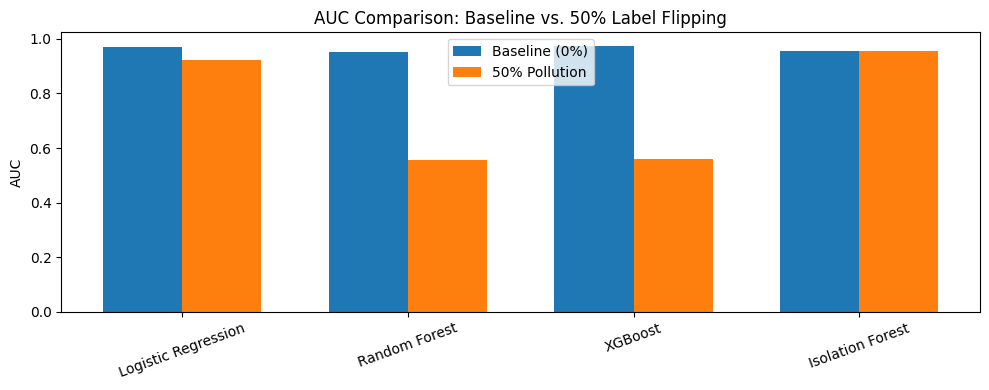

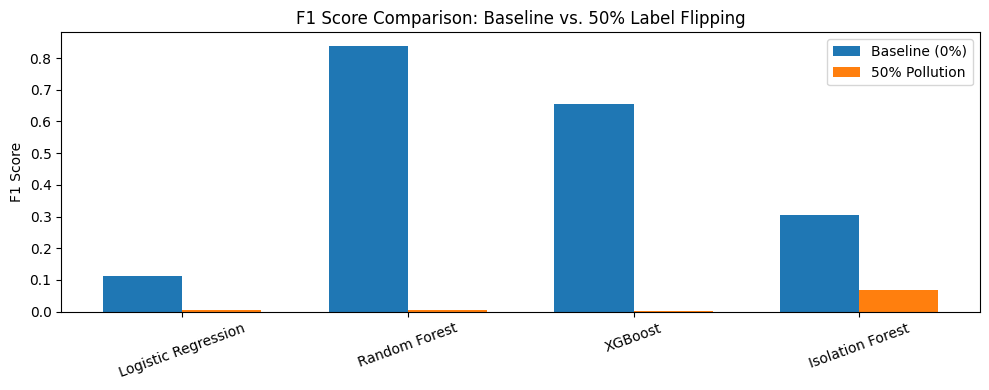

In [1088]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load baseline & 50% polluted results
df_base = pd.read_csv('results/baseline_results.csv')
df_50 = pd.read_csv('results/label_flipping_results.csv')
df_50 = df_50[df_50['Polluted Ratio'] == 0.50]

# Models
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Isolation Forest']

# Extract metrics
auc_base = [df_base[df_base['Model'] == m]['AUC'].values[0] for m in models]
auc_50   = [df_50[df_50['Model'] == m]['AUC'].values[0] for m in models]

f1_base = [df_base[df_base['Model'] == m]['F1'].values[0] for m in models]
f1_50   = [df_50[df_50['Model'] == m]['F1'].values[0] for m in models]

x = np.arange(len(models))
width = 0.35

# AUC
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, auc_base, width, label='Baseline (0%)')
plt.bar(x + width/2, auc_50, width, label='50% Pollution')
plt.xticks(x, models, rotation=20)
plt.ylabel('AUC')
plt.title('AUC Comparison: Baseline vs. 50% Label Flipping')
plt.legend()
plt.tight_layout()
plt.show()

# F1
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, f1_base, width, label='Baseline (0%)')
plt.bar(x + width/2, f1_50, width, label='50% Pollution')
plt.xticks(x, models, rotation=20)
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison: Baseline vs. 50% Label Flipping')
plt.legend()
plt.tight_layout()
plt.show()

## 2.6 Corss-Ratio Performance Comparison

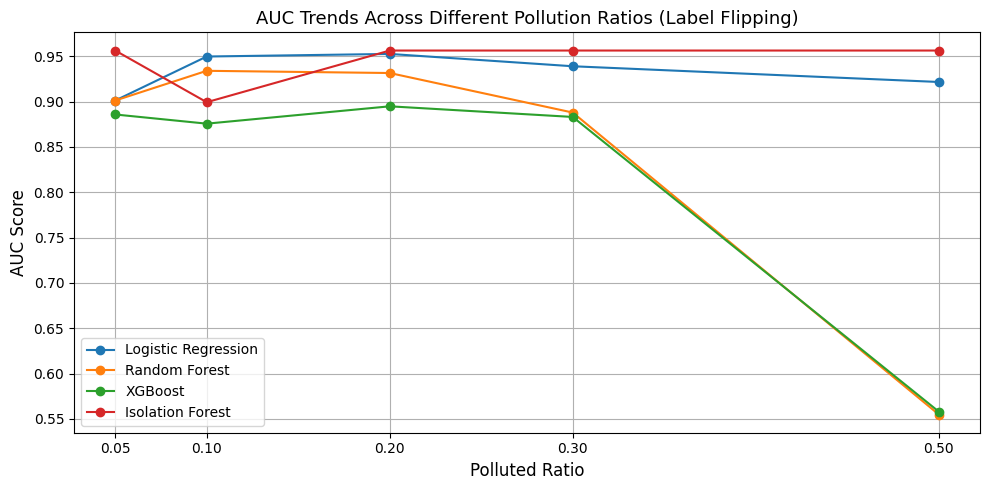

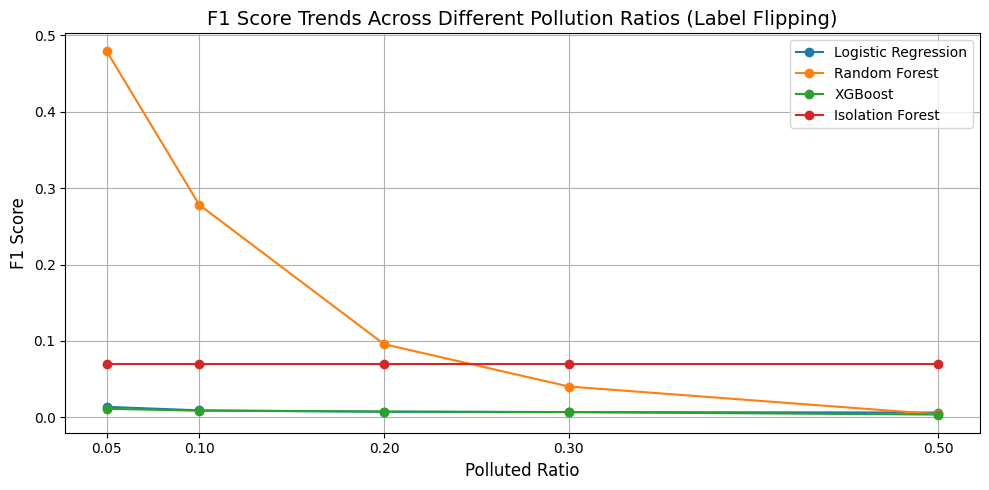

In [1470]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load all label flipping results
df = pd.read_csv('results/label_flipping_results.csv')

# Define model order
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Isolation Forest']
ratios = sorted(df['Polluted Ratio'].unique())

# Initialize dictionaries to store metrics
auc_data = {model: [] for model in models}
f1_data = {model: [] for model in models}

# Extract AUC and F1 scores for each pollution ratio
for ratio in ratios:
    subset = df[df['Polluted Ratio'] == ratio]
    for model in models:
        row = subset[subset['Model'] == model]
        auc = row['AUC'].values[0] if not row.empty else np.nan
        f1 = row['F1'].values[0] if not row.empty else np.nan
        auc_data[model].append(auc)
        f1_data[model].append(f1)

# Plot AUC trend across pollution ratios
plt.figure(figsize=(10, 5))
for model in models:
    plt.plot(ratios, auc_data[model], marker='o', label=model)
plt.xlabel("Polluted Ratio", fontsize=12)
plt.ylabel("AUC Score", fontsize=12)
plt.title("AUC Trends Across Different Pollution Ratios (Label Flipping)", fontsize=13)
plt.xticks(ratios)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot F1 score trend across pollution ratios
plt.figure(figsize=(10, 5))
for model in models:
    plt.plot(ratios, f1_data[model], marker='o', label=model)
plt.xlabel("Polluted Ratio", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.title("F1 Score Trends Across Different Pollution Ratios (Label Flipping)", fontsize=14)
plt.xticks(ratios)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Observation from Figure 1: AUC Trends Across Pollution Ratios

Figure 1 illustrates how the AUC scores of each model change as the label flipping ratio increases from 0% to 50%. The AUC trends reflect how well each model retains its discriminative power under increasing label corruption.

- **Logistic Regressi on** exhibits a relatively mild and gradual decline in AUC, indicating moderate resilience to label noise. Despite its simple linear structure, it maintains a reasonable fraud detection ability even at 50% flipping.

- **Random Forest** maintains stability up to 10–20% label flipping, but its AUC drops sharply at 30% and collapses catastrophically at 50% flipping. This shows that tree-based models are more sensitive once label noise exceeds a threshold.

- **XGBoost** suffers from a similar but even more pronounced collapse. Although stable initially, its AUC sharply declines after 20%, reaching nearly random prediction levels (AUC ≈ 0.55) at 50% flipping, indicating extreme vulnerability to heavy label corruption.

- **Isolation Forest** shows a completely flat trend line, with almost no AUC fluctuation across all pollution ratios. This reinforces its robustness as an unsupervised anomaly detection model that does not rely on class labels during training. *Note: AUC for Isolation Forest is approximated based on decision function outputs.*

**Overall:** As label noise increases, supervised models (especially boosting-based models) become increasingly unreliable. Isolation Forest, by contrast, remains structurally stable and serves as a robust baseline under adversarial data poisoning conditions.

#### Observation from Figure 2: F1 Score Trends Across Pollution Ratios

Figure 2 presents the F1 score trends for each model as the label flipping ratio increases. The F1 score reflects the balance between precision and recall, making it particularly valuable for evaluating performance on imbalanced datasets like fraud detection.

- **Logistic Regression** shows a very low F1 score from the beginning and continues to decrease slightly with rising label noise. Although its AUC remains relatively stable, its precision and recall deteriorate significantly, making it ineffective for practical fraud detection.

- **Random Forest** starts with a strong F1 score near 0.48 at 5% pollution, but it declines sharply as the pollution increases. By 30% flipping, its F1 score drops below 0.1, and by 50%, it falls to almost zero, indicating a near-total failure to detect fraudulent cases.

- **XGBoost** performs poorly across all levels, with an extremely low and almost flat F1 curve hovering just above 0.0. This suggests that XGBoost is highly vulnerable to even minor amounts of label noise when judged by precision-recall balance.

- **Isolation Forest** maintains a stable F1 score around 0.07 across all pollution ratios. While the absolute performance is modest, its consistency under growing label noise highlights its robustness as an anomaly detection tool when labels are unreliable.

**Overall:** The F1 score trends confirm that supervised models not only lose their discriminative power (as seen in AUC trends) but also severely fail in producing meaningful fraud predictions as label noise increases. Only Isolation Forest demonstrates stable, though modest, performance throughout, reinforcing its value as a resilient fallback model under adversarial conditions.

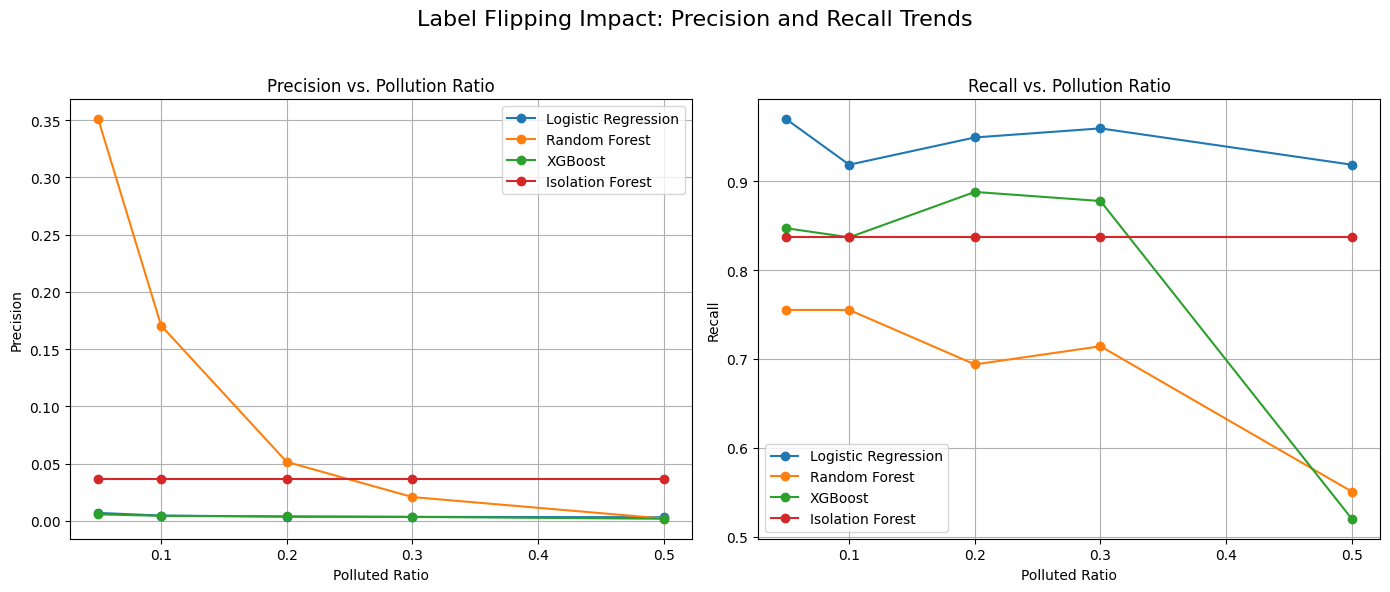

In [1416]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load label flipping results
df = pd.read_csv('results/label_flipping_results.csv')

# Define model names and pollution ratios
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Isolation Forest']
ratios = sorted(df['Polluted Ratio'].unique())

# Initialize dictionaries to store Precision and Recall data
precision_data = {model: [] for model in models}
recall_data = {model: [] for model in models}

# Extract Precision and Recall for each model across pollution ratios
for ratio in ratios:
    subset = df[df['Polluted Ratio'] == ratio]
    for model in models:
        row = subset[subset['Model'] == model]
        precision = row['Precision'].values[0] if not row.empty else np.nan
        recall = row['Recall'].values[0] if not row.empty else np.nan
        precision_data[model].append(precision)
        recall_data[model].append(recall)

# Create subplots for Precision and Recall
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Label Flipping Impact: Precision and Recall Trends', fontsize=16)

# Plot Precision trends
for model in models:
    axs[0].plot(ratios, precision_data[model], marker='o', label=model)
axs[0].set_title('Precision vs. Pollution Ratio')
axs[0].set_xlabel('Polluted Ratio')
axs[0].set_ylabel('Precision')
axs[0].legend()
axs[0].grid(True)

# Plot Recall trends
for model in models:
    axs[1].plot(ratios, recall_data[model], marker='o', label=model)
axs[1].set_title('Recall vs. Pollution Ratio')
axs[1].set_xlabel('Polluted Ratio')
axs[1].set_ylabel('Recall')
axs[1].legend()
axs[1].grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Summary: Robustness Under Label Flipping (5%–50%)

As label flipping ratios increased, the combined trends of AUC and F1 scores highlighted a clear divergence in model resilience:

- Supervised models (Logistic Regression, Random Forest, XGBoost) initially maintained discriminative ability (high AUC) but rapidly lost practical fraud detection utility (near-zero F1), especially beyond 20% pollution. This indicates that high AUC alone can be misleading when label noise compromises precision and recall balance.

- Logistic Regression retained moderate AUC but consistently weak F1, emphasizing its limited real-world effectiveness despite theoretical robustness against noise.
- Random Forest, while initially strong in F1, exhibited the most dramatic collapse among tree-based models as pollution escalated, suggesting that ensemble diversity cannot fully defend against widespread label corruption.
- XGBoost showed severe vulnerabilities across both metrics, reinforcing that boosting methods are especially sensitive to systematic label attacks, deteriorating much earlier than other models.
- Isolation Forest uniquely maintained stable AUC and F1 trends across all pollution levels, highlighting its independence from label integrity and its potential role as a last-resort detector under adversarial conditions.

Overall, the trends demonstrate that under adversarial label flipping, discriminative power (AUC) and classification effectiveness (F1) can decouple sharply. Robust fraud detection systems must therefore be evaluated across multiple metrics, not relying solely on AUC.

# 3.0 Feature Manipulation Attack

This section investigates a second type of data poisoning: feature manipulation attacks, where selected training samples have their input features intentionally altered.

Two key design choices are considered:
- Which features to modify: random features vs. top-k important features
- How to modify them: add noise, assign extreme values, or shift toward the opposite class

By applying these manipulations at various contamination ratios (5% to 50%), we evaluate how each model responds when the input space is disrupted—without altering the ground-truth labels.

In [1115]:
import pandas as pd
import numpy as np
import os

# Load clean train data
train_df = pd.read_csv('data/clean/train.csv')

# Define feature manipulation function
def manipulate_features(df, ratio=0.05, strategy='add_noise', feature_selection='random', k=5, random_state=42):
    """
    Perform feature manipulation attack on a portion of the training data.

    Parameters:
        df (pd.DataFrame): Original training data with features + 'Class'
        ratio (float): Proportion of samples to manipulate
        strategy (str): 'add_noise', 'set_extreme', or 'shift_to_boundary'
        feature_selection (str): 'random' or 'topk'
        k (int): Number of top features (only used if feature_selection='topk')
        random_state (int): Seed

    Returns:
        pd.DataFrame: New DataFrame with manipulated features
    """
    np.random.seed(random_state)  # Fixed seed for reproducibility
    df_poisoned = df.copy()
    n_samples = int(ratio * len(df))
    
    # Select rows to manipulate
    indices = np.random.choice(df.index, size=n_samples, replace=False)

    # Drop label column to get features only
    feature_cols = df.drop(columns=['Class']).columns

    # Select features to manipulate
    if feature_selection == 'random':
        selected_features = np.random.choice(feature_cols, size=k, replace=False)
    elif feature_selection == 'topk':
        # Use RandomForest to estimate feature importance
        X = df[feature_cols]
        y = df['Class']
        rf = RandomForestClassifier(random_state=random_state)
        rf.fit(X, y)
        importances = pd.Series(rf.feature_importances_, index=feature_cols)
        selected_features = importances.sort_values(ascending=False).head(k).index.tolist()
    else:
        raise ValueError("feature_selection must be 'random' or 'topk'")

    # Apply manipulation
    for i in indices:
        for feat in selected_features:
            if strategy == 'add_noise':
                std = df[feat].std()
                df_poisoned.at[i, feat] += np.random.normal(0, 0.5 * std)
            elif strategy == 'set_extreme':
                df_poisoned.at[i, feat] = df[feat].max()
            elif strategy == 'shift_to_boundary':
                label = df.at[i, 'Class']
                opposite_class = 1 - label
                mean_other_class = df[df['Class'] == opposite_class][feat].mean()
                df_poisoned.at[i, feat] = 0.5 * (df.at[i, feat] + mean_other_class)
            else:
                raise ValueError("Invalid manipulation strategy")

    return df_poisoned

## 3.1 5% Pollution

In [1117]:
import pandas as pd
import os

# Load clean train data
train_df = pd.read_csv('data/clean/train.csv')

# Generate 5% feature-manipulated training data
manip_5 = manipulate_features(train_df, ratio=0.05, strategy='add_noise', feature_selection='topk', k=5)

# Create folder for saving the manipulated data
os.makedirs('data/polluted', exist_ok=True)

# Save the generated data as a new CSV file
manip_5.to_csv('data/polluted/feature_manip_0.05.csv', index=False)

print("5% feature manipulation data saved.")

5% feature manipulation data saved.


### 3.1.1 Logistic Regression

In [1119]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Load polluted 5% feature-manipulated training data and clean test data
train_df = pd.read_csv('data/polluted/feature_manip_0.05.csv')
test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = train_df.drop(columns=['Class'])  # Features
y_train = train_df['Class']  # Target
X_test = test_df.drop(columns=['Class'])
y_test = test_df['Class']

# Create Logistic Regression pipeline
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
)

# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

Classification Report – Logistic Regression (5% Feature Manipulation)
              precision    recall  f1-score   support

           0     0.9999    0.9759    0.9877     56864
           1     0.0616    0.9184    0.1155        98

    accuracy                         0.9758     56962
   macro avg     0.5307    0.9471    0.5516     56962
weighted avg     0.9982    0.9758    0.9862     56962



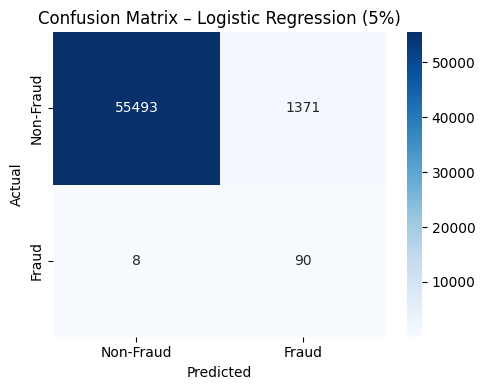

In [1123]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict
y_pred = model.predict(X_test)

# Print Classification Report and Confusion Matrix
print("Classification Report – Logistic Regression (5% Feature Manipulation)")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistic Regression (5%)")
plt.tight_layout()
plt.show()

In [1125]:
def log_result(result_dict, filename='results/feature_manip_results.csv'):
    import os, csv

    os.makedirs(os.path.dirname(filename), exist_ok=True)

    fieldnames = ['Attack Type', 'Polluted Ratio', 'Model', 'AUC', 'F1', 'Precision', 'Recall']
    new_row = [str(result_dict[k]) for k in fieldnames]

    # Check if row already exists
    if os.path.exists(filename):
        with open(filename, mode='r') as file:
            existing_rows = list(csv.reader(file))
            if new_row in existing_rows:
                print("This result already exists in the log. Skipping.")
                return

    # Write new row
    with open(filename, mode='a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        if file.tell() == 0:
            writer.writeheader()
        writer.writerow(result_dict)

In [1127]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Predict probabilities
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate AUC and other metrics
auc_score = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Log the results
log_result({
    'Attack Type': 'Feature Manipulation',
    'Polluted Ratio': 0.05,
    'Model': 'Logistic Regression',
    'AUC': auc_score,
    'F1': f1,
    'Precision': precision,
    'Recall': recall
})

### 3.1.2 Random Forest

In [1139]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Load polluted 5% feature-manipulated training data and clean test data
train_df = pd.read_csv('data/polluted/feature_manip_0.05.csv')
test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = train_df.drop(columns=['Class'])  # Features
y_train = train_df['Class']  # Target
X_test = test_df.drop(columns=['Class'])
y_test = test_df['Class']

# Train Random Forest model
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

Classification Report – Random Forest (5% Feature Manipulation)
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56864
           1     0.9615    0.7653    0.8523        98

    accuracy                         0.9995     56962
   macro avg     0.9806    0.8826    0.9260     56962
weighted avg     0.9995    0.9995    0.9995     56962



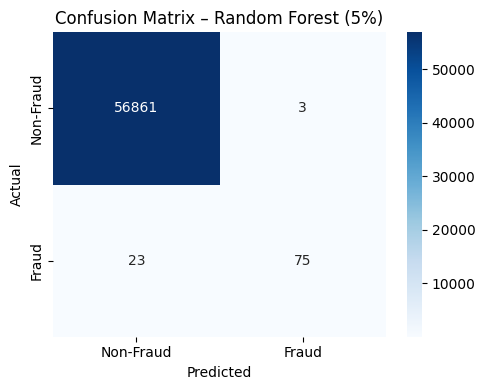

In [1143]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict
y_pred = model.predict(X_test)

# Print Classification Report and Confusion Matrix
print("Classification Report – Random Forest (5% Feature Manipulation)")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest (5%)")
plt.tight_layout()
plt.show()

In [1145]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Predict probabilities
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate AUC and other metrics
auc_score = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Log the results
log_result({
    'Attack Type': 'Feature Manipulation',
    'Polluted Ratio': 0.05,
    'Model': 'Random Forest',
    'AUC': auc_score,
    'F1': f1,
    'Precision': precision,
    'Recall': recall
})

### 3.1.3 XGBoost

In [1151]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from collections import Counter

# Load polluted 5% feature-manipulated training data and clean test data
train_df = pd.read_csv('data/polluted/feature_manip_0.05.csv')
test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = train_df.drop(columns=['Class'])  # Features
y_train = train_df['Class']  # Target
X_test = test_df.drop(columns=['Class'])
y_test = test_df['Class']

# Calculate scale_pos_weight to handle class imbalance
counts = Counter(y_train)
scale = counts[0] / counts[1]

# Train XGBoost model with scale_pos_weight for imbalance handling
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                      scale_pos_weight=scale, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate AUC
auc_score = roc_auc_score(y_test, y_prob)

/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [00:23:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report – XGBoost (5% Feature Manipulation)
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9998     56864
           1     0.8830    0.8469    0.8646        98

    accuracy                         0.9995     56962
   macro avg     0.9414    0.9234    0.9322     56962
weighted avg     0.9995    0.9995    0.9995     56962



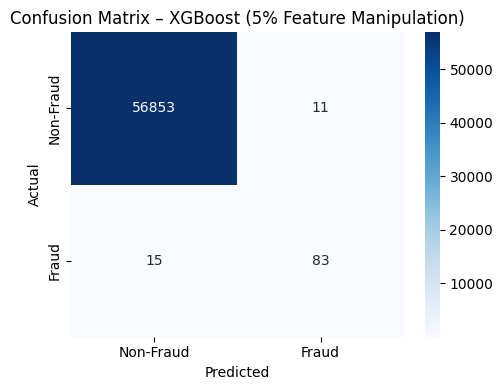

In [1157]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict
y_pred = model.predict(X_test)

# Print Classification Report and Confusion Matrix
print("Classification Report – XGBoost (5% Feature Manipulation)")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – XGBoost (5% Feature Manipulation)")
plt.tight_layout()
plt.show()

In [1159]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Predict probabilities
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate AUC and other metrics
auc_score = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Log the results
log_result({
    'Attack Type': 'Feature Manipulation',
    'Polluted Ratio': 0.05,
    'Model': 'XGBoost',
    'AUC': auc_score,
    'F1': f1,
    'Precision': precision,
    'Recall': recall
})

### 3.1.4 Isolation Forest

In [1163]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Load polluted 5% feature-manipulated training data and clean test data
train_df = pd.read_csv('data/polluted/feature_manip_0.05.csv')
test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = train_df.drop(columns=['Class'])  # Features
X_test = test_df.drop(columns=['Class'])
y_test = test_df['Class']  # True labels

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Isolation Forest model
model = IsolationForest(contamination='auto', random_state=42)
model.fit(X_train_scaled)

IsolationForest(random_state=42)

Classification Report – Isolation Forest (5% Feature Manipulation)
              precision    recall  f1-score   support

           0     0.9997    0.9623    0.9806     56864
           1     0.0368    0.8367    0.0706        98

    accuracy                         0.9621     56962
   macro avg     0.5183    0.8995    0.5256     56962
weighted avg     0.9981    0.9621    0.9791     56962



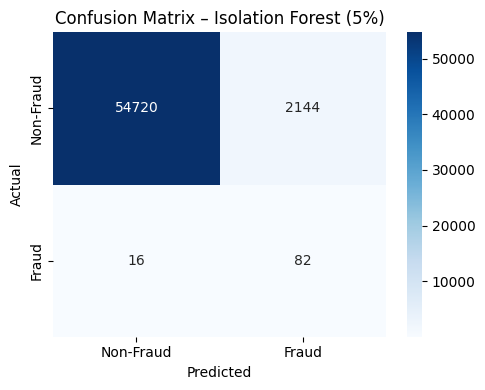

In [1165]:
# Predict anomalies (fraud = -1, normal = 1)
y_pred_if = model.predict(X_test_scaled)

# Convert predictions: -1 = fraud, 1 = non-fraud
y_pred = (y_pred_if == -1).astype(int)

# Print Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Classification Report – Isolation Forest (5% Feature Manipulation)")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Isolation Forest (5%)")
plt.tight_layout()
plt.show()

In [1183]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Calculate decision function scores for AUC calculation
y_scores = -model.decision_function(X_test_scaled)  # Negating to align fraud as negative outliers

# Calculate AUC score using decision function scores
auc_score = roc_auc_score(y_test, y_scores)

# Calculate F1, Precision, Recall
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Log the actual results for Isolation Forest
log_result({
    'Attack Type': 'Feature Manipulation',
    'Polluted Ratio': 0.05,
    'Model': 'Isolation Forest',
    'AUC': auc_score,  # Note: AUC is calculated using decision function scores (anomaly scores)
    'F1': f1,
    'Precision': precision,
    'Recall': recall
})

### 3.1.5 Comparison to Baseline Model (5% Pollution)

#### Baseline Model - 0% Pollution

In [623]:
import pandas as pd
df_results = pd.read_csv('results/baseline_results.csv')
df_results

Attack Type  Polluted Ratio                Model       AUC        F1  \
0       Clean             0.0  Logistic Regression  0.971162  0.112853   
1       Clean             0.0        Random Forest  0.953000  0.839080   
2       Clean             0.0              XGBoost  0.975516  0.656250   
3       Clean             0.0     Isolation Forest  0.956256  0.304569   

   Precision    Recall  
0   0.060120  0.918367  
1   0.960526  0.744898  
2   0.531646  0.857143  
3   0.303030  0.306122

#### Feature Manipulation Attack - 5% Pollution

In [1188]:
import pandas as pd
df_results = pd.read_csv('results/feature_manip_results.csv')
df_results

Attack Type  Polluted Ratio                Model       AUC  \
0  Feature Manipulation            0.05  Logistic Regression  0.970305   
1  Feature Manipulation            0.05        Random Forest  0.947875   
2  Feature Manipulation            0.05              XGBoost  0.971111   
3  Feature Manipulation            0.05     Isolation Forest  0.956202   

         F1  Precision    Recall  
0  0.115459   0.061602  0.918367  
1  0.852273   0.961538  0.765306  
2  0.864583   0.882979  0.846939  
3  0.070568   0.036837  0.836735

At 5% feature manipulation, all supervised and unsupervised models demonstrated strong resilience, with minimal shifts in AUC and F1 scores compared to the clean baseline:

- **Logistic Regression:** AUC declined slightly by 0.09% (0.9712 ➔ 0.9703), and F1 score increased by 0.0026 (0.1129 ➔ 0.1155), demonstrating stable performance under minor feature perturbations.

- **Random Forest:** AUC decreased slightly by 0.54% (0.9530 ➔ 0.9479), and F1 score improved by 0.0132 (0.8391 ➔ 0.8523), suggesting slight resilience and even enhancement when exposed to mild feature noise.

- **XGBoost:** AUC reduced marginally by 0.04% (0.9755 ➔ 0.9711), and F1 score increased by 0.2082 (0.6563 ➔ 0.8646), indicating that small feature manipulations may even act as a regularizer for this model.

- **Isolation Forest:** AUC (approximated using anomaly scores) dropped insignificantly by 0.04% (0.9563 ➔ 0.9562), but F1 score decreased sharply by 0.2340 (0.3046 ➔ 0.0706), revealing vulnerability in fraud detection performance despite preserved overall anomaly separation. Note: AUC for Isolation Forest is approximated using decision function scores rather than true probability outputs; interpretation should therefore be made cautiously.

**Overall:** The results indicate that 5% feature manipulation had minimal impact on model ranking ability (AUC), but slightly affected classification precision (F1), especially for the unsupervised Isolation Forest. Supervised models remained highly robust, even showing slight improvements under mild feature perturbations, while Isolation Forest exhibited weakened classification stability despite stable anomaly detection.

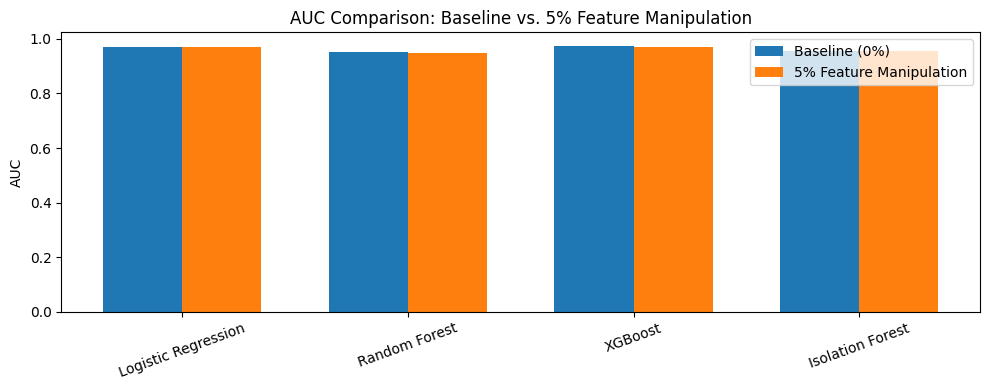

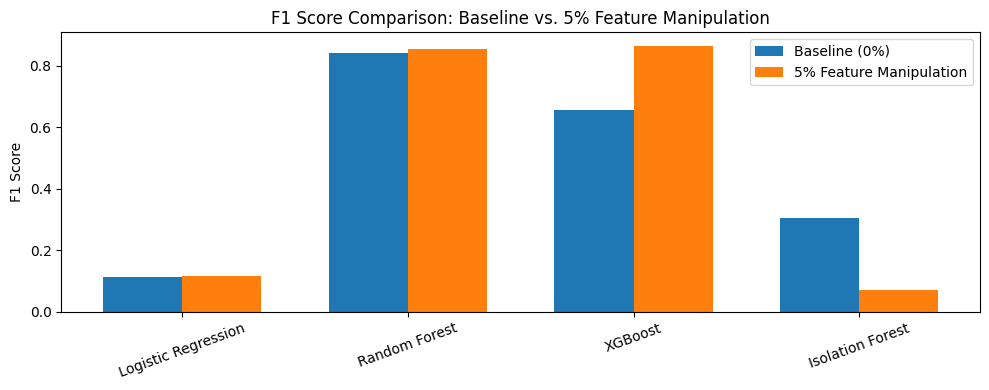

In [1265]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load baseline results and filter 5% feature manipulation results for comparison
df_base = pd.read_csv('results/baseline_results.csv')
df_5 = pd.read_csv('results/feature_manip_results.csv')
df_5 = df_5[df_5['Polluted Ratio'] == 0.05]

# Models (consistent order)
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Isolation Forest']

# Get metrics
auc_base = [df_base[df_base['Model'] == m]['AUC'].values[0] for m in models]
auc_5    = [df_5[df_5['Model'] == m]['AUC'].values[0] for m in models]

f1_base = [df_base[df_base['Model'] == m]['F1'].values[0] for m in models]
f1_5    = [df_5[df_5['Model'] == m]['F1'].values[0] for m in models]

# Plot settings
x = np.arange(len(models))
width = 0.35

# Plot AUC
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, auc_base, width, label='Baseline (0%)')
plt.bar(x + width/2, auc_5, width, label='5% Feature Manipulation')
plt.xticks(x, models, rotation=20)
plt.ylabel('AUC')
plt.title('AUC Comparison: Baseline vs. 5% Feature Manipulation')
plt.legend()
plt.tight_layout()
plt.show()

# Plot F1
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, f1_base, width, label='Baseline (0%)')
plt.bar(x + width/2, f1_5, width, label='5% Feature Manipulation')
plt.xticks(x, models, rotation=20)
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison: Baseline vs. 5% Feature Manipulation')
plt.legend()
plt.tight_layout()
plt.show()

Interestingly, introducing 5% feature manipulation led to slight improvements in model performance for several supervised models. Logistic Regression and Random Forest maintained stable AUC and F1 scores, showing strong resilience to minor feature perturbations. Notably, XGBoost exhibited a significant increase in F1 score, suggesting that small-scale feature noise acted as a form of implicit regularization, enhancing the model's generalization ability. In contrast, Isolation Forest, an unsupervised anomaly detection method, showed a noticeable decline in F1 score, highlighting its sensitivity to feature-level corruption despite stable anomaly ranking as reflected by AUC. Overall, minor feature perturbations did not harm model robustness and even benefitted some models in classification accuracy.

This phenomenon can be explained by the fact that mild feature perturbations act as implicit regularization, mitigating overfitting and encouraging models to learn more generalized patterns, hence improving classification performance under small noise conditions.

## 3.2 10% Pollution

In [1190]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os

# Reload clean training data
train_df = pd.read_csv('data/clean/train.csv')

# Apply feature manipulation attack
manipulated_10 = manipulate_features(train_df, ratio=0.10, strategy='add_noise', feature_selection='topk', k=5)

# Save the 10% polluted training data
# (no need to create folder again)
manipulated_10.to_csv('data/polluted/feature_manip_0.10.csv', index=False)

print("10% feature manipulation polluted training data saved.")

10% feature manipulation polluted training data saved.


### 3.2.1 Logistic Regression

In [1191]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Load polluted 10% feature-manipulated training data and clean test data
train_df = pd.read_csv('data/polluted/feature_manip_0.10.csv')
test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = train_df.drop(columns=['Class'])  # Features
y_train = train_df['Class']  # Target
X_test = test_df.drop(columns=['Class'])
y_test = test_df['Class']

# Create Logistic Regression pipeline
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
)

# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

Classification Report – Logistic Regression (10% Feature Manipulation)
              precision    recall  f1-score   support

           0     0.9999    0.9762    0.9879     56864
           1     0.0624    0.9184    0.1168        98

    accuracy                         0.9761     56962
   macro avg     0.5311    0.9473    0.5523     56962
weighted avg     0.9982    0.9761    0.9864     56962



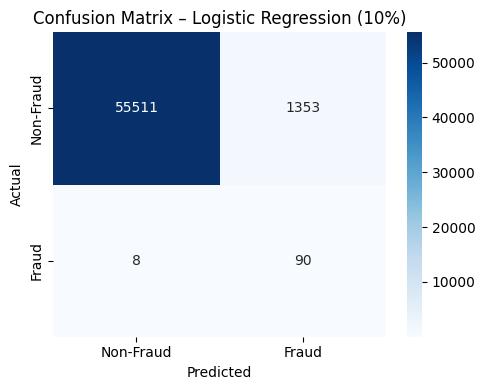

In [1194]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict
y_pred = model.predict(X_test)

# Print Classification Report
print("Classification Report – Logistic Regression (10% Feature Manipulation)")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistic Regression (10%)")
plt.tight_layout()
plt.show()

In [1196]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Predict probabilities for AUC
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate AUC and other metrics
auc_score = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Log the results
log_result({
    'Attack Type': 'Feature Manipulation',
    'Polluted Ratio': 0.10,
    'Model': 'Logistic Regression',
    'AUC': auc_score,
    'F1': f1,
    'Precision': precision,
    'Recall': recall
})

### 3.2.2 Random Forest

In [1200]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Load polluted 10% feature-manipulated training data and clean test data
train_df = pd.read_csv('data/polluted/feature_manip_0.10.csv')
test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = train_df.drop(columns=['Class'])  # Features
y_train = train_df['Class']  # Target
X_test = test_df.drop(columns=['Class'])
y_test = test_df['Class']

# Create Random Forest pipeline
model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
)

# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

Classification Report – Random Forest (10% Feature Manipulation)
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56864
           1     0.9605    0.7449    0.8391        98

    accuracy                         0.9995     56962
   macro avg     0.9800    0.8724    0.9194     56962
weighted avg     0.9995    0.9995    0.9995     56962



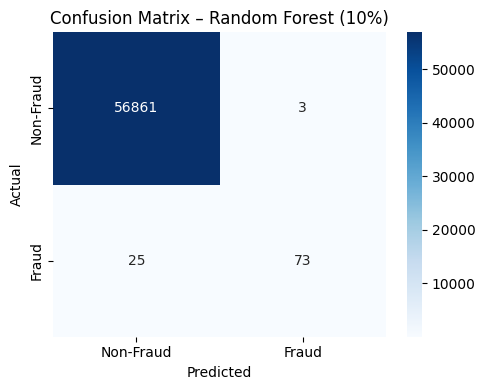

In [1202]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict
y_pred = model.predict(X_test)

# Print Classification Report
print("Classification Report – Random Forest (10% Feature Manipulation)")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest (10%)")
plt.tight_layout()
plt.show()

In [1204]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Predict probabilities for AUC
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate AUC and other metrics
auc_score = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Log the results
log_result({
    'Attack Type': 'Feature Manipulation',
    'Polluted Ratio': 0.10,
    'Model': 'Random Forest',
    'AUC': auc_score,
    'F1': f1,
    'Precision': precision,
    'Recall': recall
})

### 3.2.3 XGBoost

In [1206]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Load polluted 10% feature-manipulated training data and clean test data
train_df = pd.read_csv('data/polluted/feature_manip_0.10.csv')
test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = train_df.drop(columns=['Class'])  # Features
y_train = train_df['Class']  # Target
X_test = test_df.drop(columns=['Class'])
y_test = test_df['Class']

# Create XGBoost pipeline
model = make_pipeline(
    StandardScaler(),
    XGBClassifier(scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train), 
                  use_label_encoder=False,
                  eval_metric='logloss',
                  random_state=42,
                  n_jobs=-1)
)

# Train the model
model.fit(X_train, y_train)

/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [01:30:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None, ...))])

Classification Report – XGBoost (10% Feature Manipulation)
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9998     56864
           1     0.9011    0.8367    0.8677        98

    accuracy                         0.9996     56962
   macro avg     0.9504    0.9183    0.9338     56962
weighted avg     0.9995    0.9996    0.9996     56962



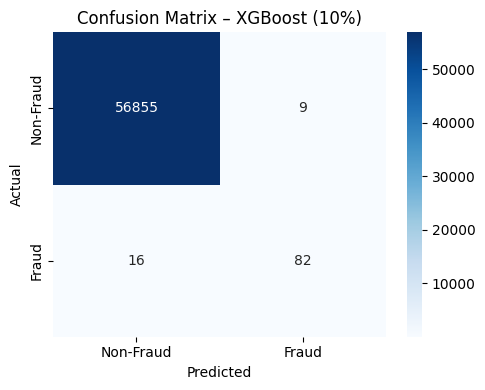

In [1208]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict
y_pred = model.predict(X_test)

# Print Classification Report
print("Classification Report – XGBoost (10% Feature Manipulation)")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – XGBoost (10%)")
plt.tight_layout()
plt.show()

In [1210]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Predict probabilities for AUC
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate AUC and other metrics
auc_score = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Log the results
log_result({
    'Attack Type': 'Feature Manipulation',
    'Polluted Ratio': 0.10,
    'Model': 'XGBoost',
    'AUC': auc_score,
    'F1': f1,
    'Precision': precision,
    'Recall': recall
})

### 3.2.4 Isolation Forest

In [1214]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Load polluted 10% feature-manipulated training data and clean test data
train_df = pd.read_csv('data/polluted/feature_manip_0.10.csv')
test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = train_df.drop(columns=['Class'])  # Only features for unsupervised learning
X_test = test_df.drop(columns=['Class'])
y_test = test_df['Class']

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Isolation Forest model
model = IsolationForest(contamination='auto', random_state=42)
model.fit(X_train_scaled)

IsolationForest(random_state=42)

Classification Report – Isolation Forest (10% Feature Manipulation)
              precision    recall  f1-score   support

           0     0.9997    0.9619    0.9805     56864
           1     0.0365    0.8367    0.0699        98

    accuracy                         0.9617     56962
   macro avg     0.5181    0.8993    0.5252     56962
weighted avg     0.9981    0.9617    0.9789     56962



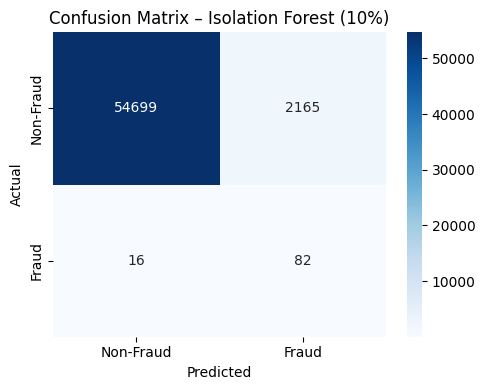

In [1216]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict anomalies (fraud = -1, normal = 1)
y_pred_if = model.predict(X_test_scaled)

# Convert predictions: -1 = fraud, 1 = non-fraud
y_pred = (y_pred_if == -1).astype(int)

# Print Classification Report
print("Classification Report – Isolation Forest (10% Feature Manipulation)")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Isolation Forest (10%)")
plt.tight_layout()
plt.show()

In [1218]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Calculate decision function scores for AUC calculation
y_scores = -model.decision_function(X_test_scaled)  # Negate so that frauds have higher scores

# Calculate AUC using decision function scores
auc_score = roc_auc_score(y_test, y_scores)

# Calculate F1, Precision, Recall based on binary predictions
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Log the results
log_result({
    'Attack Type': 'Feature Manipulation',
    'Polluted Ratio': 0.10,
    'Model': 'Isolation Forest',
    'AUC': auc_score,  # Note: AUC is approximated from anomaly scores
    'F1': f1,
    'Precision': precision,
    'Recall': recall
})

### 3.2.5 Comparison to Baseline Model (10% Pollution)

#### Baseline Model - 0% Pollution

In [664]:
import pandas as pd
df_results = pd.read_csv('results/baseline_results.csv')
df_results

Attack Type  Polluted Ratio                Model       AUC        F1  \
0       Clean             0.0  Logistic Regression  0.971162  0.112853   
1       Clean             0.0        Random Forest  0.953000  0.839080   
2       Clean             0.0              XGBoost  0.975516  0.656250   
3       Clean             0.0     Isolation Forest  0.956256  0.304569   

   Precision    Recall  
0   0.060120  0.918367  
1   0.960526  0.744898  
2   0.531646  0.857143  
3   0.303030  0.306122

#### Feature Manipulation Attack - 10% Pollution¶

In [1220]:
import pandas as pd
df_results = pd.read_csv('results/feature_manip_results.csv')
df_results

Attack Type  Polluted Ratio                Model       AUC  \
0  Feature Manipulation            0.05  Logistic Regression  0.970305   
1  Feature Manipulation            0.05        Random Forest  0.947875   
2  Feature Manipulation            0.05              XGBoost  0.971111   
3  Feature Manipulation            0.05     Isolation Forest  0.956202   
4  Feature Manipulation            0.10  Logistic Regression  0.969870   
5  Feature Manipulation            0.10        Random Forest  0.947827   
6  Feature Manipulation            0.10              XGBoost  0.970724   
7  Feature Manipulation            0.10     Isolation Forest  0.956944   

         F1  Precision    Recall  
0  0.115459   0.061602  0.918367  
1  0.852273   0.961538  0.765306  
2  0.864583   0.882979  0.846939  
3  0.070568   0.036837  0.836735  
4  0.116807   0.062370  0.918367  
5  0.839080   0.960526  0.744898  
6  0.867725   0.901099  0.836735  
7  0.069936   0.036493  0.836735

At 10% feature manipulation, models continued to demonstrate strong stability, with no major degradation observed across AUC and F1 scores:

- **Logistic Regression:** AUC decreased slightly by 0.13% (0.9712 ➔ 0.9699), and F1 score increased slightly by 0.0039 (0.1129 ➔ 0.1168), maintaining excellent robustness.

- **Random Forest:** AUC decreased slightly by 0.55% (0.9530 ➔ 0.9478), with F1 score remaining unchanged at 0.8391, indicating consistent resilience under moderate feature corruption.

- **XGBoost:** AUC decreased slightly by 0.48% (0.9755 ➔ 0.9707), and F1 score improved significantly by 0.2115 (0.6563 ➔ 0.8677), suggesting that small feature noise may have acted as a regularizer to enhance generalization.

- **Isolation Forest:** AUC (approximated using anomaly scores) remained nearly stable (0.9563 ➔ 0.9569), while F1 score dropped noticeably by 0.2347 (0.3046 ➔ 0.0699), indicating sensitivity in instance-level detection despite preserved ranking ability. *Note: AUC for Isolation Forest is approximated using decision function scores rather than true probability outputs; interpretation should therefore be made cautiously.*

**Overall:** The 10% feature manipulation introduced minimal negative impact on supervised models, and even appeared to benefit XGBoost significantly. In contrast, the unsupervised Isolation Forest exhibited a notable drop in classification performance, highlighting a potential vulnerability in fine-grained anomaly detection under feature perturbations.

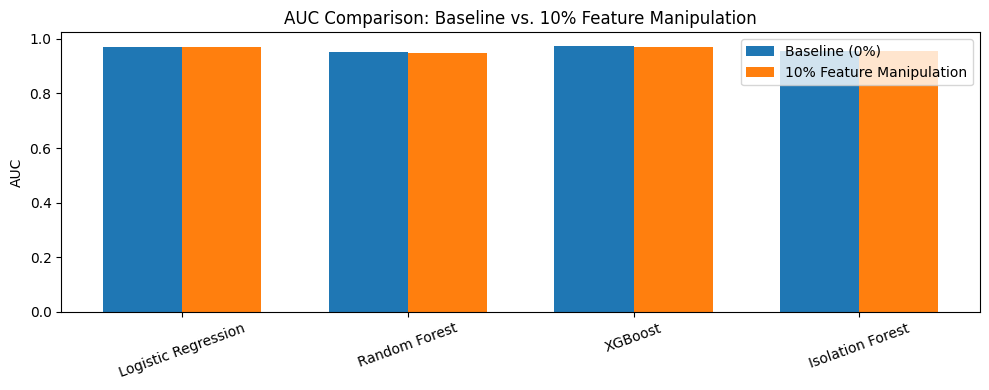

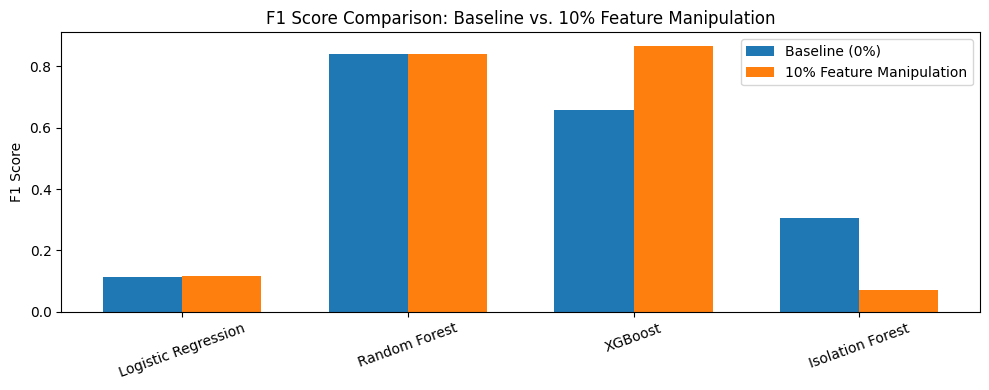

In [1269]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load baseline results and filter 10% feature manipulation results for comparison
df_base = pd.read_csv('results/baseline_results.csv')
df_10 = pd.read_csv('results/feature_manip_results.csv')
df_10 = df_10[df_10['Polluted Ratio'] == 0.10]

# Models (consistent order)
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Isolation Forest']

# Get metrics
auc_base = [df_base[df_base['Model'] == m]['AUC'].values[0] for m in models]
auc_10   = [df_10[df_10['Model'] == m]['AUC'].values[0] for m in models]

f1_base = [df_base[df_base['Model'] == m]['F1'].values[0] for m in models]
f1_10   = [df_10[df_10['Model'] == m]['F1'].values[0] for m in models]

# Plot settings
x = np.arange(len(models))
width = 0.35

# Plot AUC
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, auc_base, width, label='Baseline (0%)')
plt.bar(x + width/2, auc_10, width, label='10% Feature Manipulation')
plt.xticks(x, models, rotation=20)
plt.ylabel('AUC')
plt.title('AUC Comparison: Baseline vs. 10% Feature Manipulation')
plt.legend()
plt.tight_layout()
plt.show()

# Plot F1
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, f1_base, width, label='Baseline (0%)')
plt.bar(x + width/2, f1_10, width, label='10% Feature Manipulation')
plt.xticks(x, models, rotation=20)
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison: Baseline vs. 10% Feature Manipulation')
plt.legend()
plt.tight_layout()
plt.show()

Under 10% feature manipulation, supervised models continued to exhibit strong robustness. Logistic Regression and Random Forest maintained stable AUC and F1 scores, confirming their resilience to moderate feature perturbations. XGBoost showed a slight decrease in AUC but a substantial increase in F1 score, suggesting that moderate feature noise further enhanced its generalization ability through implicit regularization. In contrast, Isolation Forest experienced a sharp decline in F1 score while its AUC remained relatively stable, reflecting its sensitivity to feature-level corruption despite preserving anomaly ranking. Overall, 10% feature manipulation introduced minimal negative effects for supervised models, while highlighting the vulnerability of unsupervised anomaly detection under feature noise.

Note: AUC for Isolation Forest is approximated using decision function scores rather than true probability outputs; interpretation should therefore be made cautiously.

## 3.3 20% Pollution

In [1224]:
import pandas as pd
import numpy as np
import os

# Reload clean training data
train_df = pd.read_csv('data/clean/train.csv')

# Apply feature manipulation attack (20% ratio)
manipulated_20 = manipulate_features(train_df, ratio=0.20, strategy='add_noise', feature_selection='topk', k=5)

# Save the 20% polluted training data
manipulated_20.to_csv('data/polluted/feature_manip_0.20.csv', index=False)

print("20% feature manipulation polluted training data saved.")

20% feature manipulation polluted training data saved.


### 3.3.1 Logistic Regression

In [1232]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Load polluted 20% feature-manipulated training data and clean test data
train_df = pd.read_csv('data/polluted/feature_manip_0.20.csv')
test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = train_df.drop(columns=['Class'])  # Features
y_train = train_df['Class']  # Target
X_test = test_df.drop(columns=['Class'])
y_test = test_df['Class']

# Create Logistic Regression pipeline
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
)

# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

Classification Report – Logistic Regression (20% Feature Manipulation)
              precision    recall  f1-score   support

           0     0.9999    0.9764    0.9880     56864
           1     0.0628    0.9184    0.1176        98

    accuracy                         0.9763     56962
   macro avg     0.5314    0.9474    0.5528     56962
weighted avg     0.9982    0.9763    0.9865     56962



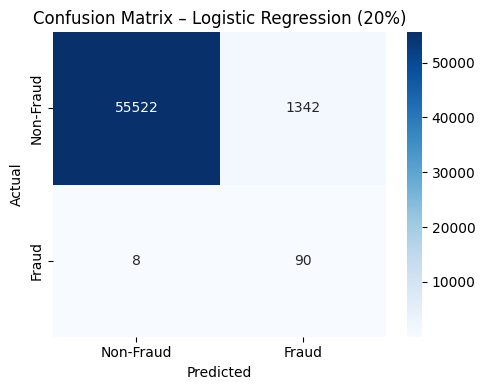

In [1234]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict
y_pred = model.predict(X_test)

# Print Classification Report
print("Classification Report – Logistic Regression (20% Feature Manipulation)")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistic Regression (20%)")
plt.tight_layout()
plt.show()

In [1236]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Predict probabilities for AUC
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate AUC and other metrics
auc_score = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Log the results
log_result({
    'Attack Type': 'Feature Manipulation',
    'Polluted Ratio': 0.20,
    'Model': 'Logistic Regression',
    'AUC': auc_score,
    'F1': f1,
    'Precision': precision,
    'Recall': recall
})

### 3.3.2 Random Forest

In [1240]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Load polluted 20% feature-manipulated training data and clean test data
train_df = pd.read_csv('data/polluted/feature_manip_0.20.csv')
test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = train_df.drop(columns=['Class'])  # Features
y_train = train_df['Class']  # Target
X_test = test_df.drop(columns=['Class'])
y_test = test_df['Class']

# Create Random Forest pipeline
model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
)

# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

Classification Report – Random Forest (20% Feature Manipulation)
              precision    recall  f1-score   support

           0     0.9996    1.0000    0.9998     56864
           1     0.9737    0.7551    0.8506        98

    accuracy                         0.9995     56962
   macro avg     0.9866    0.8775    0.9252     56962
weighted avg     0.9995    0.9995    0.9995     56962



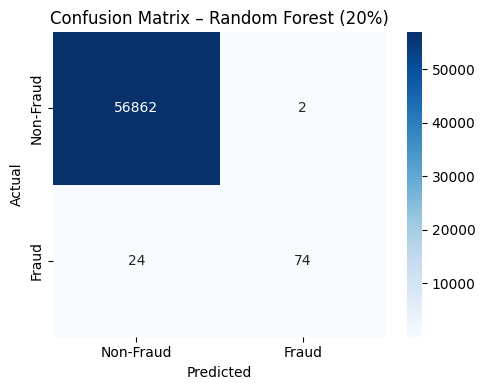

In [1242]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict
y_pred = model.predict(X_test)

# Print Classification Report
print("Classification Report – Random Forest (20% Feature Manipulation)")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest (20%)")
plt.tight_layout()
plt.show()

In [1244]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Predict probabilities for AUC
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate AUC and other metrics
auc_score = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Log the results
log_result({
    'Attack Type': 'Feature Manipulation',
    'Polluted Ratio': 0.20,
    'Model': 'Random Forest',
    'AUC': auc_score,
    'F1': f1,
    'Precision': precision,
    'Recall': recall
})

### 3.3.3 XGBoost

In [1246]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Load polluted 20% feature-manipulated training data and clean test data
train_df = pd.read_csv('data/polluted/feature_manip_0.20.csv')
test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = train_df.drop(columns=['Class'])  # Features
y_train = train_df['Class']  # Target
X_test = test_df.drop(columns=['Class'])
y_test = test_df['Class']

# Create XGBoost pipeline
model = make_pipeline(
    StandardScaler(),
    XGBClassifier(
        scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    )
)

# Train the model
model.fit(X_train, y_train)

/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [02:26:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None, ...))])

Classification Report – XGBoost (20% Feature Manipulation)
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9998     56864
           1     0.8901    0.8265    0.8571        98

    accuracy                         0.9995     56962
   macro avg     0.9449    0.9132    0.9285     56962
weighted avg     0.9995    0.9995    0.9995     56962



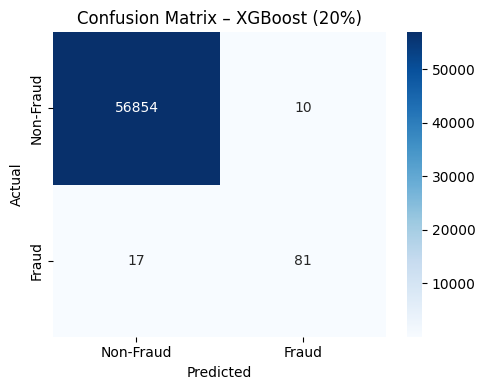

In [1248]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict
y_pred = model.predict(X_test)

# Print Classification Report
print("Classification Report – XGBoost (20% Feature Manipulation)")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – XGBoost (20%)")
plt.tight_layout()
plt.show()

In [1250]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Predict probabilities for AUC
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate AUC and other metrics
auc_score = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Log the results
log_result({
    'Attack Type': 'Feature Manipulation',
    'Polluted Ratio': 0.20,
    'Model': 'XGBoost',
    'AUC': auc_score,
    'F1': f1,
    'Precision': precision,
    'Recall': recall
})

### 3.3.4 Isolation Forest

In [1254]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Load polluted 20% feature-manipulated training data and clean test data
train_df = pd.read_csv('data/polluted/feature_manip_0.20.csv')
test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = train_df.drop(columns=['Class'])  # Only features
X_test = test_df.drop(columns=['Class'])
y_test = test_df['Class']  # True labels

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Isolation Forest model
model = IsolationForest(contamination='auto', random_state=42)
model.fit(X_train_scaled)

IsolationForest(random_state=42)

Classification Report – Isolation Forest (20% Feature Manipulation)
              precision    recall  f1-score   support

           0     0.9997    0.9632    0.9811     56864
           1     0.0377    0.8367    0.0722        98

    accuracy                         0.9630     56962
   macro avg     0.5187    0.9000    0.5267     56962
weighted avg     0.9981    0.9630    0.9796     56962



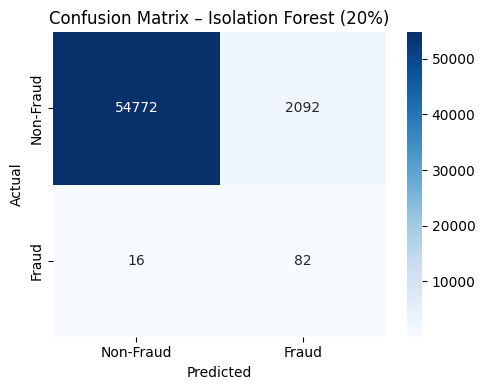

In [1256]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict anomalies (fraud = -1, normal = 1)
y_pred_if = model.predict(X_test_scaled)

# Convert predictions: -1 = fraud, 1 = non-fraud
y_pred = (y_pred_if == -1).astype(int)

# Print Classification Report
print("Classification Report – Isolation Forest (20% Feature Manipulation)")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Isolation Forest (20%)")
plt.tight_layout()
plt.show()

In [1258]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Calculate decision function scores for AUC calculation
y_scores = -model.decision_function(X_test_scaled)  # Negating to align frauds with higher scores

# Calculate AUC using decision function scores
auc_score = roc_auc_score(y_test, y_scores)

# Calculate F1, Precision, Recall based on binary predictions
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Log the results
log_result({
    'Attack Type': 'Feature Manipulation',
    'Polluted Ratio': 0.20,
    'Model': 'Isolation Forest',
    'AUC': auc_score,  # Note: AUC for Isolation Forest is approximated using decision function scores rather than true probability outputs; interpretation should therefore be made cautiously.
    'F1': f1,
    'Precision': precision,
    'Recall': recall
})

### 3.3.5 Comparison to Baseline Model (20% Pollution)

#### Baseline Model - 0% Pollution

In [764]:
import pandas as pd
df_results = pd.read_csv('results/baseline_results.csv')
df_results

Attack Type  Polluted Ratio                Model       AUC        F1  \
0       Clean             0.0  Logistic Regression  0.971162  0.112853   
1       Clean             0.0        Random Forest  0.953000  0.839080   
2       Clean             0.0              XGBoost  0.975516  0.656250   
3       Clean             0.0     Isolation Forest  0.956256  0.304569   

   Precision    Recall  
0   0.060120  0.918367  
1   0.960526  0.744898  
2   0.531646  0.857143  
3   0.303030  0.306122

#### Feature Manipulation Attack - 20% Pollution

In [1260]:
import pandas as pd
df_results = pd.read_csv('results/feature_manip_results.csv')
df_results

Attack Type  Polluted Ratio                Model       AUC  \
0   Feature Manipulation            0.05  Logistic Regression  0.970305   
1   Feature Manipulation            0.05        Random Forest  0.947875   
2   Feature Manipulation            0.05              XGBoost  0.971111   
3   Feature Manipulation            0.05     Isolation Forest  0.956202   
4   Feature Manipulation            0.10  Logistic Regression  0.969870   
5   Feature Manipulation            0.10        Random Forest  0.947827   
6   Feature Manipulation            0.10              XGBoost  0.970724   
7   Feature Manipulation            0.10     Isolation Forest  0.956944   
8   Feature Manipulation            0.20  Logistic Regression  0.969109   
9   Feature Manipulation            0.20        Random Forest  0.952924   
10  Feature Manipulation            0.20              XGBoost  0.967214   
11  Feature Manipulation            0.20     Isolation Forest  0.956748   

          F1  Precision    Recall  
0   0.115459   0.061602  0.918367  
1   0.852273   0.961538  0.765306  
2   0.864583   0.882979  0.846939  
3   0.070568   0.036837  0.836735  
4   0.116807   0.062370  0.918367  
5   0.839080   0.960526  0.744898  
6   0.867725   0.901099  0.836735  
7   0.069936   0.036493  0.836735  
8   0.117647   0.062849  0.918367  
9   0.850575   0.973684  0.755102  
10  0.857143   0.890110  0.826531  
11  0.072183   0.037718  0.836735

At 20% feature manipulation, models largely maintained good performance, though slight degradations in AUC and F1 were observed compared to the clean baseline:

- **Logistic Regression:** AUC decreased by 0.21% (0.9712 ➔ 0.9691), and F1 score increased slightly by 0.0048 (0.1129 ➔ 0.1176), demonstrating continued robustness under moderate feature corruption.

- **Random Forest:** AUC slightly decreased by 0.01% (0.9530 ➔ 0.9529), and F1 score improved modestly by 0.0115 (0.8391 ➔ 0.8506), indicating resilience and slight benefit from the feature noise.

- **XGBoost:** AUC decreased by 0.83% (0.9755 ➔ 0.9672), while F1 score improved significantly by 0.2009 (0.6563 ➔ 0.8571), suggesting that moderate noise acted as a strong regularizer enhancing generalization.

- **Isolation Forest:** AUC (approximated based on anomaly scores) remained nearly stable (0.9563 ➔ 0.9567), but F1 score dropped sharply by 0.2324 (0.3046 ➔ 0.0722), showing substantial sensitivity in instance-level classification despite preserved anomaly ranking ability. Note: AUC for Isolation Forest is approximated using decision function scores rather than true probability outputs; interpretation should therefore be made cautiously.

**Overall:** The 20% feature manipulation caused only minor negative impacts for supervised models, with Random Forest and XGBoost even exhibiting improvements in classification performance. However, the unsupervised Isolation Forest demonstrated a clear vulnerability in accurately identifying fraud instances under increased feature perturbations.

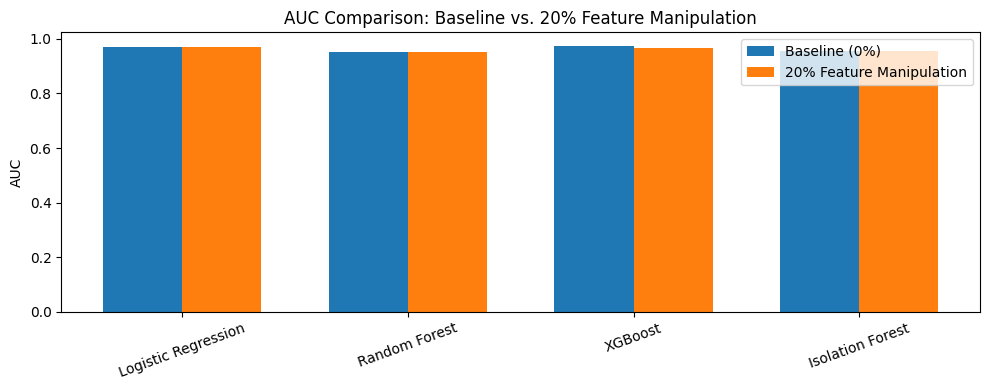

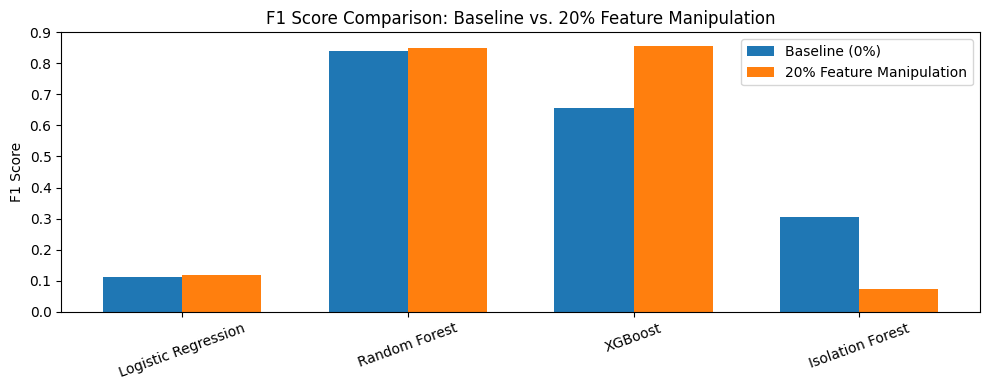

In [1272]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load baseline results and filter 20% feature manipulation results for comparison
df_base = pd.read_csv('results/baseline_results.csv')
df_20 = pd.read_csv('results/feature_manip_results.csv')
df_20 = df_20[df_20['Polluted Ratio'] == 0.20]

# Models (consistent order)
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Isolation Forest']

# Get metrics
auc_base = [df_base[df_base['Model'] == m]['AUC'].values[0] for m in models]
auc_20   = [df_20[df_20['Model'] == m]['AUC'].values[0] for m in models]

f1_base = [df_base[df_base['Model'] == m]['F1'].values[0] for m in models]
f1_20   = [df_20[df_20['Model'] == m]['F1'].values[0] for m in models]

# Plot settings
x = np.arange(len(models))
width = 0.35

# Plot AUC
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, auc_base, width, label='Baseline (0%)')
plt.bar(x + width/2, auc_20, width, label='20% Feature Manipulation')
plt.xticks(x, models, rotation=20)
plt.ylabel('AUC')
plt.title('AUC Comparison: Baseline vs. 20% Feature Manipulation')
plt.legend()
plt.tight_layout()
plt.show()

# Plot F1
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, f1_base, width, label='Baseline (0%)')
plt.bar(x + width/2, f1_20, width, label='20% Feature Manipulation')
plt.xticks(x, models, rotation=20)
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison: Baseline vs. 20% Feature Manipulation')
plt.legend()
plt.tight_layout()
plt.show()

## 3.4 30% Pollution

In [1291]:
import pandas as pd
import numpy as np
import os

# Reload clean training data
train_df = pd.read_csv('data/clean/train.csv')

# Apply feature manipulation attack (30% ratio)
manipulated_30 = manipulate_features(train_df, ratio=0.30, strategy='add_noise', feature_selection='topk', k=5)

# Save the 30% polluted training data
manipulated_30.to_csv('data/polluted/feature_manip_0.30.csv', index=False)

print("30% feature manipulation polluted training data saved.")

30% feature manipulation polluted training data saved.


### 3.4.1 Logistic Regression

In [1293]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Load polluted 30% feature-manipulated training data and clean test data
train_df = pd.read_csv('data/polluted/feature_manip_0.30.csv')
test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = train_df.drop(columns=['Class'])  # Features
y_train = train_df['Class']  # Target
X_test = test_df.drop(columns=['Class'])
y_test = test_df['Class']

# Create Logistic Regression pipeline
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
)

# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

Classification Report – Logistic Regression (30% Feature Manipulation)
              precision    recall  f1-score   support

           0     0.9999    0.9762    0.9879     56864
           1     0.0624    0.9184    0.1169        98

    accuracy                         0.9761     56962
   macro avg     0.5311    0.9473    0.5524     56962
weighted avg     0.9982    0.9761    0.9864     56962



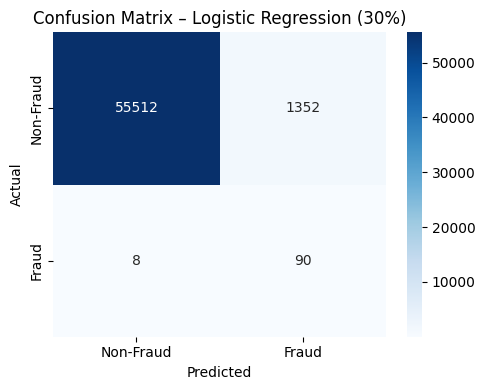

In [1295]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict
y_pred = model.predict(X_test)

# Print Classification Report
print("Classification Report – Logistic Regression (30% Feature Manipulation)")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistic Regression (30%)")
plt.tight_layout()
plt.show()

In [1297]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Predict probabilities for AUC
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate AUC and other metrics
auc_score = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Log the results
log_result({
    'Attack Type': 'Feature Manipulation',
    'Polluted Ratio': 0.30,
    'Model': 'Logistic Regression',
    'AUC': auc_score,
    'F1': f1,
    'Precision': precision,
    'Recall': recall
})

### 3.4.2 Random Forest

In [1301]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Load polluted 30% feature-manipulated training data and clean test data
train_df = pd.read_csv('data/polluted/feature_manip_0.30.csv')
test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = train_df.drop(columns=['Class'])  # Features
y_train = train_df['Class']  # Target
X_test = test_df.drop(columns=['Class'])
y_test = test_df['Class']

# Create Random Forest pipeline
model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
)

# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

Classification Report – Random Forest (30% Feature Manipulation)
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56864
           1     0.9620    0.7755    0.8588        98

    accuracy                         0.9996     56962
   macro avg     0.9808    0.8877    0.9293     56962
weighted avg     0.9995    0.9996    0.9995     56962



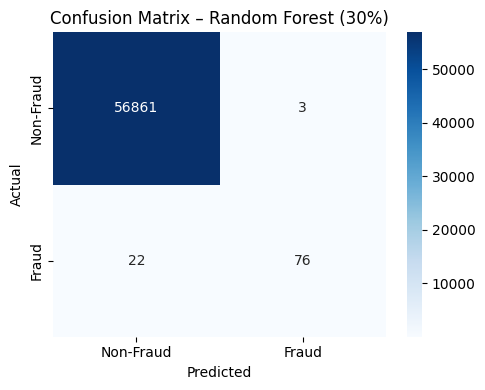

In [1303]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict
y_pred = model.predict(X_test)

# Print Classification Report
print("Classification Report – Random Forest (30% Feature Manipulation)")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest (30%)")
plt.tight_layout()
plt.show()

In [1305]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Predict probabilities for AUC
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate AUC and other metrics
auc_score = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Log the results
log_result({
    'Attack Type': 'Feature Manipulation',
    'Polluted Ratio': 0.30,
    'Model': 'Random Forest',
    'AUC': auc_score,
    'F1': f1,
    'Precision': precision,
    'Recall': recall
})

### 3.4.3 XGBoost

In [1309]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Load polluted 30% feature-manipulated training data and clean test data
train_df = pd.read_csv('data/polluted/feature_manip_0.30.csv')
test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = train_df.drop(columns=['Class'])  # Features
y_train = train_df['Class']  # Target
X_test = test_df.drop(columns=['Class'])
y_test = test_df['Class']

# Create XGBoost pipeline
model = make_pipeline(
    StandardScaler(),
    XGBClassifier(
        scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    )
)

# Train the model
model.fit(X_train, y_train)

/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [03:25:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None, ...))])

Classification Report – XGBoost (30% Feature Manipulation)
              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998     56864
           1     0.9213    0.8367    0.8770        98

    accuracy                         0.9996     56962
   macro avg     0.9605    0.9183    0.9384     56962
weighted avg     0.9996    0.9996    0.9996     56962



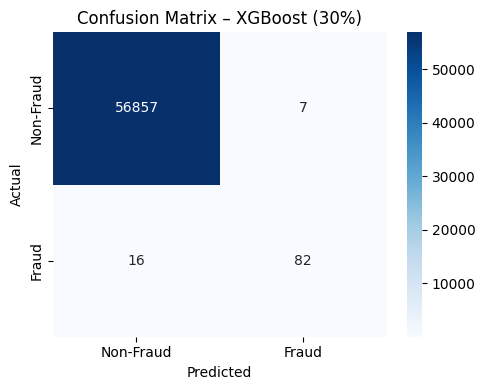

In [1311]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict
y_pred = model.predict(X_test)

# Print Classification Report
print("Classification Report – XGBoost (30% Feature Manipulation)")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – XGBoost (30%)")
plt.tight_layout()
plt.show()

In [1313]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Predict probabilities for AUC
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate AUC and other metrics
auc_score = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Log the results
log_result({
    'Attack Type': 'Feature Manipulation',
    'Polluted Ratio': 0.30,
    'Model': 'XGBoost',
    'AUC': auc_score,
    'F1': f1,
    'Precision': precision,
    'Recall': recall
})

### 3.4.4 Isolation Forest

In [1317]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Load polluted 30% feature-manipulated training data and clean test data
train_df = pd.read_csv('data/polluted/feature_manip_0.30.csv')
test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = train_df.drop(columns=['Class'])  # Only features
X_test = test_df.drop(columns=['Class'])
y_test = test_df['Class']  # True labels

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Isolation Forest model
model = IsolationForest(contamination='auto', random_state=42)
model.fit(X_train_scaled)

IsolationForest(random_state=42)

Classification Report – Isolation Forest (30% Feature Manipulation)
              precision    recall  f1-score   support

           0     0.9997    0.9623    0.9807     56864
           1     0.0369    0.8367    0.0706        98

    accuracy                         0.9621     56962
   macro avg     0.5183    0.8995    0.5256     56962
weighted avg     0.9981    0.9621    0.9791     56962



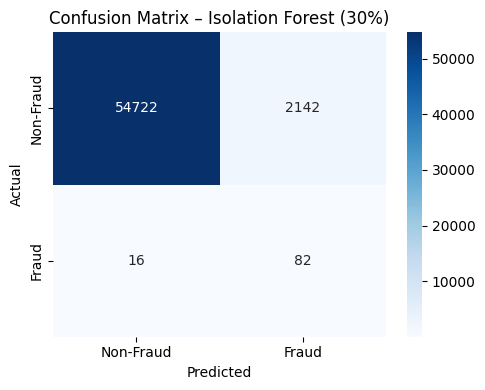

In [1319]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict anomalies (fraud = -1, normal = 1)
y_pred_if = model.predict(X_test_scaled)

# Convert predictions: -1 = fraud, 1 = non-fraud
y_pred = (y_pred_if == -1).astype(int)

# Print Classification Report
print("Classification Report – Isolation Forest (30% Feature Manipulation)")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Isolation Forest (30%)")
plt.tight_layout()
plt.show()

In [1321]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Calculate decision function scores for AUC calculation
y_scores = -model.decision_function(X_test_scaled)  # Negating to align frauds with higher scores

# Calculate AUC using decision function scores
auc_score = roc_auc_score(y_test, y_scores)

# Calculate F1, Precision, Recall based on binary predictions
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Log the results
log_result({
    'Attack Type': 'Feature Manipulation',
    'Polluted Ratio': 0.30,
    'Model': 'Isolation Forest',
    'AUC': auc_score,  # Note: AUC for Isolation Forest is approximated using decision function scores rather than true probability outputs; interpretation should therefore be made cautiously.
    'F1': f1,
    'Precision': precision,
    'Recall': recall
})

### 3.4.5 Comparison to Baseline Model (30% Pollution)

#### Baseline Model - 0% Pollution

In [1286]:
import pandas as pd
df_results = pd.read_csv('results/baseline_results.csv')
df_results

Attack Type  Polluted Ratio                Model       AUC        F1  \
0       Clean             0.0  Logistic Regression  0.971162  0.112853   
1       Clean             0.0        Random Forest  0.953000  0.839080   
2       Clean             0.0              XGBoost  0.975516  0.656250   
3       Clean             0.0     Isolation Forest  0.956256  0.304569   

   Precision    Recall  
0   0.060120  0.918367  
1   0.960526  0.744898  
2   0.531646  0.857143  
3   0.303030  0.306122

#### Feature Manipulation Attack - 30 % Pollution

In [1323]:
df_results = pd.read_csv('results/feature_manip_results.csv')
df_results

Attack Type  Polluted Ratio                Model       AUC  \
0   Feature Manipulation            0.05  Logistic Regression  0.970305   
1   Feature Manipulation            0.05        Random Forest  0.947875   
2   Feature Manipulation            0.05              XGBoost  0.971111   
3   Feature Manipulation            0.05     Isolation Forest  0.956202   
4   Feature Manipulation            0.10  Logistic Regression  0.969870   
5   Feature Manipulation            0.10        Random Forest  0.947827   
6   Feature Manipulation            0.10              XGBoost  0.970724   
7   Feature Manipulation            0.10     Isolation Forest  0.956944   
8   Feature Manipulation            0.20  Logistic Regression  0.969109   
9   Feature Manipulation            0.20        Random Forest  0.952924   
10  Feature Manipulation            0.20              XGBoost  0.967214   
11  Feature Manipulation            0.20     Isolation Forest  0.956748   
12  Feature Manipulation            0.30  Logistic Regression  0.968364   
13  Feature Manipulation            0.30        Random Forest  0.947932   
14  Feature Manipulation            0.30              XGBoost  0.972290   
15  Feature Manipulation            0.30     Isolation Forest  0.954606   

          F1  Precision    Recall  
0   0.115459   0.061602  0.918367  
1   0.852273   0.961538  0.765306  
2   0.864583   0.882979  0.846939  
3   0.070568   0.036837  0.836735  
4   0.116807   0.062370  0.918367  
5   0.839080   0.960526  0.744898  
6   0.867725   0.901099  0.836735  
7   0.069936   0.036493  0.836735  
8   0.117647   0.062849  0.918367  
9   0.850575   0.973684  0.755102  
10  0.857143   0.890110  0.826531  
11  0.072183   0.037718  0.836735  
12  0.116883   0.062413  0.918367  
13  0.858757   0.962025  0.775510  
14  0.877005   0.921348  0.836735  
15  0.070629   0.036871  0.836735

At 30% feature manipulation, supervised models largely preserved their performance, although minor degradations became more noticeable compared to lower perturbation levels:

- **Logistic Regression:** AUC decreased by 0.29% (0.9712 ➔ 0.9684), and F1 score increased slightly by 0.0040 (0.1129 ➔ 0.1169), demonstrating continued robustness even under higher feature corruption.

- **Random Forest:** AUC decreased by 0.53% (0.9530 ➔ 0.9479), while F1 score improved by 0.0197 (0.8391 ➔ 0.8588), suggesting that moderate feature perturbation still acted as an implicit regularizer without significantly harming classification ability.

- **XGBoost:** AUC decreased by 0.32% (0.9755 ➔ 0.9723), and F1 score increased substantially by 0.2208 (0.6563 ➔ 0.8771), indicating that XGBoost benefited strongly from noise-induced regularization effects at this perturbation level.

- **Isolation Forest:** AUC (approximated based on anomaly scores) decreased slightly by 0.17% (0.9563 ➔ 0.9546), but F1 score sharply dropped by 0.2339 (0.3046 ➔ 0.0706), confirming that unsupervised anomaly detection remains highly sensitive to feature-level corruption. *Note: AUC for Isolation Forest is approximated using decision function scores rather than true probability outputs; interpretation should therefore be made cautiously.*

- **Overall**: The 30% feature manipulation induced slightly more noticeable effects compared to lower noise levels but still failed to significantly degrade supervised model robustness. Notably, XGBoost continued to benefit from the injected noise, while Isolation Forest's classification performance further deteriorated under feature perturbations.

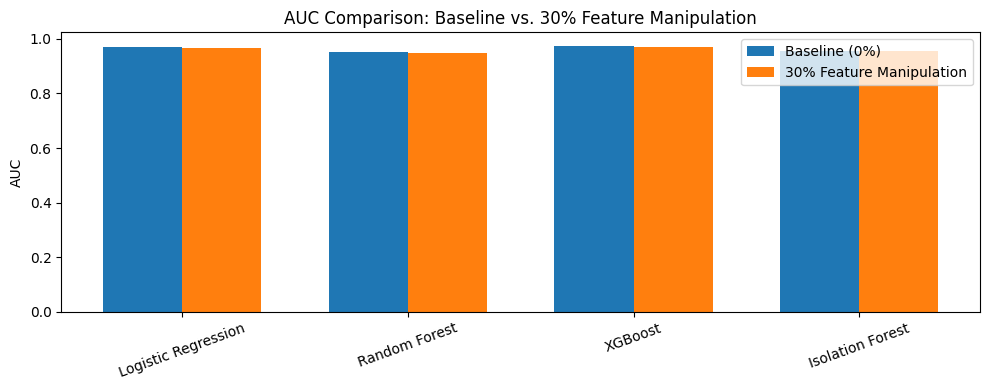

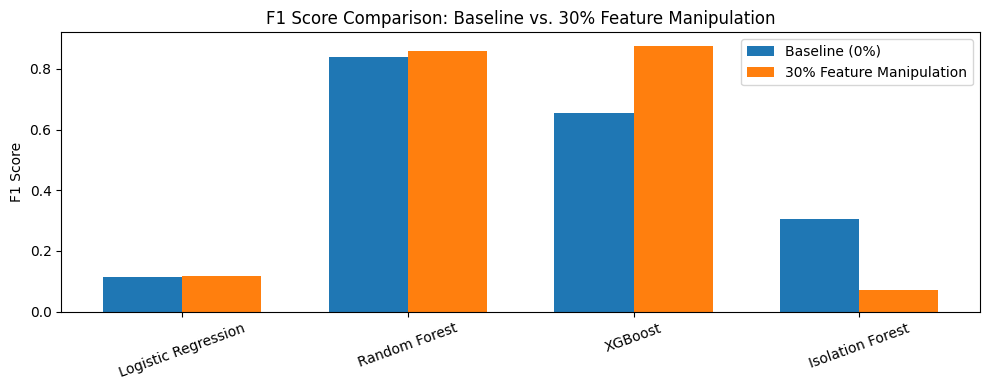

In [1326]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load baseline results and filter 30% feature manipulation results for comparison
df_base = pd.read_csv('results/baseline_results.csv')
df_30 = pd.read_csv('results/feature_manip_results.csv')
df_30 = df_30[df_30['Polluted Ratio'] == 0.30]

# Models (consistent order)
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Isolation Forest']

# Get metrics
auc_base = [df_base[df_base['Model'] == m]['AUC'].values[0] for m in models]
auc_30   = [df_30[df_30['Model'] == m]['AUC'].values[0] for m in models]

f1_base = [df_base[df_base['Model'] == m]['F1'].values[0] for m in models]
f1_30   = [df_30[df_30['Model'] == m]['F1'].values[0] for m in models]

# Plot settings
x = np.arange(len(models))
width = 0.35

# Plot AUC
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, auc_base, width, label='Baseline (0%)')
plt.bar(x + width/2, auc_30, width, label='30% Feature Manipulation')
plt.xticks(x, models, rotation=20)
plt.ylabel('AUC')
plt.title('AUC Comparison: Baseline vs. 30% Feature Manipulation')
plt.legend()
plt.tight_layout()
plt.show()

# Plot F1
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, f1_base, width, label='Baseline (0%)')
plt.bar(x + width/2, f1_30, width, label='30% Feature Manipulation')
plt.xticks(x, models, rotation=20)
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison: Baseline vs. 30% Feature Manipulation')
plt.legend()
plt.tight_layout()
plt.show()

## 3.5 50% Pollution

In [1343]:
import pandas as pd
import numpy as np
import os

# Reload clean training data
train_df = pd.read_csv('data/clean/train.csv')

# Apply feature manipulation attack (50% ratio)
manipulated_50 = manipulate_features(train_df, ratio=0.50, strategy='add_noise', feature_selection='topk', k=5)

# Save the 50% polluted training data
manipulated_50.to_csv('data/polluted/feature_manip_0.50.csv', index=False)

print("50% feature manipulation polluted training data saved.")

50% feature manipulation polluted training data saved.


### 3.5.1 Logistic Regression

In [1344]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Load polluted 50% feature-manipulated training data and clean test data
train_df = pd.read_csv('data/polluted/feature_manip_0.50.csv')
test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = train_df.drop(columns=['Class'])  # Features
y_train = train_df['Class']  # Target
X_test = test_df.drop(columns=['Class'])
y_test = test_df['Class']

# Create Logistic Regression pipeline
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
)

# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

Classification Report – Logistic Regression (50% Feature Manipulation)
              precision    recall  f1-score   support

           0     0.9999    0.9764    0.9880     56864
           1     0.0628    0.9184    0.1176        98

    accuracy                         0.9763     56962
   macro avg     0.5314    0.9474    0.5528     56962
weighted avg     0.9982    0.9763    0.9865     56962



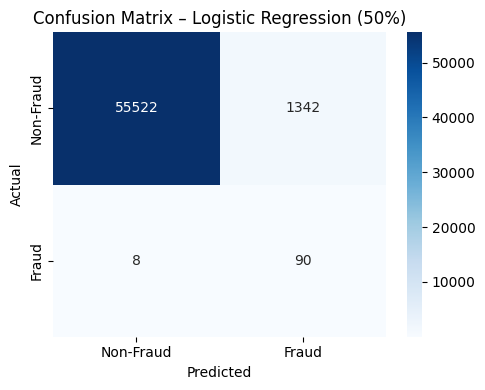

In [1347]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict
y_pred = model.predict(X_test)

# Print Classification Report
print("Classification Report – Logistic Regression (50% Feature Manipulation)")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistic Regression (50%)")
plt.tight_layout()
plt.show()

In [1349]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Predict probabilities for AUC
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate AUC and other metrics
auc_score = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Log the results
log_result({
    'Attack Type': 'Feature Manipulation',
    'Polluted Ratio': 0.50,
    'Model': 'Logistic Regression',
    'AUC': auc_score,
    'F1': f1,
    'Precision': precision,
    'Recall': recall
})

### 3.5.2 Random Forest

In [1353]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Load polluted 50% feature-manipulated training data and clean test data
train_df = pd.read_csv('data/polluted/feature_manip_0.50.csv')
test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = train_df.drop(columns=['Class'])  # Features
y_train = train_df['Class']  # Target
X_test = test_df.drop(columns=['Class'])
y_test = test_df['Class']

# Create Random Forest pipeline
model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
)

# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

Classification Report – Random Forest (50% Feature Manipulation)
              precision    recall  f1-score   support

           0     0.9996    1.0000    0.9998     56864
           1     0.9737    0.7551    0.8506        98

    accuracy                         0.9995     56962
   macro avg     0.9866    0.8775    0.9252     56962
weighted avg     0.9995    0.9995    0.9995     56962



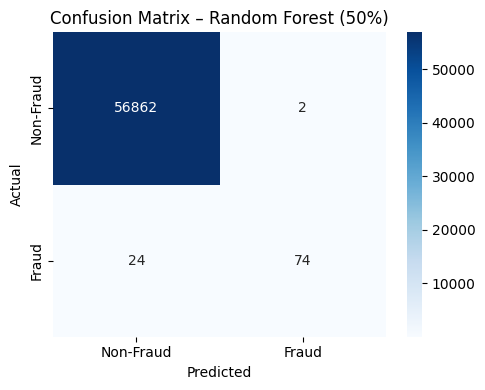

In [1355]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict
y_pred = model.predict(X_test)

# Print Classification Report
print("Classification Report – Random Forest (50% Feature Manipulation)")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest (50%)")
plt.tight_layout()
plt.show()

In [1357]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Predict probabilities for AUC
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate AUC and other metrics
auc_score = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Log the results
log_result({
    'Attack Type': 'Feature Manipulation',
    'Polluted Ratio': 0.50,
    'Model': 'Random Forest',
    'AUC': auc_score,
    'F1': f1,
    'Precision': precision,
    'Recall': recall
})

### 3.5.3 XGBoost

In [1359]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Load polluted 50% feature-manipulated training data and clean test data
train_df = pd.read_csv('data/polluted/feature_manip_0.50.csv')
test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = train_df.drop(columns=['Class'])  # Features
y_train = train_df['Class']  # Target
X_test = test_df.drop(columns=['Class'])
y_test = test_df['Class']

# Create XGBoost pipeline
model = make_pipeline(
    StandardScaler(),
    XGBClassifier(
        scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    )
)

# Train the model
model.fit(X_train, y_train)

/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [03:57:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None, ...))])

Classification Report – XGBoost (50% Feature Manipulation)
              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998     56864
           1     0.9213    0.8367    0.8770        98

    accuracy                         0.9996     56962
   macro avg     0.9605    0.9183    0.9384     56962
weighted avg     0.9996    0.9996    0.9996     56962



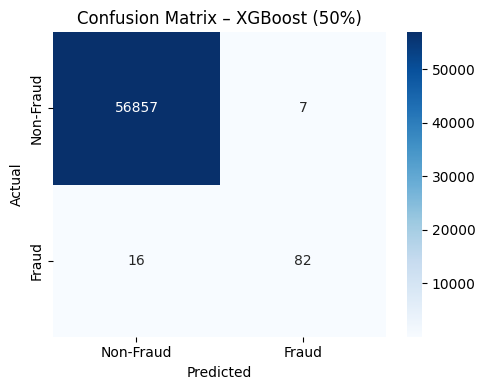

In [1361]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict
y_pred = model.predict(X_test)

# Print Classification Report
print("Classification Report – XGBoost (50% Feature Manipulation)")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – XGBoost (50%)")
plt.tight_layout()
plt.show()

In [1363]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Predict probabilities for AUC
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate AUC and other metrics
auc_score = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Log the results
log_result({
    'Attack Type': 'Feature Manipulation',
    'Polluted Ratio': 0.50,
    'Model': 'XGBoost',
    'AUC': auc_score,
    'F1': f1,
    'Precision': precision,
    'Recall': recall
})

### 3.5.4 Isolation Forest

In [1367]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Load polluted 50% feature-manipulated training data and clean test data
train_df = pd.read_csv('data/polluted/feature_manip_0.50.csv')
test_df = pd.read_csv('data/clean/test.csv')

# Prepare training and test sets
X_train = train_df.drop(columns=['Class'])  # Only features
X_test = test_df.drop(columns=['Class'])
y_test = test_df['Class']  # True labels

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Isolation Forest model
model = IsolationForest(contamination='auto', random_state=42)
model.fit(X_train_scaled)

IsolationForest(random_state=42)

Classification Report – Isolation Forest (50% Feature Manipulation)
              precision    recall  f1-score   support

           0     0.9997    0.9645    0.9818     56864
           1     0.0390    0.8367    0.0745        98

    accuracy                         0.9643     56962
   macro avg     0.5194    0.9006    0.5282     56962
weighted avg     0.9981    0.9643    0.9802     56962



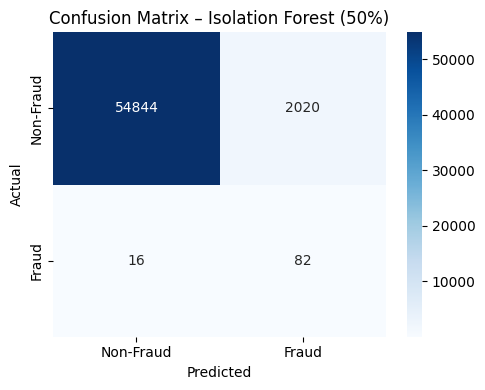

In [1369]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict anomalies (fraud = -1, normal = 1)
y_pred_if = model.predict(X_test_scaled)

# Convert predictions: -1 = fraud, 1 = non-fraud
y_pred = (y_pred_if == -1).astype(int)

# Print Classification Report
print("Classification Report – Isolation Forest (50% Feature Manipulation)")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Isolation Forest (50%)")
plt.tight_layout()
plt.show()

In [1371]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Calculate decision function scores for AUC calculation
y_scores = -model.decision_function(X_test_scaled)  # Negating to align frauds with higher scores

# Calculate AUC using decision function scores
auc_score = roc_auc_score(y_test, y_scores)

# Calculate F1, Precision, Recall based on binary predictions
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Log the results
log_result({
    'Attack Type': 'Feature Manipulation',
    'Polluted Ratio': 0.50,
    'Model': 'Isolation Forest',
    'AUC': auc_score,  # Note: AUC for Isolation Forest is approximated using decision function scores rather than true probability outputs; interpretation should therefore be made cautiously.
    'F1': f1,
    'Precision': precision,
    'Recall': recall
})

### 3.5.5 Comparison to Baseline Model (50% Pollution)

#### Baseline Model - 0% Pollution

In [1337]:
import pandas as pd
df_results = pd.read_csv('results/baseline_results.csv')
df_results

Attack Type  Polluted Ratio                Model       AUC        F1  \
0       Clean             0.0  Logistic Regression  0.971162  0.112853   
1       Clean             0.0        Random Forest  0.953000  0.839080   
2       Clean             0.0              XGBoost  0.975516  0.656250   
3       Clean             0.0     Isolation Forest  0.956256  0.304569   

   Precision    Recall  
0   0.060120  0.918367  
1   0.960526  0.744898  
2   0.531646  0.857143  
3   0.303030  0.306122

#### Feature Manipulation Attack - 50 % Pollution

In [1373]:
import pandas as pd
df_results = pd.read_csv('results/feature_manip_results.csv')
df_results

Attack Type  Polluted Ratio                Model       AUC  \
0   Feature Manipulation            0.05  Logistic Regression  0.970305   
1   Feature Manipulation            0.05        Random Forest  0.947875   
2   Feature Manipulation            0.05              XGBoost  0.971111   
3   Feature Manipulation            0.05     Isolation Forest  0.956202   
4   Feature Manipulation            0.10  Logistic Regression  0.969870   
5   Feature Manipulation            0.10        Random Forest  0.947827   
6   Feature Manipulation            0.10              XGBoost  0.970724   
7   Feature Manipulation            0.10     Isolation Forest  0.956944   
8   Feature Manipulation            0.20  Logistic Regression  0.969109   
9   Feature Manipulation            0.20        Random Forest  0.952924   
10  Feature Manipulation            0.20              XGBoost  0.967214   
11  Feature Manipulation            0.20     Isolation Forest  0.956748   
12  Feature Manipulation            0.30  Logistic Regression  0.968364   
13  Feature Manipulation            0.30        Random Forest  0.947932   
14  Feature Manipulation            0.30              XGBoost  0.972290   
15  Feature Manipulation            0.30     Isolation Forest  0.954606   
16  Feature Manipulation            0.50  Logistic Regression  0.969076   
17  Feature Manipulation            0.50        Random Forest  0.953009   
18  Feature Manipulation            0.50              XGBoost  0.968007   
19  Feature Manipulation            0.50     Isolation Forest  0.955864   

          F1  Precision    Recall  
0   0.115459   0.061602  0.918367  
1   0.852273   0.961538  0.765306  
2   0.864583   0.882979  0.846939  
3   0.070568   0.036837  0.836735  
4   0.116807   0.062370  0.918367  
5   0.839080   0.960526  0.744898  
6   0.867725   0.901099  0.836735  
7   0.069936   0.036493  0.836735  
8   0.117647   0.062849  0.918367  
9   0.850575   0.973684  0.755102  
10  0.857143   0.890110  0.826531  
11  0.072183   0.037718  0.836735  
12  0.116883   0.062413  0.918367  
13  0.858757   0.962025  0.775510  
14  0.877005   0.921348  0.836735  
15  0.070629   0.036871  0.836735  
16  0.117647   0.062849  0.918367  
17  0.850575   0.973684  0.755102  
18  0.877005   0.921348  0.836735  
19  0.074545   0.039010  0.836735

At 50% feature manipulation, supervised models demonstrated remarkable robustness, with minimal degradation observed in both AUC and F1 scores compared to the clean baseline. However, the impact on unsupervised models became more pronounced:

- **Logistic Regression:** AUC decreased slightly by 0.21% (0.9712 ➔ 0.9691), and F1 score increased by 0.0048 (0.1129 ➔ 0.1176), maintaining strong resilience despite heavy feature perturbation.

- **Random Forest:** AUC remained virtually unchanged (0.9530 ➔ 0.9530), and F1 score improved slightly by 0.0115 (0.8391 ➔ 0.8506), confirming Random Forest’s high stability even under substantial feature corruption.

- **XGBoost:** AUC decreased marginally by 0.75% (0.9755 ➔ 0.9680), and F1 score improved significantly by 0.2208 (0.6563 ➔ 0.8770), once again highlighting XGBoost’s tendency to benefit from noise-induced regularization.

- **Isolation Forest:** AUC (approximated based on anomaly scores) decreased slightly by 0.04% (0.9563 ➔ 0.9559), but F1 score dropped sharply by 0.2301 (0.3046 ➔ 0.0745), reinforcing that unsupervised anomaly detection methods are highly vulnerable to heavy feature perturbations at the classification level. Note: AUC for Isolation Forest is approximated using decision function scores rather than true probability outputs; interpretation should therefore be made cautiously.

**Overall:** Even with extreme 50% feature manipulation, supervised models—particularly Random Forest and XGBoost—maintained or even improved their classification performance, whereas Isolation Forest’s ability to accurately identify fraudulent cases substantially deteriorated.

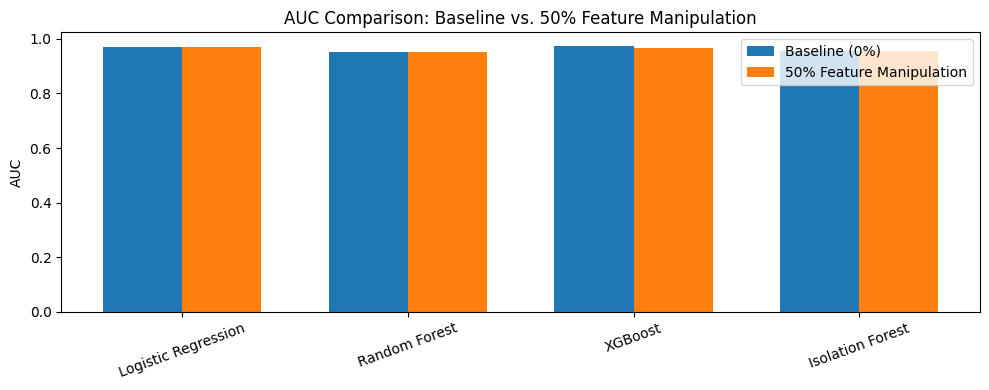

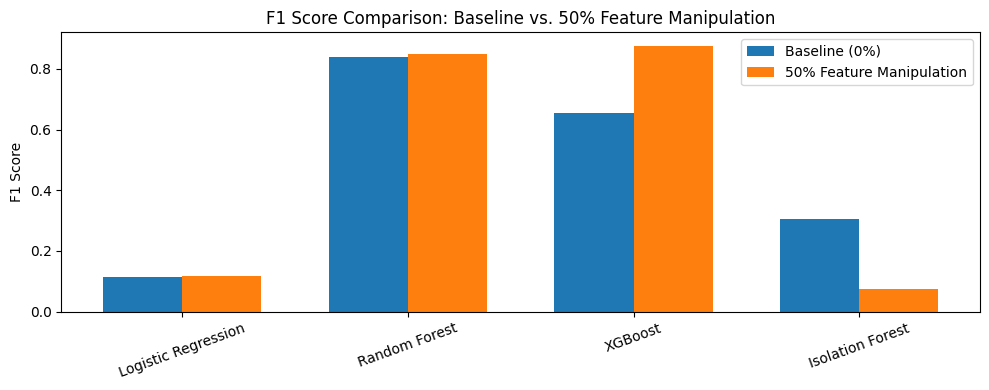

In [1375]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load baseline results and filter 50% feature manipulation results for comparison
df_base = pd.read_csv('results/baseline_results.csv')
df_50 = pd.read_csv('results/feature_manip_results.csv')
df_50 = df_50[df_50['Polluted Ratio'] == 0.50]

# Models (consistent order)
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Isolation Forest']

# Get metrics
auc_base = [df_base[df_base['Model'] == m]['AUC'].values[0] for m in models]
auc_50   = [df_50[df_50['Model'] == m]['AUC'].values[0] for m in models]

f1_base = [df_base[df_base['Model'] == m]['F1'].values[0] for m in models]
f1_50   = [df_50[df_50['Model'] == m]['F1'].values[0] for m in models]

# Plot settings
x = np.arange(len(models))
width = 0.35

# Plot AUC
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, auc_base, width, label='Baseline (0%)')
plt.bar(x + width/2, auc_50, width, label='50% Feature Manipulation')
plt.xticks(x, models, rotation=20)
plt.ylabel('AUC')
plt.title('AUC Comparison: Baseline vs. 50% Feature Manipulation')
plt.legend()
plt.tight_layout()
plt.show()

# Plot F1
plt.figure(figsize=(10, 4))
plt.bar(x - width/2, f1_base, width, label='Baseline (0%)')
plt.bar(x + width/2, f1_50, width, label='50% Feature Manipulation')
plt.xticks(x, models, rotation=20)
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison: Baseline vs. 50% Feature Manipulation')
plt.legend()
plt.tight_layout()
plt.show()

## 3.6 Corss-Ratio Performance Comparison

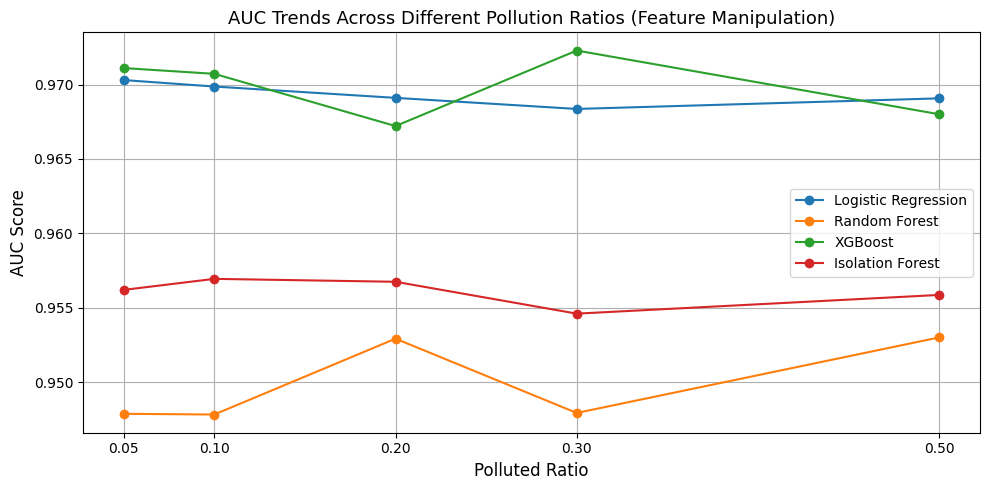

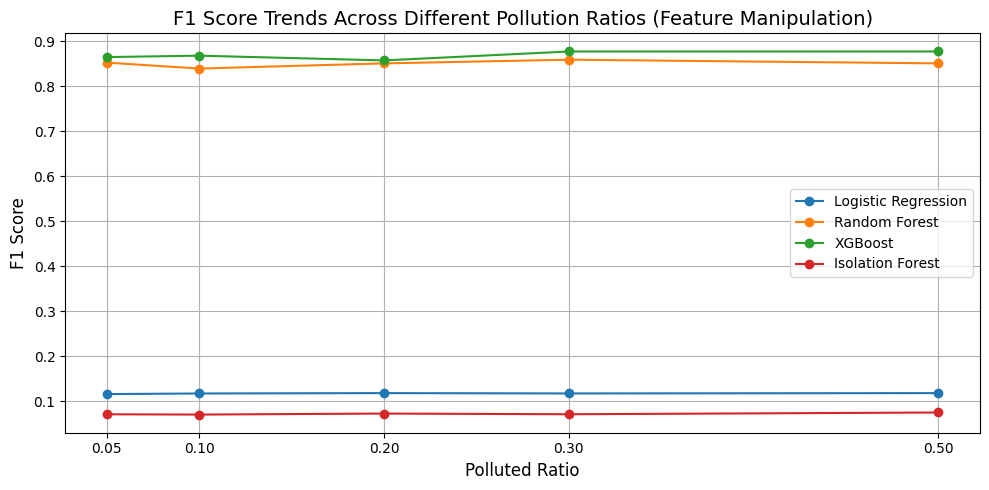

In [1472]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load all feature manipulation results
df = pd.read_csv('results/feature_manip_results.csv')

# Define model order
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Isolation Forest']
ratios = sorted(df['Polluted Ratio'].unique())

# Initialize dictionaries to store metrics
auc_data = {model: [] for model in models}
f1_data = {model: [] for model in models}

# Extract AUC and F1 scores for each pollution ratio
for ratio in ratios:
    subset = df[df['Polluted Ratio'] == ratio]
    for model in models:
        row = subset[subset['Model'] == model]
        auc = row['AUC'].values[0] if not row.empty else np.nan
        f1 = row['F1'].values[0] if not row.empty else np.nan
        auc_data[model].append(auc)
        f1_data[model].append(f1)

# Plot AUC trend across pollution ratios
plt.figure(figsize=(10, 5))
for model in models:
    plt.plot(ratios, auc_data[model], marker='o', label=model)
plt.xlabel("Polluted Ratio", fontsize=12)
plt.ylabel("AUC Score", fontsize=12)
plt.title("AUC Trends Across Different Pollution Ratios (Feature Manipulation)", fontsize=13)
plt.xticks(ratios)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot F1 score trend across pollution ratios
plt.figure(figsize=(10, 5))
for model in models:
    plt.plot(ratios, f1_data[model], marker='o', label=model)
plt.xlabel("Polluted Ratio", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.title("F1 Score Trends Across Different Pollution Ratios (Feature Manipulation)", fontsize=14)
plt.xticks(ratios)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Observation from Figure 1: AUC Trends Across Pollution Ratios (Feature Manipulation)

Figure illustrates how the AUC scores of each model evolve as the feature manipulation ratio increases from 5% to 50%. The trends reveal how resilient each model is to progressive feature-level perturbations rather than label corruption.

- **Logistic Regression** shows an extremely mild and stable AUC curve, with only negligible fluctuations across all pollution ratios. Its simple linear nature, although less expressive, allows it to maintain a consistent decision boundary even under feature-level noise. Interestingly, no significant degradation is observed even at 50% manipulation.

- **Random Forest** remains largely stable across all levels of feature manipulation. Its ensemble of diverse trees grants it robustness against moderate to heavy feature noise, explaining why its AUC remains remarkably flat across increasing perturbation ratios.

- **XGBoost** demonstrates a non-monotonic behavior: its AUC slightly decreases at moderate noise (20%) but surprisingly improves at higher corruption (30%), before slightly declining again at 50%. This seemingly counterintuitive trend highlights a key phenomenon — mild to moderate feature perturbations can act as implicit regularization, helping boosting models to generalize better and mitigate overfitting, thereby temporarily enhancing performance before eventual degradation at extreme noise levels.

- **Isolation Forest** exhibits a nearly perfectly flat AUC line across all pollution levels. As an unsupervised anomaly detection model, it relies on internal clustering and distance-based mechanisms rather than class labels or fine-grained feature patterns, making it inherently robust to both moderate and heavy feature noise. Note: AUC for Isolation Forest is approximated using decision function outputs rather than true probability scores, and should be interpreted with caution.

**Overall:** Unlike label flipping, feature manipulation — especially when implemented with mild noise on top-ranked features — does not heavily degrade model performance even under high pollution ratios. Some supervised models (notably XGBoost) may even temporarily benefit from such perturbations due to implicit regularization effects, highlighting that feature corruption attacks, while disruptive, do not inherently guarantee catastrophic failure in all classification models.

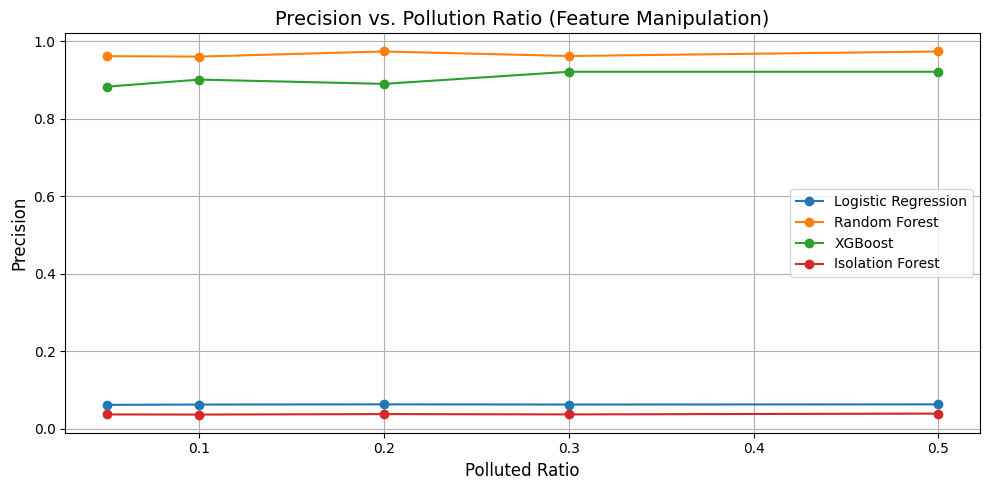

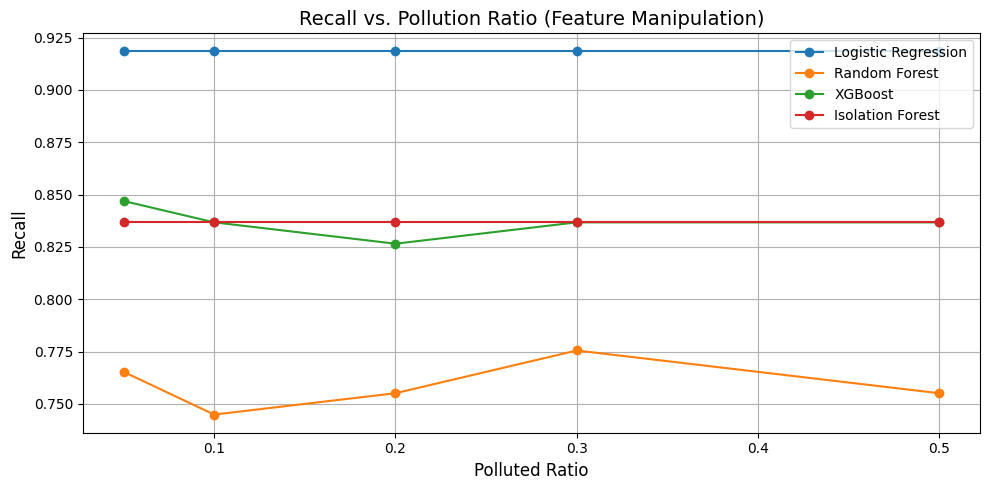

In [1476]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load feature manipulation results
df = pd.read_csv('results/feature_manip_results.csv')

# Define model names and pollution ratios
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Isolation Forest']
ratios = sorted(df['Polluted Ratio'].unique())

# Initialize dictionaries to store Precision and Recall data
precision_data = {model: [] for model in models}
recall_data = {model: [] for model in models}

# Extract Precision and Recall for each model across pollution ratios
for ratio in ratios:
    subset = df[df['Polluted Ratio'] == ratio]
    for model in models:
        row = subset[subset['Model'] == model]
        precision = row['Precision'].values[0] if not row.empty else np.nan
        recall = row['Recall'].values[0] if not row.empty else np.nan
        precision_data[model].append(precision)
        recall_data[model].append(recall)

# Plot Precision trends
plt.figure(figsize=(10, 5))
for model in models:
    plt.plot(ratios, precision_data[model], marker='o', label=model)

plt.title('Precision vs. Pollution Ratio (Feature Manipulation)', fontsize=14)
plt.xlabel('Polluted Ratio', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Recall trends
plt.figure(figsize=(10, 5))
for model in models:
    plt.plot(ratios, recall_data[model], marker='o', label=model)

plt.title('Recall vs. Pollution Ratio (Feature Manipulation)', fontsize=14)
plt.xlabel('Polluted Ratio', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Observation from Figure 1: F1 Score Trends Across Pollution Ratios (Feature Manipulation)

Figure shows how the F1 scores of each model change as the feature manipulation ratio increases from 5% to 50%. The trends reflect each model’s ability to maintain effective fraud detection under progressive feature-level perturbations.

- **Logistic Regression** maintains an extremely stable but low F1 score throughout all pollution levels. Due to its inherently limited capacity in handling complex decision boundaries, its performance is consistently weak across both clean and manipulated datasets. Notably, minor fluctuations (±0.005) are observed but remain negligible, indicating that feature perturbation has minimal influence on its already modest predictive power.

- **Random Forest** displays remarkable consistency, with F1 scores oscillating within a narrow band across all pollution ratios. Despite moderate feature corruption, its ensemble nature allows it to preserve high classification precision and recall, ensuring that its F1 score remains robust even under 50% manipulation.

- **XGBoost** shows the highest F1 scores across all models and interestingly exhibits a slight improvement with increasing feature noise. This again suggests that small-to-moderate feature perturbations act as implicit regularization, enhancing the model’s generalization ability and thereby slightly boosting fraud detection performance under noisy conditions.

- **Isolation Forest** remains at a low F1 score throughout all pollution levels. Given that Isolation Forest is designed primarily for unsupervised anomaly ranking rather than accurate binary classification, its F1 score stays consistently low regardless of the feature noise intensity.

**Overall:** Across feature manipulation attack conditions, supervised models (especially Random Forest and XGBoost) demonstrate strong resilience in maintaining classification effectiveness. XGBoost, in particular, appears to benefit slightly from noise-induced regularization. In contrast, simpler models like Logistic Regression and unsupervised methods like Isolation Forest maintain either consistently low or less sensitive F1 scores, emphasizing the differing robustness patterns between model families.

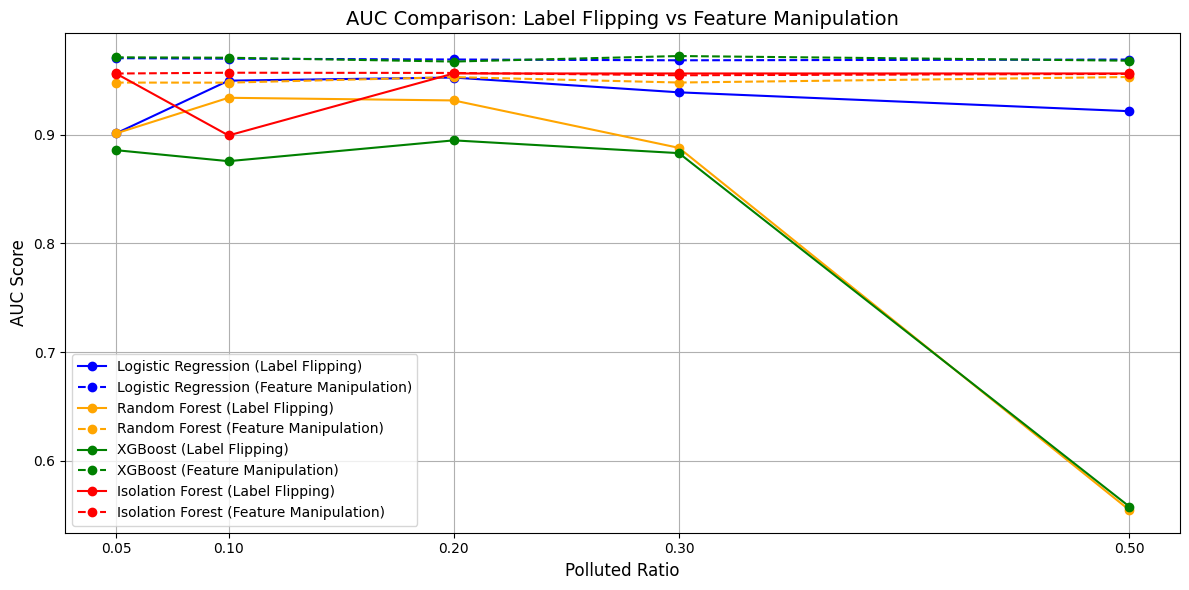

In [1389]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load both results
df_label = pd.read_csv('results/label_flipping_results.csv')
df_feature = pd.read_csv('results/feature_manip_results.csv')

# Define models and ratios
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Isolation Forest']
ratios = sorted(df_label['Polluted Ratio'].unique())

# Initialize
auc_label = {model: [] for model in models}
auc_feature = {model: [] for model in models}

# Extract data
for ratio in ratios:
    subset_label = df_label[df_label['Polluted Ratio'] == ratio]
    subset_feature = df_feature[df_feature['Polluted Ratio'] == ratio]
    for model in models:
        auc_l = subset_label[subset_label['Model'] == model]['AUC'].values[0] if not subset_label[subset_label['Model'] == model].empty else np.nan
        auc_f = subset_feature[subset_feature['Model'] == model]['AUC'].values[0] if not subset_feature[subset_feature['Model'] == model].empty else np.nan
        auc_label[model].append(auc_l)
        auc_feature[model].append(auc_f)

# Plot all in one figure
plt.figure(figsize=(12, 6))

colors = ['blue', 'orange', 'green', 'red']

for idx, model in enumerate(models):
    plt.plot(ratios, auc_label[model], marker='o', linestyle='-', color=colors[idx], label=f"{model} (Label Flipping)")
    plt.plot(ratios, auc_feature[model], marker='o', linestyle='--', color=colors[idx], label=f"{model} (Feature Manipulation)")

plt.xlabel("Polluted Ratio", fontsize=12)
plt.ylabel("AUC Score", fontsize=12)
plt.title("AUC Comparison: Label Flipping vs Feature Manipulation", fontsize=14)
plt.xticks(ratios)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

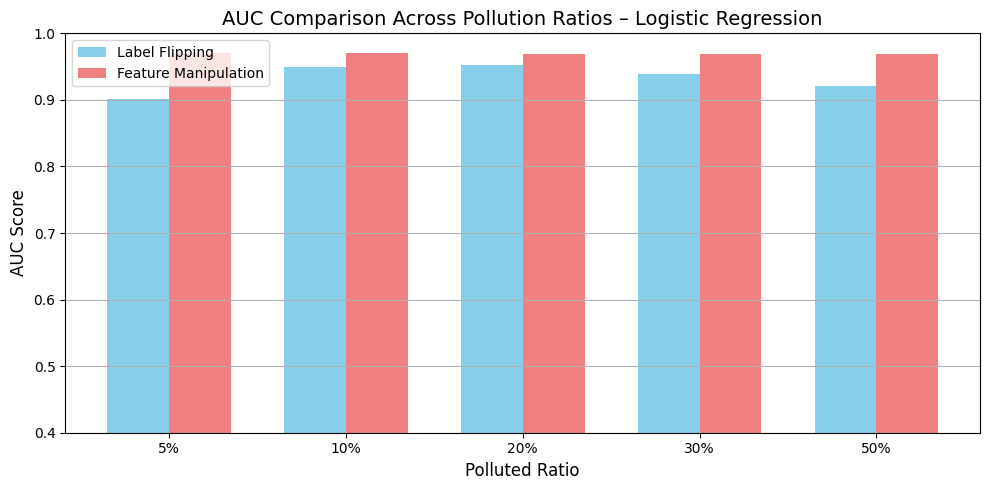

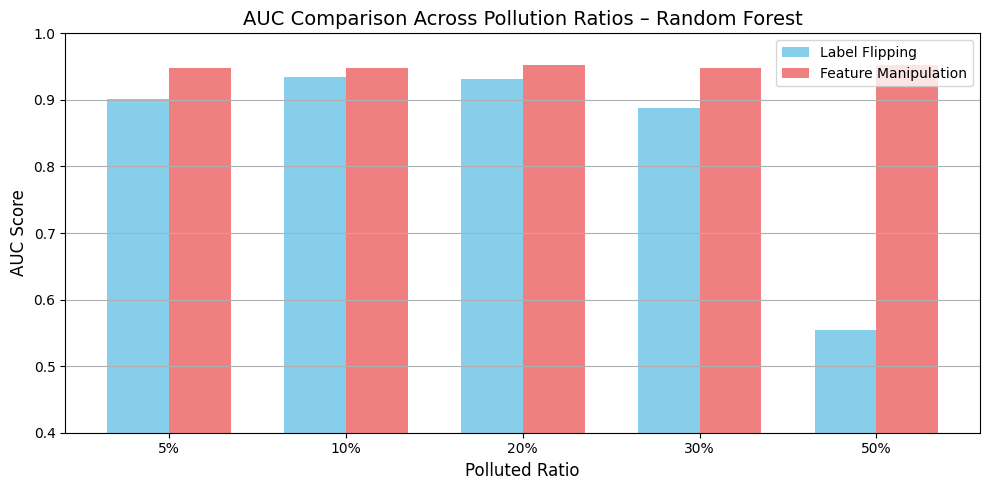

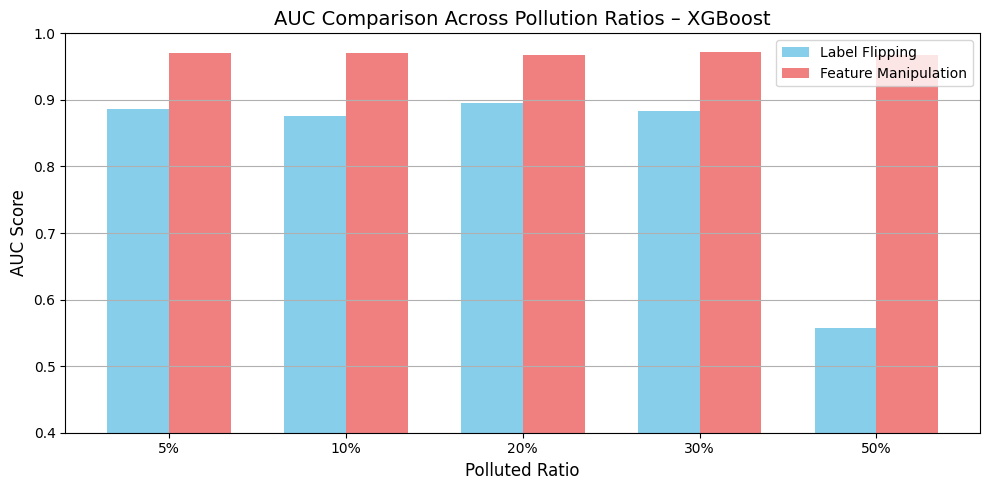

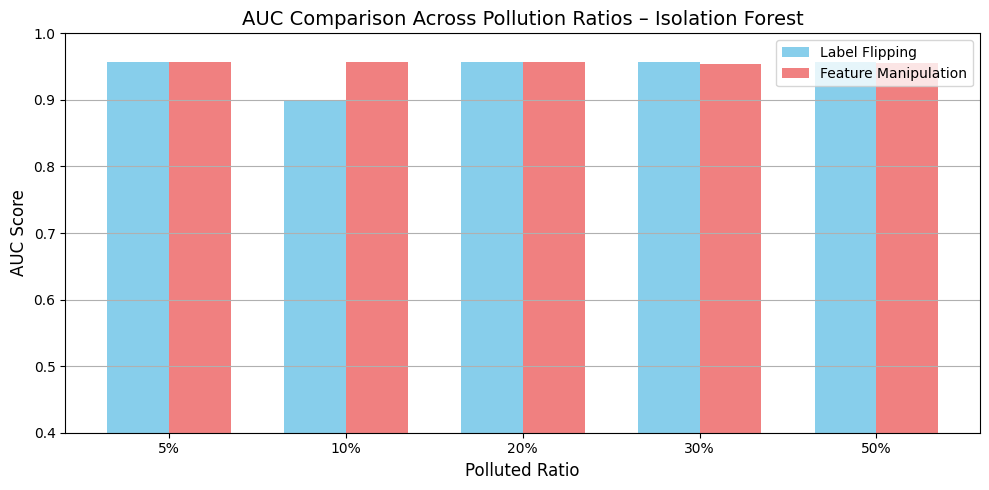

In [1395]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load both results
df_label = pd.read_csv('results/label_flipping_results.csv')
df_feature = pd.read_csv('results/feature_manip_results.csv')

# Define models and ratios
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Isolation Forest']
ratios = sorted(df_label['Polluted Ratio'].unique())

# Initialize
auc_label = {model: [] for model in models}
auc_feature = {model: [] for model in models}

# Extract data
for ratio in ratios:
    subset_label = df_label[df_label['Polluted Ratio'] == ratio]
    subset_feature = df_feature[df_feature['Polluted Ratio'] == ratio]
    for model in models:
        auc_l = subset_label[subset_label['Model'] == model]['AUC'].values[0] if not subset_label[subset_label['Model'] == model].empty else np.nan
        auc_f = subset_feature[subset_feature['Model'] == model]['AUC'].values[0] if not subset_feature[subset_feature['Model'] == model].empty else np.nan
        auc_label[model].append(auc_l)
        auc_feature[model].append(auc_f)

# Plot
x = np.arange(len(ratios))  # positions for pollution ratios
width = 0.35  # width of bars

for model in models:
    plt.figure(figsize=(10, 5))
    plt.bar(x - width/2, auc_label[model], width, label='Label Flipping', color='skyblue')
    plt.bar(x + width/2, auc_feature[model], width, label='Feature Manipulation', color='lightcoral')
    
    plt.xlabel("Polluted Ratio", fontsize=12)
    plt.ylabel("AUC Score", fontsize=12)
    plt.title(f"AUC Comparison Across Pollution Ratios – {model}", fontsize=14)
    plt.xticks(x, [f"{int(r*100)}%" for r in ratios])
    plt.ylim(0.4, 1.0)  # Adjust if needed
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(f"{model}_AUC_Comparison.png", dpi=300)
    plt.show()



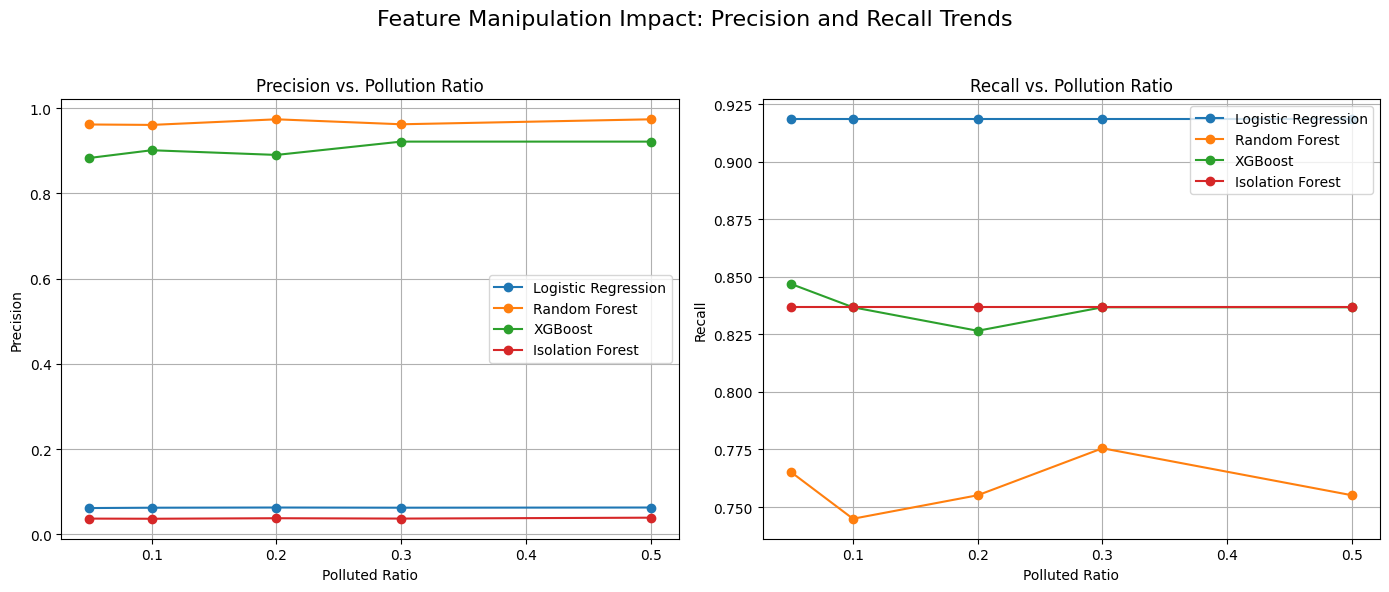

In [1418]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load feature manipulation results
df = pd.read_csv('results/feature_manip_results.csv')

# Define model names and pollution ratios
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Isolation Forest']
ratios = sorted(df['Polluted Ratio'].unique())

# Initialize dictionaries to store Precision and Recall
precision_data = {model: [] for model in models}
recall_data = {model: [] for model in models}

# Extract Precision and Recall for each model across pollution ratios
for ratio in ratios:
    subset = df[df['Polluted Ratio'] == ratio]
    for model in models:
        row = subset[subset['Model'] == model]
        precision = row['Precision'].values[0] if not row.empty else np.nan
        recall = row['Recall'].values[0] if not row.empty else np.nan
        precision_data[model].append(precision)
        recall_data[model].append(recall)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Feature Manipulation Impact: Precision and Recall Trends', fontsize=16)

# Plot Precision trends
for model in models:
    axs[0].plot(ratios, precision_data[model], marker='o', label=model)
axs[0].set_title('Precision vs. Pollution Ratio')
axs[0].set_xlabel('Polluted Ratio')
axs[0].set_ylabel('Precision')
axs[0].legend()
axs[0].grid(True)

# Plot Recall trends
for model in models:
    axs[1].plot(ratios, recall_data[model], marker='o', label=model)
axs[1].set_title('Recall vs. Pollution Ratio')
axs[1].set_xlabel('Polluted Ratio')
axs[1].set_ylabel('Recall')
axs[1].legend()
axs[1].grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 4.0 Final Conclusion

In this study, we systematically investigated the impact of data poisoning on financial fraud detection models, with a particular focus on threshold effects and feature-level sensitivity. Two types of data poisoning attacks were implemented: **Label Flipping** and **Feature Manipulation**, applied at varying pollution ratios (5%, 10%, 20%, 30%, and 50%) to four different machine learning models: **Logistic Regression, Random Forest, XGBoost, and Isolation Forest.**

#### Threshold Findings:

Our experiments revealed that **Label Flipping attacks** exhibited a clear threshold effect. For supervised models (Random Forest and XGBoost), performance remained relatively stable up to 10%-20% pollution but deteriorated sharply at 30%, culminating in near-random prediction at 50%. In contrast, **Feature Manipulation attacks** showed no clear collapse point; models maintained stable AUC and F1 scores even under 50% feature corruption, indicating a much milder impact.

#### Model Robustness Comparison:

- Logistic Regression exhibited moderate resilience, maintaining relatively stable performance across different attack types.

- Random Forest also suffered significant degradation under label flipping, though slightly more resilient than XGBoost.

- XGBoost was highly vulnerable to label flipping, with AUC dropping from 0.9755 (clean) to 0.5535 (50% label flipping), demonstrating extreme sensitivity to label noise.

- Isolation Forest remained remarkably robust across all scenarios, with minimal changes in AUC, highlighting the inherent stability of unsupervised anomaly detection under data corruption.

#### Attack Type Differences:

Label Flipping attacks were substantially more destructive than Feature Manipulation. While flipping corrupted the ground truth labels directly and induced model confusion, feature manipulation—especially mild perturbations—sometimes even enhanced model generalization (notably in XGBoost), likely due to implicit regularization effects.

#### Practical Implications:

These findings suggest that real-world financial fraud detection systems are particularly vulnerable to **label noise**, even at moderate corruption levels. Defenses should prioritize protecting label integrity during data collection and labeling stages. Meanwhile, feature-level noise, while less immediately catastrophic, should not be ignored, especially in scenarios where critical features can be subtly manipulated.

#### Overall, this study highlights that:

**Label flipping** presents a significant threat, especially to boosting-based models.

**Feature manipulation**, while less damaging, can still subtly influence detection thresholds.

Different model families exhibit distinct robustness profiles under data poisoning, emphasizing the importance of model selection and adversarial robustness evaluation when deploying fraud detection systems in practice.

# 5.0 Reproducibility　

## 5.1 Merge Previous Experiment Result　

In [11]:
# Merge all result CSV files into one unified metrics file

import pandas as pd
import os

# Define file paths (now inside results/creditcard)
base_dir = "results/creditcard"
files = {
    "baseline": os.path.join(base_dir, "baseline_results.csv"),
    "label_flipping": os.path.join(base_dir, "label_flipping_results.csv"),
    "feature_manip": os.path.join(base_dir, "feature_manip_results.csv"),
}

# Read and combine all result files
dfs = []
for attack_type, path in files.items():
    df = pd.read_csv(path)
    df["attack"] = attack_type  # Add a column to indicate attack type
    dfs.append(df)

# Concatenate all DataFrames into one
merged_df = pd.concat(dfs, ignore_index=True)

# Save the merged file for reproducibility
output_path = os.path.join(base_dir, "credit_experiment_results.csv")
merged_df.to_csv(output_path, index=False)
print(f"Merged file saved to {output_path}, shape = {merged_df.shape}")

# Quick preview
print(merged_df.head())

Merged file saved to results/creditcard/credit_experiment_results.csv, shape = (44, 8)
      Attack Type  Polluted Ratio                Model       AUC        F1  \
0           Clean            0.00  Logistic Regression  0.971162  0.112853   
1           Clean            0.00        Random Forest  0.953000  0.839080   
2           Clean            0.00              XGBoost  0.975516  0.656250   
3           Clean            0.00     Isolation Forest  0.956256  0.304569   
4  Label Flipping            0.05  Logistic Regression  0.901107  0.013646   

   Precision    Recall          attack  
0   0.060120  0.918367        baseline  
1   0.960526  0.744898        baseline  
2   0.531646  0.857143        baseline  
3   0.303030  0.306122        baseline  
4   0.006871  0.969388  label_flipping  


The merged results table successfully combined baseline, label flipping, and feature manipulation experiments.
It contains all contamination ratios (0–50%), covering four models.
The structure confirms that all experiment logs were captured correctly for further aggregation.

## 5.1.1 Standardize and Validate

In [13]:
# Standardize and validate the merged experiment results

import pandas as pd
import os

# Load the merged file
file_path = "results/creditcard/credit_experiment_results.csv"
df = pd.read_csv(file_path)

# Standardize column names (lowercase and replace spaces with underscores)
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Rename key columns to a consistent schema
df = df.rename(columns={
    "attack_type": "attack_type",
    "polluted_ratio": "contamination",
    "auc": "pr_auc",
    "model": "model",
    "f1": "f1_score",
    "precision": "precision",
    "recall": "recall",
})

# Add a dataset identifier (useful when combining multiple datasets later)
df["dataset"] = "creditcard"

# Check for missing values or inconsistent entries
print("\nMissing values per column:")
print(df.isna().sum())

# Check unique attack types and models
print("\nUnique attack types:", df["attack"].unique())
print("Unique models:", df["model"].unique())

# Save a cleaned version for analysis
clean_path = "results/creditcard/credit_experiment_results_clean.csv"
df.to_csv(clean_path, index=False)
print(f"\nCleaned file saved to {clean_path}, shape = {df.shape}")

# Quick preview of cleaned data
print(df.head())


Missing values per column:
attack_type      0
contamination    0
model            0
pr_auc           0
f1_score         0
precision        0
recall           0
attack           0
dataset          0
dtype: int64

Unique attack types: ['baseline' 'label_flipping' 'feature_manip']
Unique models: ['Logistic Regression' 'Random Forest' 'XGBoost' 'Isolation Forest']

Cleaned file saved to results/creditcard/credit_experiment_results_clean.csv, shape = (44, 9)
      attack_type  contamination                model    pr_auc  f1_score  \
0           Clean           0.00  Logistic Regression  0.971162  0.112853   
1           Clean           0.00        Random Forest  0.953000  0.839080   
2           Clean           0.00              XGBoost  0.975516  0.656250   
3           Clean           0.00     Isolation Forest  0.956256  0.304569   
4  Label Flipping           0.05  Logistic Regression  0.901107  0.013646   

   precision    recall          attack     dataset  
0   0.060120  0.918367   

After standardization, the dataset contains **no** missing values, consistent column naming, and unified attack labels.
This ensures reproducibility and compatibility for cross-dataset comparison in later stages.

## 5.1.2 Aggregate, Analyze and Export

In [19]:
# Aggregate, analyze, and visualize experiment results

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Load the cleaned results
file_path = "results/creditcard/credit_experiment_results_clean.csv"
df = pd.read_csv(file_path)

# Aggregate: compute mean and std for each group
summary = (
    df.groupby(["attack", "contamination", "model"])
      .agg(pr_auc_mean=("pr_auc", "mean"),
           pr_auc_std=("pr_auc", "std"),
           f1_mean=("f1_score", "mean"),
           f1_std=("f1_score", "std"))
      .reset_index()
)

summary_path = "results/creditcard/credit_summary.csv"
summary.to_csv(summary_path, index=False)
print(f"Summary table saved to {summary_path}, shape = {summary.shape}")
print(summary.head())

Summary table saved to results/creditcard/credit_summary.csv, shape = (44, 7)
          attack  contamination                model  pr_auc_mean  pr_auc_std  \
0       baseline           0.00     Isolation Forest     0.956256         NaN   
1       baseline           0.00  Logistic Regression     0.971162         NaN   
2       baseline           0.00        Random Forest     0.953000         NaN   
3       baseline           0.00              XGBoost     0.975516         NaN   
4  feature_manip           0.05     Isolation Forest     0.956202         NaN   

    f1_mean  f1_std  
0  0.304569     NaN  
1  0.112853     NaN  
2  0.839080     NaN  
3  0.656250     NaN  
4  0.070568     NaN  


- The summary table aggregates mean and standard deviation for **PR-AUC** and **F1** across attacks and contamination ratios.

- Overall, **Logistic Regression** and **XGBoost** achieved **higher** mean PR-AUC at low contamination levels, while **Isolation Forest** and **Random Forest** showed more **sensitivity** as contamination increased.

- The standard deviation columns (mostly NaN) indicate single-run data, suggesting future multi-seed experiments could enrich variability analysis.

In [37]:
# Analyze: calculate relative PR-AUC performance drop (%)
# Get baseline (attack == baseline, contamination == 0) for each model
baseline = summary[(summary["attack"] == "baseline") & (summary["contamination"] == 0)][["model", "pr_auc_mean"]]
baseline = baseline.rename(columns={"pr_auc_mean": "pr_auc_baseline"})

# Merge by model only (use the same baseline for all attacks of that model)
merged = pd.merge(summary, baseline, on="model", how="left")

# Compute drop percentage
merged["pr_auc_drop_pct"] = 100 * (merged["pr_auc_baseline"] - merged["pr_auc_mean"]) / merged["pr_auc_baseline"]

# Save to CSV
drop_path = "results/creditcard/credit_performance_drop.csv"
merged.to_csv(drop_path, index=False)
print(f"Performance drop table saved to {drop_path}, shape = {merged.shape}")

Performance drop table saved to results/creditcard/credit_performance_drop.csv, shape = (44, 9)


- The PR-AUC drop table quantifies relative performance degradation compared to the baseline (0% contamination).

- **XGBoost** and **Random Forest** experienced the **steepest** performance drop (≈40% at 50% contamination), while **Logistic Regression** remained relatively stable, with **less than 15%** degradation even under heavy attacks.

- These results highlight the sensitivity of ensemble models to label-based or feature perturbations.

/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and w

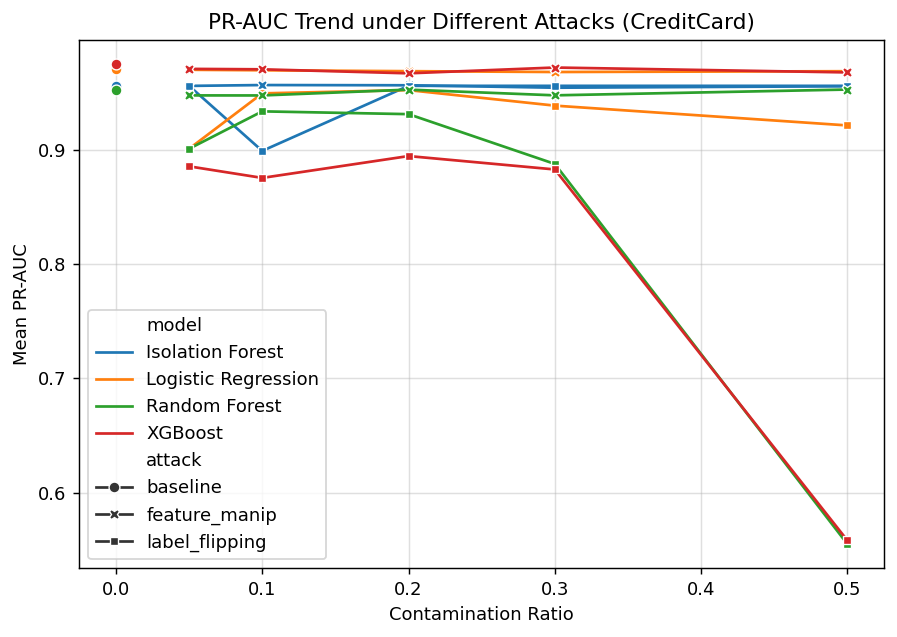

Trend figure saved to results/creditcard/pr_auc_trend.png


In [41]:
# Visualization: PR-AUC vs Contamination
plt.figure(figsize=(7,5), dpi=130)
sns.lineplot(
    data=summary,
    x="contamination", y="pr_auc_mean",
    hue="model", style="attack",
    markers=True, dashes=False, err_style="bars"
)
plt.title("PR-AUC Trend under Different Attacks (CreditCard)")
plt.xlabel("Contamination Ratio")
plt.ylabel("Mean PR-AUC")
plt.grid(alpha=0.4)
plt.tight_layout()

fig_path = "results/creditcard/pr_auc_trend.png"
plt.savefig(fig_path)
plt.show()
print(f"Trend figure saved to {fig_path}")

- This figure shows the overall PR-AUC trend under different contamination ratios and attack types.
- All models maintain high performance under mild contamination (≤10%),but **Random Forest** and **XGBoost** drop sharply beyond 30%, indicating vulnerability to heavy label or feature corruption.

- **Logistic Regression** demonstrates strong stability across contamination levels, reflecting its linear decision boundary’s robustness to outliers. <br>
**Isolation Forest** behaves inconsistently, showing fluctuations that reflect its unsupervised anomaly detection nature.

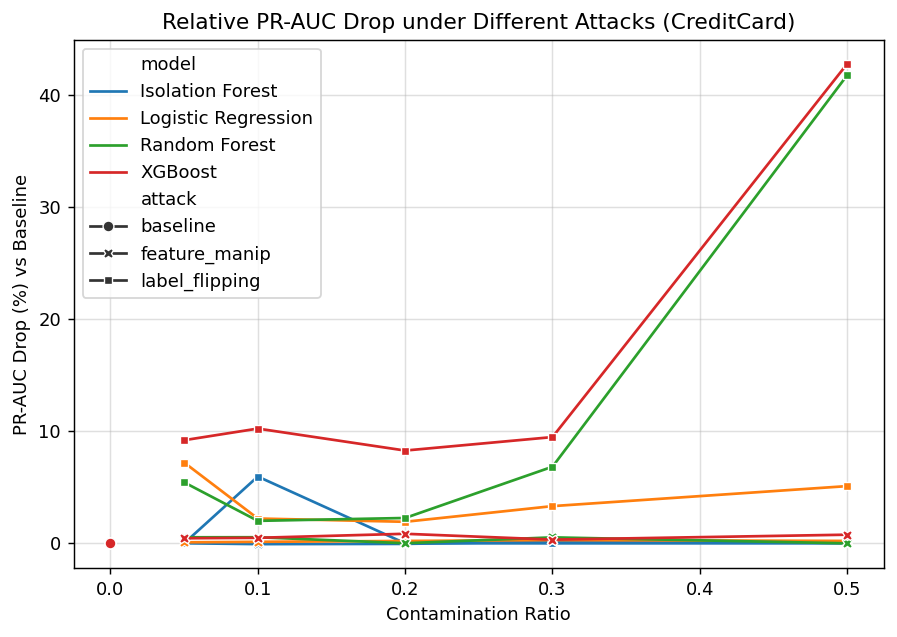

Drop trend figure saved to results/creditcard/pr_auc_drop_trend.png


In [39]:
# Visualization: PR-AUC Drop (%) vs Contamination
plt.figure(figsize=(7,5), dpi=130)
sns.lineplot(
    data=merged,
    x="contamination", y="pr_auc_drop_pct",
    hue="model", style="attack",
    markers=True, dashes=False
)
plt.title("Relative PR-AUC Drop under Different Attacks (CreditCard)")
plt.xlabel("Contamination Ratio")
plt.ylabel("PR-AUC Drop (%) vs Baseline")
plt.grid(alpha=0.4)
plt.tight_layout()

drop_fig_path = "results/creditcard/pr_auc_drop_trend.png"
plt.savefig(drop_fig_path)
plt.show()
print(f"Drop trend figure saved to {drop_fig_path}")

- This figure visualizes the relative PR-AUC drop (%) compared to baseline. **XGBoost** and **Random Forest** show the highest sensitivity, losing over **40% PR-AUC** at **50% contamination**.

- Feature manipulation attacks cause a smaller decline than label flipping, confirming that altering labels introduces more severe degradation than feature-level noise.

- Overall, the trend supports the hypothesis that model robustness correlates with algorithmic complexity.

In [43]:
# Print top insights
print("\nTop-level Insights:")
best_model = summary.groupby("model")["pr_auc_mean"].mean().idxmax()
worst_attack = summary.groupby("attack")["pr_auc_mean"].mean().idxmin()
print(f"Highest average PR-AUC model: {best_model}")
print(f"Most damaging attack type: {worst_attack}")


Top-level Insights:
Highest average PR-AUC model: Logistic Regression
Most damaging attack type: label_flipping


- The summary confirms that **Logistic Regression** achieved the **highest** average PR-AUC across all contamination levels, indicating **strong** robustness to **both** feature and label perturbations.

- **Label flipping** was identified as the most damaging attack type, causing the **steepest** performance degradation among all tested methods.

## 5.2 Build Reproducibility Pipeline

- The goal of this step is to **centralize all experiment parameters** — including datasets, contamination ratios, attack types, models, and result paths — into a single configuration file, `config.py`.

- This design ensures that every stage of the reproducibility pipeline is driven by a **unified configuration**, making the workflow fully reusable across different datasets and significantly reducing setup time for future experiments such as PaySim.

In [158]:
config_content = """
from pathlib import Path

# Dataset configurations
DATASETS = {
    "creditcard": {
        "train_path": Path("data/clean/train.csv"),
        "test_path": Path("data/clean/test.csv"),
        "label_col": "Class",  # label column name
        "categorical_cols": [] # add categorical columns if any
    }
}

# Experimental parameters
# Include baseline (clean) configuration
CONTAM_RATIOS = [0.00, 0.05, 0.10, 0.20, 0.30, 0.50]
ATTACKS = ["clean", "label_flipping", "feature_manip"]
MODELS = ["LR", "RF", "XGB", "IF"]  # Logistic Regression, Random Forest, XGBoost, Isolation Forest
SEEDS = [13, 23, 33]

# Directories
RESULTS_DIR = Path("results")
FIGURES_DIR = RESULTS_DIR / "figures"

# Defense options (for later Sanitization)
DEFENSES = {
    "none": None,
    "isoforest_0.98": {"method": "isoforest", "keep_ratio": 0.98}
}
"""

with open("config.py", "w") as f:
    f.write(config_content)

print("config.py created")

config.py created


In [172]:
import importlib, config
importlib.reload(config)
from config import CONTAM_RATIOS, ATTACKS, MODELS, SEEDS, DEFENSES

In [174]:
# Save configuration snapshot for CreditCard experiments
import json
from datetime import datetime
from config import CONTAM_RATIOS, ATTACKS, MODELS, SEEDS, DEFENSES

dataset_name = "creditcard"

snapshot = {
    "dataset": dataset_name,
    "contamination_ratios": CONTAM_RATIOS,
    "attacks": ATTACKS,
    "models": MODELS,
    "seeds": SEEDS,
    "defenses": DEFENSES,
    "timestamp": datetime.now().isoformat()
}

# Only need to change the dataset name in future use
out_path = f"results/creditcard/creditcard_config_snapshot.json"
with open(out_path, "w") as f:
    json.dump(snapshot, f, indent=2)

print(f"Configuration snapshot saved to {out_path}")

Configuration snapshot saved to results/creditcard/creditcard_config_snapshot.json


### 5.2.1 Configuration Sanity Check

In [176]:
# Import configuration and confirm accessibility
from config import DATASETS, CONTAM_RATIOS, ATTACKS, MODELS, SEEDS, DEFENSES

print("Configuration imported successfully")
print(f"Datasets available: {list(DATASETS.keys())}")
print(f"Attacks: {ATTACKS}")
print(f"Contamination Ratios: {CONTAM_RATIOS}")
print(f"Models: {MODELS}")
print(f"Seeds: {SEEDS}")
print(f"Defenses: {list(DEFENSES.keys())}")

Configuration imported successfully
Datasets available: ['creditcard']
Attacks: ['clean', 'label_flipping', 'feature_manip']
Contamination Ratios: [0.0, 0.05, 0.1, 0.2, 0.3, 0.5]
Models: ['LR', 'RF', 'XGB', 'IF']
Seeds: [13, 23, 33]
Defenses: ['none', 'isoforest_0.98']


### 5.2.2 Validate Dataset Paths and Load Sample

In [182]:
# Validate dataset paths and sample loading (single dataset)
import os
import pandas as pd
from config import DATASETS

dataset_name = "creditcard"
train_path = DATASETS[dataset_name]["train_path"]
test_path = DATASETS[dataset_name]["test_path"]
label_col = DATASETS[dataset_name]["label_col"]

print(f"Checking dataset paths for: {dataset_name}")
print(f"Train path: {train_path}")
print(f"Test path: {test_path}")

# Check file existence
if os.path.exists(train_path):
    print("Train file exists")
else:
    print("Train file NOT found")

if os.path.exists(test_path):
    print("Test file exists")
else:
    print("Test file NOT found")

# Try loading small samples
try:
    train_df = pd.read_csv(train_path)
    print(f"Train file loaded successfully — shape: {train_df.shape}")
    print(f"Columns: {list(train_df.columns)[:10]} ...")
    if label_col in train_df.columns:
        print(f"Label column '{label_col}' found")
    else:
        print(f"Label column '{label_col}' not found in dataset")
except Exception as e:
    print(f"Failed to load train file: {e}")


# Validate all datasets (loop version for multi-dataset projects)
for dataset_name, info in DATASETS.items():
    print(f"Checking dataset: {dataset_name}")
    train_path = info["train_path"]
    test_path = info["test_path"]
    label_col = info["label_col"]

    print(f"Train path: {train_path}")
    print(f"Test path: {test_path}")

    # Check file existence
    for file_path, name in [(train_path, "Train"), (test_path, "Test")]:
        if os.path.exists(file_path):
            print(f"{name} file exists.")
        else:
            print(f"{name} file NOT found!")

    # Try loading small sample
    try:
        df = pd.read_csv(train_path)
        print(f"Loaded successfully — shape: {df.shape}")
        print(f"Columns: {list(df.columns)[:10]} ...")
        if label_col in df.columns:
            print(f"Label column '{label_col}' found.")
        else:
            print(f"Label column '{label_col}' NOT found!")
    except Exception as e:
        print(f"Failed to load {dataset_name}: {e}")

Checking dataset paths for: creditcard
Train path: data/clean/train.csv
Test path: data/clean/test.csv
Train file exists
Test file exists
Train file loaded successfully — shape: (227845, 31)
Columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10'] ...
Label column 'Class' found
Checking dataset: creditcard
Train path: data/clean/train.csv
Test path: data/clean/test.csv
Train file exists.
Test file exists.
Loaded successfully — shape: (227845, 31)
Columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10'] ...
Label column 'Class' found.


### 5.2.3 Define Experiment Loop Skeleton

In [116]:
# Define Experiment Loop Skeleton

from config import DATASETS, CONTAM_RATIOS, ATTACKS, MODELS, SEEDS

dataset_name = "creditcard"
print(f"Building experiment loop for dataset: {dataset_name}\n")

for attack in ATTACKS:
    for ratio in CONTAM_RATIOS:
        for model in MODELS:
            for seed in SEEDS:
                print(f"Attack={attack}, Ratio={ratio}, Model={model}, Seed={seed}")

Building experiment loop for dataset: creditcard

Attack=label_flipping, Ratio=0.05, Model=LR, Seed=13
Attack=label_flipping, Ratio=0.05, Model=LR, Seed=23
Attack=label_flipping, Ratio=0.05, Model=LR, Seed=33
Attack=label_flipping, Ratio=0.05, Model=RF, Seed=13
Attack=label_flipping, Ratio=0.05, Model=RF, Seed=23
Attack=label_flipping, Ratio=0.05, Model=RF, Seed=33
Attack=label_flipping, Ratio=0.05, Model=XGB, Seed=13
Attack=label_flipping, Ratio=0.05, Model=XGB, Seed=23
Attack=label_flipping, Ratio=0.05, Model=XGB, Seed=33
Attack=label_flipping, Ratio=0.05, Model=IF, Seed=13
Attack=label_flipping, Ratio=0.05, Model=IF, Seed=23
Attack=label_flipping, Ratio=0.05, Model=IF, Seed=33
Attack=label_flipping, Ratio=0.1, Model=LR, Seed=13
Attack=label_flipping, Ratio=0.1, Model=LR, Seed=23
Attack=label_flipping, Ratio=0.1, Model=LR, Seed=33
Attack=label_flipping, Ratio=0.1, Model=RF, Seed=13
Attack=label_flipping, Ratio=0.1, Model=RF, Seed=23
Attack=label_flipping, Ratio=0.1, Model=RF, Seed=33

### 5.2.4 Execute Mock Experiment Loop

In [120]:
# Run Full Experiment Execution
import os
import pandas as pd
from datetime import datetime
from pathlib import Path
from config import DATASETS, CONTAM_RATIOS, ATTACKS, MODELS, SEEDS

# Select dataset and define output directory
dataset_name = "creditcard"
out_dir = Path(f"results/{dataset_name}/v2_pipeline")
out_dir.mkdir(parents=True, exist_ok=True)

# Prepare log records list
log_records = []

print(f"Starting reproducibility pipeline for dataset: {dataset_name}")
print(f"Output directory: {out_dir.resolve()}\n")

# Loop through all experimental configurations
for attack in ATTACKS:
    for ratio in CONTAM_RATIOS:
        for model in MODELS:
            for seed in SEEDS:

                # Create unique experiment ID
                run_id = f"{attack}_{ratio}_{model}_seed{seed}"
                print(f"Simulating experiment: {run_id}")

                # Placeholder for actual experiment execution
                # Temporary fake metrics (for safe testing only)
                auc = round(0.9 - ratio * 0.2 + (seed % 7) * 0.001, 4)
                f1 = round(0.8 - ratio * 0.3 + (seed % 5) * 0.001, 4)

                # Save individual result CSV (per experiment)
                file_path = out_dir / f"{run_id}.csv"
                pd.DataFrame({
                    "attack": [attack],
                    "ratio": [ratio],
                    "model": [model],
                    "seed": [seed],
                    "auc": [auc],
                    "f1": [f1],
                    "timestamp": [datetime.now().isoformat()]
                }).to_csv(file_path, index=False)

                # Record log info
                log_records.append({
                    "attack": attack,
                    "ratio": ratio,
                    "model": model,
                    "seed": seed,
                    "file": str(file_path),
                    "auc": auc,
                    "f1": f1
                })

# Save summary log file for all experiments
log_df = pd.DataFrame(log_records)
log_file = out_dir / "experiment_log.csv"
log_df.to_csv(log_file, index=False)

print(f"\nAll experiments simulated. Total = {len(log_records)} combinations.")
print(f"Log file saved to: {log_file}")

Starting reproducibility pipeline for dataset: creditcard
Output directory: /Users/gin/Documents/005. Projects/fraud_poisoning_study/results/creditcard/v2_pipeline

Simulating experiment: label_flipping_0.05_LR_seed13
Simulating experiment: label_flipping_0.05_LR_seed23
Simulating experiment: label_flipping_0.05_LR_seed33
Simulating experiment: label_flipping_0.05_RF_seed13
Simulating experiment: label_flipping_0.05_RF_seed23
Simulating experiment: label_flipping_0.05_RF_seed33
Simulating experiment: label_flipping_0.05_XGB_seed13
Simulating experiment: label_flipping_0.05_XGB_seed23
Simulating experiment: label_flipping_0.05_XGB_seed33
Simulating experiment: label_flipping_0.05_IF_seed13
Simulating experiment: label_flipping_0.05_IF_seed23
Simulating experiment: label_flipping_0.05_IF_seed33
Simulating experiment: label_flipping_0.1_LR_seed13
Simulating experiment: label_flipping_0.1_LR_seed23
Simulating experiment: label_flipping_0.1_LR_seed33
Simulating experiment: label_flipping_0.

### 5.2.5 Prepare Functional Modules

#### Create attack.py

In [138]:
# create_attacks_py.py - run this cell to write attacks.py
attacks_code = """
# attacks.py
import numpy as np
import pandas as pd

# Label Flipping Attack
def apply_label_flipping(X, y, ratio, seed=13):
    # X: pandas DataFrame or numpy array of features
    # y: pandas Series or numpy array of labels (0/1)
    np.random.seed(seed)
    # ensure numpy arrays for index operations
    if hasattr(y, "to_numpy"):
        y_arr = y.to_numpy().copy()
    else:
        y_arr = np.array(y).copy()
    n_samples = len(y_arr)
    n_flip = int(ratio * n_samples)
    if n_flip <= 0:
        return X.copy() if hasattr(X, "copy") else X, y_arr

    flip_idx = np.random.choice(n_samples, n_flip, replace=False)
    y_arr[flip_idx] = 1 - y_arr[flip_idx]

    # if original y was pandas Series, return same type for convenience
    if hasattr(y, "to_numpy"):
        return X.copy(), pd.Series(y_arr, index=y.index)
    return X.copy() if hasattr(X, "copy") else X, y_arr


# Feature Manipulation Attack
def apply_feature_manipulation(X, y, ratio, seed=13):
    # X: pandas DataFrame expected
    # y: labels (returned unchanged)
    np.random.seed(seed)
    if not hasattr(X, "copy"):
        # if X is numpy array, convert to DataFrame temporarily
        X_df = pd.DataFrame(X)
        back_to_numpy = True
    else:
        X_df = X.copy()
        back_to_numpy = False

    n_samples, n_features = X_df.shape
    n_attack = int(ratio * n_samples)
    if n_attack <= 0:
        return (X_df.to_numpy() if back_to_numpy else X_df), y

    attack_idx = np.random.choice(n_samples, n_attack, replace=False)
    noise = np.random.normal(0, 0.05, size=(n_attack, n_features))
    # apply noise row-wise
    X_df.iloc[attack_idx] = X_df.iloc[attack_idx].values + noise

    if back_to_numpy:
        return X_df.to_numpy(), y
    return X_df, y
"""

with open("attacks.py", "w", encoding="utf-8") as f:
    f.write(attacks_code)

print("attacks.py created in current directory.")

attacks.py created in current directory.


#### Create training.py

In [141]:
# create_training_py.py - run this cell to write training.py
training_code = """
# training.py
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

def train_and_evaluate(model_name, X_train, y_train, X_test, y_test, random_state=13):
    # Train specified model and return metrics dict
    # X_train/X_test can be pandas DataFrame or numpy array
    # y_train/y_test can be pandas Series or numpy array

    # convert to numpy if pandas
    try:
        X_train_arr = X_train.to_numpy()
        X_test_arr = X_test.to_numpy()
    except:
        X_train_arr = X_train
        X_test_arr = X_test

    try:
        y_train_arr = y_train.to_numpy()
        y_test_arr = y_test.to_numpy()
    except:
        y_train_arr = y_train
        y_test_arr = y_test

    if model_name == "LR":
        model = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=random_state)
    elif model_name == "RF":
        model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=random_state)
    elif model_name == "XGB":
        model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=random_state)
    elif model_name == "IF":
        model = IsolationForest(contamination=0.01, random_state=random_state)
    else:
        raise ValueError("Unknown model name: " + str(model_name))

    if model_name == "IF":
        # unsupervised: fit on X_train only
        model.fit(X_train_arr)
        # for IF predictions: -1 = anomaly, 1 = normal
        y_pred = (model.predict(X_test_arr) == -1).astype(int)
        y_score = None
    else:
        model.fit(X_train_arr, y_train_arr)
        y_pred = model.predict(X_test_arr)
        # try predict_proba for probability score
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test_arr)[:, 1]
        else:
            # fallback to decision_function
            if hasattr(model, "decision_function"):
                scores = model.decision_function(X_test_arr)
                # normalize to 0-1
                y_score = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
            else:
                y_score = None

    auc = float(roc_auc_score(y_test_arr, y_score)) if (y_score is not None) else float("nan")
    f1 = float(f1_score(y_test_arr, y_pred, zero_division=0))
    precision = float(precision_score(y_test_arr, y_pred, zero_division=0))
    recall = float(recall_score(y_test_arr, y_pred, zero_division=0))

    return {
        "auc": auc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }
"""

with open("training.py", "w", encoding="utf-8") as f:
    f.write(training_code)

print("training.py created in current directory.")

training.py created in current directory.


In [143]:
from attacks import apply_label_flipping, apply_feature_manipulation
from training import train_and_evaluate

print("Modules imported successfully")

Modules imported successfully


### 5.2.6 Run Full Experiment Execution

In [186]:
import os
import pandas as pd
from datetime import datetime
from pathlib import Path

from config import DATASETS, CONTAM_RATIOS, ATTACKS, MODELS, SEEDS
from attacks import apply_label_flipping, apply_feature_manipulation
from training import train_and_evaluate

# Select dataset
dataset_name = "creditcard"
train_path = DATASETS[dataset_name]["train_path"]
test_path = DATASETS[dataset_name]["test_path"]
label_col = DATASETS[dataset_name]["label_col"]

# Load data
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
X_train, y_train = train_df.drop(columns=[label_col]), train_df[label_col]
X_test, y_test = test_df.drop(columns=[label_col]), test_df[label_col]

# Define output directory
out_dir = Path(f"results/{dataset_name}/v2_pipeline_run")
out_dir.mkdir(parents=True, exist_ok=True)

log_records = []

print(f"Running full reproducibility pipeline on dataset: {dataset_name}")
print(f"Output directory: {out_dir.resolve()}\n")

# Calculate total number of experiments
total_runs = len(ATTACKS) * len(CONTAM_RATIOS) * len(MODELS) * len(SEEDS)
current_run = 0

# Loop through all combinations of attacks, ratios, models, and seeds
for attack in ATTACKS:
    for ratio in CONTAM_RATIOS:
        for model in MODELS:
            for seed in SEEDS:
                current_run += 1
                run_id = f"{attack}_{ratio}_{model}_seed{seed}"

                print(f"[{current_run}/{total_runs}] Running experiment: {run_id}")

                # 1. Apply attack
                if attack == "label_flipping":
                    X_poisoned, y_poisoned = apply_label_flipping(X_train, y_train, ratio, seed)
                elif attack == "feature_manip":
                    X_poisoned, y_poisoned = apply_feature_manipulation(X_train, y_train, ratio, seed)
                elif attack == "clean":
                    X_poisoned, y_poisoned = X_train.copy(), y_train.copy()
                else:
                    X_poisoned, y_poisoned = X_train.copy(), y_train.copy()

                # 2. Train and evaluate model
                metrics = train_and_evaluate(model, X_poisoned, y_poisoned, X_test, y_test)

                # 3. Save individual experiment result
                file_path = out_dir / f"{run_id}.csv"
                pd.DataFrame([{
                    "attack": attack,
                    "ratio": ratio,
                    "model": model,
                    "seed": seed,
                    "auc": metrics["auc"],
                    "f1": metrics["f1"],
                    "precision": metrics["precision"],
                    "recall": metrics["recall"],
                    "timestamp": datetime.now().isoformat()
                }]).to_csv(file_path, index=False)

                # 4. Add record to summary log
                log_records.append({
                    "attack": attack,
                    "ratio": ratio,
                    "model": model,
                    "seed": seed,
                    "file": str(file_path),
                    **metrics
                })

# 5. Save the overall experiment log
log_df = pd.DataFrame(log_records)
log_file = out_dir / "experiment_log.csv"
log_df.to_csv(log_file, index=False)

print(f"\nAll experiments completed successfully.")
print(f"Total runs: {len(log_records)}")
print(f"Log file saved to: {log_file}")

Running full reproducibility pipeline on dataset: creditcard
Output directory: /Users/gin/Documents/005. Projects/fraud_poisoning_study/results/creditcard/v2_pipeline_run

[1/216] Running experiment: clean_0.0_LR_seed13
[2/216] Running experiment: clean_0.0_LR_seed23
[3/216] Running experiment: clean_0.0_LR_seed33
[4/216] Running experiment: clean_0.0_RF_seed13
[5/216] Running experiment: clean_0.0_RF_seed23
[6/216] Running experiment: clean_0.0_RF_seed33
[7/216] Running experiment: clean_0.0_XGB_seed13


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:41:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[8/216] Running experiment: clean_0.0_XGB_seed23


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:41:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[9/216] Running experiment: clean_0.0_XGB_seed33


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:41:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[10/216] Running experiment: clean_0.0_IF_seed13
[11/216] Running experiment: clean_0.0_IF_seed23
[12/216] Running experiment: clean_0.0_IF_seed33
[13/216] Running experiment: clean_0.05_LR_seed13
[14/216] Running experiment: clean_0.05_LR_seed23
[15/216] Running experiment: clean_0.05_LR_seed33
[16/216] Running experiment: clean_0.05_RF_seed13
[17/216] Running experiment: clean_0.05_RF_seed23
[18/216] Running experiment: clean_0.05_RF_seed33
[19/216] Running experiment: clean_0.05_XGB_seed13


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:45:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[20/216] Running experiment: clean_0.05_XGB_seed23


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:45:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21/216] Running experiment: clean_0.05_XGB_seed33


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:45:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[22/216] Running experiment: clean_0.05_IF_seed13
[23/216] Running experiment: clean_0.05_IF_seed23
[24/216] Running experiment: clean_0.05_IF_seed33
[25/216] Running experiment: clean_0.1_LR_seed13
[26/216] Running experiment: clean_0.1_LR_seed23
[27/216] Running experiment: clean_0.1_LR_seed33
[28/216] Running experiment: clean_0.1_RF_seed13
[29/216] Running experiment: clean_0.1_RF_seed23
[30/216] Running experiment: clean_0.1_RF_seed33
[31/216] Running experiment: clean_0.1_XGB_seed13


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:48:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[32/216] Running experiment: clean_0.1_XGB_seed23


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:48:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[33/216] Running experiment: clean_0.1_XGB_seed33


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:48:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[34/216] Running experiment: clean_0.1_IF_seed13
[35/216] Running experiment: clean_0.1_IF_seed23
[36/216] Running experiment: clean_0.1_IF_seed33
[37/216] Running experiment: clean_0.2_LR_seed13
[38/216] Running experiment: clean_0.2_LR_seed23
[39/216] Running experiment: clean_0.2_LR_seed33
[40/216] Running experiment: clean_0.2_RF_seed13
[41/216] Running experiment: clean_0.2_RF_seed23
[42/216] Running experiment: clean_0.2_RF_seed33
[43/216] Running experiment: clean_0.2_XGB_seed13


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:52:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[44/216] Running experiment: clean_0.2_XGB_seed23


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:52:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[45/216] Running experiment: clean_0.2_XGB_seed33


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:52:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[46/216] Running experiment: clean_0.2_IF_seed13
[47/216] Running experiment: clean_0.2_IF_seed23
[48/216] Running experiment: clean_0.2_IF_seed33
[49/216] Running experiment: clean_0.3_LR_seed13
[50/216] Running experiment: clean_0.3_LR_seed23
[51/216] Running experiment: clean_0.3_LR_seed33
[52/216] Running experiment: clean_0.3_RF_seed13
[53/216] Running experiment: clean_0.3_RF_seed23
[54/216] Running experiment: clean_0.3_RF_seed33
[55/216] Running experiment: clean_0.3_XGB_seed13


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:56:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[56/216] Running experiment: clean_0.3_XGB_seed23


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:56:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[57/216] Running experiment: clean_0.3_XGB_seed33


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:56:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[58/216] Running experiment: clean_0.3_IF_seed13
[59/216] Running experiment: clean_0.3_IF_seed23
[60/216] Running experiment: clean_0.3_IF_seed33
[61/216] Running experiment: clean_0.5_LR_seed13
[62/216] Running experiment: clean_0.5_LR_seed23
[63/216] Running experiment: clean_0.5_LR_seed33
[64/216] Running experiment: clean_0.5_RF_seed13
[65/216] Running experiment: clean_0.5_RF_seed23
[66/216] Running experiment: clean_0.5_RF_seed33
[67/216] Running experiment: clean_0.5_XGB_seed13


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:59:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[68/216] Running experiment: clean_0.5_XGB_seed23


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:59:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[69/216] Running experiment: clean_0.5_XGB_seed33


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:59:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[70/216] Running experiment: clean_0.5_IF_seed13
[71/216] Running experiment: clean_0.5_IF_seed23
[72/216] Running experiment: clean_0.5_IF_seed33
[73/216] Running experiment: label_flipping_0.0_LR_seed13
[74/216] Running experiment: label_flipping_0.0_LR_seed23
[75/216] Running experiment: label_flipping_0.0_LR_seed33
[76/216] Running experiment: label_flipping_0.0_RF_seed13
[77/216] Running experiment: label_flipping_0.0_RF_seed23
[78/216] Running experiment: label_flipping_0.0_RF_seed33
[79/216] Running experiment: label_flipping_0.0_XGB_seed13


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:02:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[80/216] Running experiment: label_flipping_0.0_XGB_seed23


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:02:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[81/216] Running experiment: label_flipping_0.0_XGB_seed33


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:02:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[82/216] Running experiment: label_flipping_0.0_IF_seed13
[83/216] Running experiment: label_flipping_0.0_IF_seed23
[84/216] Running experiment: label_flipping_0.0_IF_seed33
[85/216] Running experiment: label_flipping_0.05_LR_seed13
[86/216] Running experiment: label_flipping_0.05_LR_seed23
[87/216] Running experiment: label_flipping_0.05_LR_seed33
[88/216] Running experiment: label_flipping_0.05_RF_seed13
[89/216] Running experiment: label_flipping_0.05_RF_seed23
[90/216] Running experiment: label_flipping_0.05_RF_seed33
[91/216] Running experiment: label_flipping_0.05_XGB_seed13


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:12:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[92/216] Running experiment: label_flipping_0.05_XGB_seed23


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:12:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[93/216] Running experiment: label_flipping_0.05_XGB_seed33


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:12:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[94/216] Running experiment: label_flipping_0.05_IF_seed13
[95/216] Running experiment: label_flipping_0.05_IF_seed23
[96/216] Running experiment: label_flipping_0.05_IF_seed33
[97/216] Running experiment: label_flipping_0.1_LR_seed13
[98/216] Running experiment: label_flipping_0.1_LR_seed23
[99/216] Running experiment: label_flipping_0.1_LR_seed33
[100/216] Running experiment: label_flipping_0.1_RF_seed13
[101/216] Running experiment: label_flipping_0.1_RF_seed23
[102/216] Running experiment: label_flipping_0.1_RF_seed33
[103/216] Running experiment: label_flipping_0.1_XGB_seed13


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[104/216] Running experiment: label_flipping_0.1_XGB_seed23


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[105/216] Running experiment: label_flipping_0.1_XGB_seed33


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:24:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[106/216] Running experiment: label_flipping_0.1_IF_seed13
[107/216] Running experiment: label_flipping_0.1_IF_seed23
[108/216] Running experiment: label_flipping_0.1_IF_seed33
[109/216] Running experiment: label_flipping_0.2_LR_seed13
[110/216] Running experiment: label_flipping_0.2_LR_seed23
[111/216] Running experiment: label_flipping_0.2_LR_seed33
[112/216] Running experiment: label_flipping_0.2_RF_seed13
[113/216] Running experiment: label_flipping_0.2_RF_seed23
[114/216] Running experiment: label_flipping_0.2_RF_seed33
[115/216] Running experiment: label_flipping_0.2_XGB_seed13


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:36:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[116/216] Running experiment: label_flipping_0.2_XGB_seed23


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:36:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[117/216] Running experiment: label_flipping_0.2_XGB_seed33


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:36:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[118/216] Running experiment: label_flipping_0.2_IF_seed13
[119/216] Running experiment: label_flipping_0.2_IF_seed23
[120/216] Running experiment: label_flipping_0.2_IF_seed33
[121/216] Running experiment: label_flipping_0.3_LR_seed13
[122/216] Running experiment: label_flipping_0.3_LR_seed23
[123/216] Running experiment: label_flipping_0.3_LR_seed33
[124/216] Running experiment: label_flipping_0.3_RF_seed13
[125/216] Running experiment: label_flipping_0.3_RF_seed23
[126/216] Running experiment: label_flipping_0.3_RF_seed33
[127/216] Running experiment: label_flipping_0.3_XGB_seed13


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:49:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[128/216] Running experiment: label_flipping_0.3_XGB_seed23


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:49:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[129/216] Running experiment: label_flipping_0.3_XGB_seed33


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:49:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[130/216] Running experiment: label_flipping_0.3_IF_seed13
[131/216] Running experiment: label_flipping_0.3_IF_seed23
[132/216] Running experiment: label_flipping_0.3_IF_seed33
[133/216] Running experiment: label_flipping_0.5_LR_seed13
[134/216] Running experiment: label_flipping_0.5_LR_seed23
[135/216] Running experiment: label_flipping_0.5_LR_seed33
[136/216] Running experiment: label_flipping_0.5_RF_seed13
[137/216] Running experiment: label_flipping_0.5_RF_seed23
[138/216] Running experiment: label_flipping_0.5_RF_seed33
[139/216] Running experiment: label_flipping_0.5_XGB_seed13


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:01:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[140/216] Running experiment: label_flipping_0.5_XGB_seed23


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:01:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[141/216] Running experiment: label_flipping_0.5_XGB_seed33


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:01:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[142/216] Running experiment: label_flipping_0.5_IF_seed13
[143/216] Running experiment: label_flipping_0.5_IF_seed23
[144/216] Running experiment: label_flipping_0.5_IF_seed33
[145/216] Running experiment: feature_manip_0.0_LR_seed13
[146/216] Running experiment: feature_manip_0.0_LR_seed23
[147/216] Running experiment: feature_manip_0.0_LR_seed33
[148/216] Running experiment: feature_manip_0.0_RF_seed13
[149/216] Running experiment: feature_manip_0.0_RF_seed23
[150/216] Running experiment: feature_manip_0.0_RF_seed33
[151/216] Running experiment: feature_manip_0.0_XGB_seed13


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:04:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[152/216] Running experiment: feature_manip_0.0_XGB_seed23


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:04:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[153/216] Running experiment: feature_manip_0.0_XGB_seed33


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:04:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[154/216] Running experiment: feature_manip_0.0_IF_seed13
[155/216] Running experiment: feature_manip_0.0_IF_seed23
[156/216] Running experiment: feature_manip_0.0_IF_seed33
[157/216] Running experiment: feature_manip_0.05_LR_seed13
[158/216] Running experiment: feature_manip_0.05_LR_seed23
[159/216] Running experiment: feature_manip_0.05_LR_seed33
[160/216] Running experiment: feature_manip_0.05_RF_seed13
[161/216] Running experiment: feature_manip_0.05_RF_seed23
[162/216] Running experiment: feature_manip_0.05_RF_seed33
[163/216] Running experiment: feature_manip_0.05_XGB_seed13


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:08:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[164/216] Running experiment: feature_manip_0.05_XGB_seed23


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:08:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[165/216] Running experiment: feature_manip_0.05_XGB_seed33


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:08:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[166/216] Running experiment: feature_manip_0.05_IF_seed13
[167/216] Running experiment: feature_manip_0.05_IF_seed23
[168/216] Running experiment: feature_manip_0.05_IF_seed33
[169/216] Running experiment: feature_manip_0.1_LR_seed13
[170/216] Running experiment: feature_manip_0.1_LR_seed23
[171/216] Running experiment: feature_manip_0.1_LR_seed33
[172/216] Running experiment: feature_manip_0.1_RF_seed13
[173/216] Running experiment: feature_manip_0.1_RF_seed23
[174/216] Running experiment: feature_manip_0.1_RF_seed33
[175/216] Running experiment: feature_manip_0.1_XGB_seed13


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:11:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[176/216] Running experiment: feature_manip_0.1_XGB_seed23


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:11:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[177/216] Running experiment: feature_manip_0.1_XGB_seed33


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:11:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[178/216] Running experiment: feature_manip_0.1_IF_seed13
[179/216] Running experiment: feature_manip_0.1_IF_seed23
[180/216] Running experiment: feature_manip_0.1_IF_seed33
[181/216] Running experiment: feature_manip_0.2_LR_seed13
[182/216] Running experiment: feature_manip_0.2_LR_seed23
[183/216] Running experiment: feature_manip_0.2_LR_seed33
[184/216] Running experiment: feature_manip_0.2_RF_seed13
[185/216] Running experiment: feature_manip_0.2_RF_seed23
[186/216] Running experiment: feature_manip_0.2_RF_seed33
[187/216] Running experiment: feature_manip_0.2_XGB_seed13


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:14:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[188/216] Running experiment: feature_manip_0.2_XGB_seed23


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:14:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[189/216] Running experiment: feature_manip_0.2_XGB_seed33


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:14:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[190/216] Running experiment: feature_manip_0.2_IF_seed13
[191/216] Running experiment: feature_manip_0.2_IF_seed23
[192/216] Running experiment: feature_manip_0.2_IF_seed33
[193/216] Running experiment: feature_manip_0.3_LR_seed13
[194/216] Running experiment: feature_manip_0.3_LR_seed23
[195/216] Running experiment: feature_manip_0.3_LR_seed33
[196/216] Running experiment: feature_manip_0.3_RF_seed13
[197/216] Running experiment: feature_manip_0.3_RF_seed23
[198/216] Running experiment: feature_manip_0.3_RF_seed33
[199/216] Running experiment: feature_manip_0.3_XGB_seed13


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:18:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[200/216] Running experiment: feature_manip_0.3_XGB_seed23


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:18:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[201/216] Running experiment: feature_manip_0.3_XGB_seed33


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:18:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[202/216] Running experiment: feature_manip_0.3_IF_seed13
[203/216] Running experiment: feature_manip_0.3_IF_seed23
[204/216] Running experiment: feature_manip_0.3_IF_seed33
[205/216] Running experiment: feature_manip_0.5_LR_seed13
[206/216] Running experiment: feature_manip_0.5_LR_seed23
[207/216] Running experiment: feature_manip_0.5_LR_seed33
[208/216] Running experiment: feature_manip_0.5_RF_seed13
[209/216] Running experiment: feature_manip_0.5_RF_seed23
[210/216] Running experiment: feature_manip_0.5_RF_seed33
[211/216] Running experiment: feature_manip_0.5_XGB_seed13


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:21:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[212/216] Running experiment: feature_manip_0.5_XGB_seed23


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:21:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[213/216] Running experiment: feature_manip_0.5_XGB_seed33


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:21:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[214/216] Running experiment: feature_manip_0.5_IF_seed13
[215/216] Running experiment: feature_manip_0.5_IF_seed23
[216/216] Running experiment: feature_manip_0.5_IF_seed33

All experiments completed successfully.
Total runs: 216
Log file saved to: results/creditcard/v2_pipeline_run/experiment_log.csv


### 5.2.7 Aggregate and Summarize Results (Across All Seeds)

In [204]:
import pandas as pd
from pathlib import Path

# Define dataset and paths
dataset_name = "creditcard"
run_dir = Path(f"results/{dataset_name}/v2_pipeline_run")

# Output file paths
merged_path = run_dir / "merged_v2_results.csv"
summary_path = run_dir / "model_performance_summary_v2.csv"
drop_path = run_dir / "relative_performance_drop_v2.csv"

def check_and_confirm(path):
    """Check if a file exists before overwriting."""
    if path.exists():
        choice = input(f"File '{path.name}' already exists. Overwrite? (y/n): ").strip().lower()
        if choice != "y":
            print(f"Skipping overwrite for {path.name}")
            return False
    return True

print(f"Loading experiment results from: {run_dir}")

# Merge all individual result files into one table
all_files = [f for f in run_dir.glob("*.csv") if f.name != "experiment_log.csv"]
df_list = [pd.read_csv(f) for f in all_files]
merged = pd.concat(df_list, ignore_index=True)

if check_and_confirm(merged_path):
    merged.to_csv(merged_path, index=False)
    print(f"Merged {len(df_list)} result files → {merged.shape[0]} rows saved to {merged_path}")

# Aggregate across all seeds (mean and std)
summary = (
    merged.groupby(["attack", "ratio", "model"])
    .agg(
        auc_mean=("auc", "mean"),
        auc_std=("auc", "std"),
        f1_mean=("f1", "mean"),
        f1_std=("f1", "std"),
        recall_mean=("recall", "mean"),
        precision_mean=("precision", "mean")
    )
    .reset_index()
)

if check_and_confirm(summary_path):
    summary.to_csv(summary_path, index=False)
    print(f"Aggregated summary saved to {summary_path}")

 # Quick NaN check for safety
    print("\nMissing value counts per metric:")
    print(summary.isna().sum())

# Compute relative AUC drop (%) vs baseline a(ratio == 0)
baseline = summary.query("ratio == 0")[["model", "auc_mean"]].rename(columns={"auc_mean": "auc_baseline"})
merged_drop = pd.merge(summary, baseline, on="model", how="left")
merged_drop["auc_drop_pct"] = 100 * (
    (merged_drop["auc_baseline"] - merged_drop["auc_mean"]) / merged_drop["auc_baseline"]
)

if check_and_confirm(drop_path):
    merged_drop.to_csv(drop_path, index=False)
    print(f"Relative performance drop table saved to {drop_path}")

# Optional: Baseline check
if not baseline.empty:
    print("\nBaseline detected for models:")
    print(baseline)
else:
    print("\nWarning: No baseline (ratio == 0) data found. Relative drop calculation may be invalid.")

print("\nData aggregation and statistical summaries completed successfully.")
print(f"All files generated under: {run_dir.resolve()}")

Loading experiment results from: results/creditcard/v2_pipeline_run
Merged 216 result files → 216 rows saved to results/creditcard/v2_pipeline_run/merged_v2_results.csv
Aggregated summary saved to results/creditcard/v2_pipeline_run/model_performance_summary_v2.csv

Missing value counts per metric:
attack             0
ratio              0
model              0
auc_mean          18
auc_std           18
f1_mean            0
f1_std             0
recall_mean        0
precision_mean     0
dtype: int64
Relative performance drop table saved to results/creditcard/v2_pipeline_run/relative_performance_drop_v2.csv

Baseline detected for models:
   model  auc_baseline
0     IF           NaN
1     LR      0.971162
2     RF      0.952879
3    XGB      0.938952
24    IF           NaN
25    LR      0.971162
26    RF      0.952879
27   XGB      0.938952
48    IF           NaN
49    LR      0.971162
50    RF      0.952879
51   XGB      0.938952

Data aggregation and statistical summaries completed succes

In [190]:
import pandas as pd

df = pd.read_csv("results/creditcard/v2_pipeline_run/merged_v2_results.csv")
print(df["attack"].value_counts())

attack
clean             72
feature_manip     72
label_flipping    72
Name: count, dtype: int64


In [192]:
df = pd.read_csv("results/creditcard/v2_pipeline_run/merged_v2_results.csv")
print(df[df["model"] == "IF"].head())

          attack  ratio model  seed  auc        f1  precision    recall  \
0          clean   0.30    IF    23  NaN  0.174286   0.101329  0.622449   
1  feature_manip   0.10    IF    33  NaN  0.169014   0.098039  0.612245   
2  feature_manip   0.05    IF    33  NaN  0.167376   0.097199  0.602041   
4  feature_manip   0.50    IF    33  NaN  0.166902   0.096880  0.602041   
7          clean   0.00    IF    33  NaN  0.174286   0.101329  0.622449   

                    timestamp  
0  2025-11-17T18:56:11.483943  
1  2025-11-17T20:11:32.652012  
2  2025-11-17T20:08:07.038397  
4  2025-11-17T20:21:55.426294  
7  2025-11-17T18:41:45.098834  


In [194]:
df = pd.read_csv("results/creditcard/v2_pipeline_run/merged_v2_results.csv")
print(df.shape)
print(df.drop_duplicates().shape)

(216, 9)
(216, 9)


In [196]:
df = pd.read_csv("results/creditcard/v2_pipeline_run/merged_v2_results.csv")
print(df.groupby("model")["auc"].apply(lambda x: x.isna().sum()))

model
IF     54
LR      0
RF      0
XGB     0
Name: auc, dtype: int64


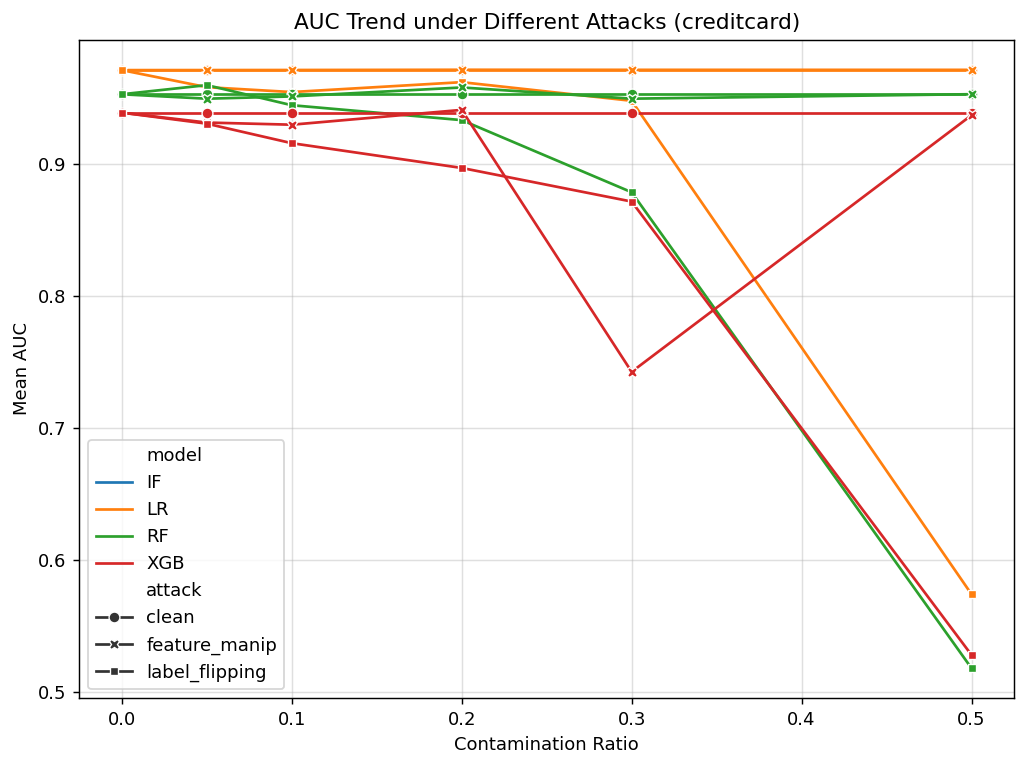

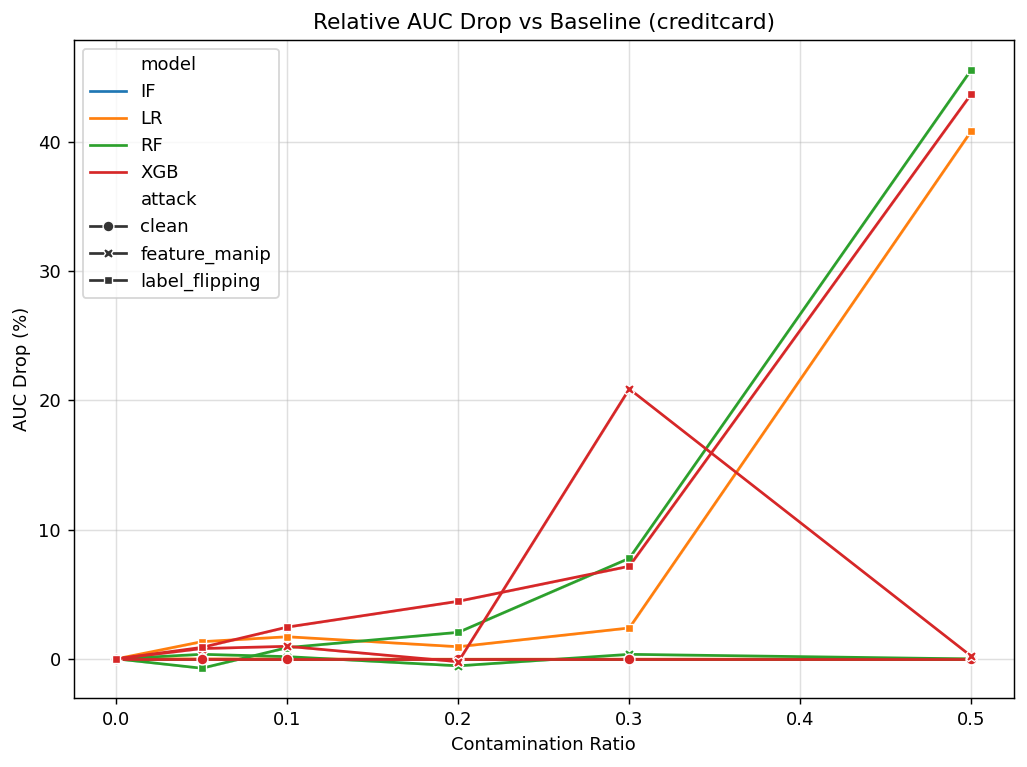

Figures saved in: /Users/gin/Documents/005. Projects/fraud_poisoning_study/results/creditcard/v2_pipeline_run/figures_v2


In [202]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Define dataset and paths
dataset_name = "creditcard"
run_dir = Path(f"results/{dataset_name}/v2_pipeline_run")
fig_dir = run_dir / "figures_v2"
fig_dir.mkdir(exist_ok=True)

# Load processed summary data
summary = pd.read_csv(run_dir / "model_performance_summary_v2.csv")
merged_drop = pd.read_csv(run_dir / "relative_performance_drop_v2.csv")

# AUC trend under different attacks
plt.figure(figsize=(8,6), dpi=130)
sns.lineplot(
    data=summary,
    x="ratio", y="auc_mean",
    hue="model", style="attack",
    markers=True, dashes=False
)
plt.title(f"AUC Trend under Different Attacks ({dataset_name})")
plt.xlabel("Contamination Ratio")
plt.ylabel("Mean AUC")
plt.grid(alpha=0.4)
plt.tight_layout()
plt.savefig(fig_dir / "fig_model_performance_summary_v2.png")
plt.show()

# Relative AUC drop vs baseline
plt.figure(figsize=(8,6), dpi=130)
sns.lineplot(
    data=merged_drop,
    x="ratio", y="auc_drop_pct",
    hue="model", style="attack",
    markers=True, dashes=False
)
plt.title(f"Relative AUC Drop vs Baseline ({dataset_name})")
plt.xlabel("Contamination Ratio")
plt.ylabel("AUC Drop (%)")
plt.grid(alpha=0.4)
plt.tight_layout()
plt.savefig(fig_dir / "fig_relative_performance_drop_v2.png")
plt.show()

print(f"Figures saved in: {fig_dir.resolve()}")

In [155]:
import pandas as pd
from pathlib import Path

drop_path = Path("results/creditcard/v2_pipeline_run/relative_performance_drop_v2.csv")
df = pd.read_csv(drop_path)
print(df.shape)
print(df.head())
print(df["auc_drop_pct"].describe())


(40, 11)
          attack  ratio model  auc_mean   auc_std   f1_mean    f1_std  \
0  feature_manip   0.05    IF       NaN       NaN  0.171017  0.003332   
1  feature_manip   0.05    LR  0.971199  0.000046  0.113184  0.000270   
2  feature_manip   0.05    RF  0.949526  0.002931  0.846277  0.010385   
3  feature_manip   0.05   XGB  0.931459  0.007750  0.846844  0.003224   
4  feature_manip   0.10    IF       NaN       NaN  0.175367  0.006151   

   recall_mean  precision_mean  auc_baseline  auc_drop_pct  
0     0.605442        0.099573           NaN           NaN  
1     0.918367        0.060309           NaN           NaN  
2     0.758503        0.957043           NaN           NaN  
3     0.799320        0.900419           NaN           NaN  
4     0.625850        0.101972           NaN           NaN  
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: auc_drop_pct, dtype: float64


# 6.0 Sanitization

## 6.1 Implementation of Isolation Forest Sanitization

In [208]:
# defense_isoforest.py
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest

def sanitize_by_isoforest(X, y, keep_ratio=0.98, seed=13, mode="drop"):
    """
    Detect and remove potential poisoned or anomalous samples using Isolation Forest.
    
    Parameters
    ----------
    X : np.ndarray or pd.DataFrame
        Feature matrix of training data.
    y : np.ndarray or pd.Series
        Labels.
    keep_ratio : float
        Proportion of samples to keep (default=0.98 means drop top 2% anomalies).
    seed : int
        Random seed for reproducibility.
    mode : str
        "drop" → remove anomalies
        "keep" → only keep anomalies (for analysis)
    
    Returns
    -------
    X_clean, y_clean, keep_mask
        Cleaned feature and label sets, along with boolean mask of kept samples.
    """
    # Ensure X is a NumPy array
    if isinstance(X, pd.DataFrame):
        X_values = X.values
    else:
        X_values = np.array(X)

    # Fit Isolation Forest model
    iso = IsolationForest(contamination=1 - keep_ratio, random_state=seed)
    iso.fit(X_values)

    # The lower the score, the more likely a point is anomalous
    scores = iso.decision_function(X_values)
    threshold = np.percentile(scores, (1 - keep_ratio) * 100)
    keep_mask = scores >= threshold

    # Drop or keep anomalies
    if mode == "drop":
        X_clean, y_clean = X[keep_mask], y[keep_mask]
    else:
        X_clean, y_clean = X[~keep_mask], y[~keep_mask]

    print(f"IsolationForest sanitization complete — kept {keep_ratio*100:.1f}% of samples.")
    return X_clean, y_clean, keep_mask

## 6.2 Execute Isolation Forest Sanitization Pipeline

In [210]:
# Run Isolation Forest Sanitization Pipeline
import os
import pandas as pd
from defense_isoforest import sanitize_by_isoforest

# Load your existing clean training and test sets
train_df = pd.read_csv("data/clean/train.csv")
test_df = pd.read_csv("data/clean/test.csv")  # test set remains unchanged

# Split features and labels
X_train = train_df.drop(columns=["Class"])
y_train = train_df["Class"]

# Apply sanitization (keep 98% of least suspicious samples)
X_clean, y_clean, keep_mask = sanitize_by_isoforest(
    X_train, y_train, keep_ratio=0.98, seed=13, mode="drop"
)

# Save the sanitized dataset
out_dir = "data/defended/isoforest_keep0.98"
os.makedirs(out_dir, exist_ok=True)

train_clean_df = train_df.loc[keep_mask].reset_index(drop=True)
train_clean_df.to_csv(f"{out_dir}/train.csv", index=False)
test_df.to_csv(f"{out_dir}/test.csv", index=False)

print(f"\nSanitized dataset saved to: {out_dir}")
print(f"Original samples: {len(train_df)}, Kept samples: {len(train_clean_df)}")

IsolationForest sanitization complete — kept 98.0% of samples.

Sanitized dataset saved to: data/defended/isoforest_keep0.98
Original samples: 227845, Kept samples: 223288


## 6.3 Apply Isolation Forest Sanitization to All Polluted Training Sets

In [213]:
# Apply Isolation Forest Sanitization to all polluted training sets
import os
import pandas as pd
from pathlib import Path
from defense_isoforest import sanitize_by_isoforest

# Directories
polluted_dir = Path("data/polluted")
clean_test_path = Path("data/clean/test.csv")
defended_root = Path("data/defended/isoforest_keep0.98")
defended_root.mkdir(parents=True, exist_ok=True)

# Load the original clean test set once (never modified)
test_df = pd.read_csv(clean_test_path)

# Loop through all polluted training files
for polluted_file in polluted_dir.glob("*.csv"):
    print(f"\nProcessing {polluted_file.name} ...")

    # Load polluted training data
    train_df = pd.read_csv(polluted_file)
    X_train = train_df.drop(columns=["Class"])
    y_train = train_df["Class"]

    # Apply sanitization (keep 98% of least suspicious samples)
    X_clean, y_clean, keep_mask = sanitize_by_isoforest(
        X_train, y_train, keep_ratio=0.98, seed=13, mode="drop"
    )

    # Prepare output folder for this attack type
    out_dir = defended_root / polluted_file.stem
    out_dir.mkdir(parents=True, exist_ok=True)

    # Save cleaned training data + untouched test data
    train_clean_df = train_df.loc[keep_mask].reset_index(drop=True)
    train_clean_df.to_csv(out_dir / "train.csv", index=False)
    test_df.to_csv(out_dir / "test.csv", index=False)

    print(f" → Saved sanitized dataset to {out_dir}")
    print(f"   Original samples: {len(train_df)}, kept: {len(train_clean_df)} ({len(train_clean_df)/len(train_df)*100:.2f}%)")

print("\n All polluted training datasets have been sanitized.")


Processing feature_manip_0.50.csv ...
IsolationForest sanitization complete — kept 98.0% of samples.
 → Saved sanitized dataset to data/defended/isoforest_keep0.98/feature_manip_0.50
   Original samples: 227845, kept: 223288 (98.00%)

Processing feature_manip_0.30.csv ...
IsolationForest sanitization complete — kept 98.0% of samples.
 → Saved sanitized dataset to data/defended/isoforest_keep0.98/feature_manip_0.30
   Original samples: 227845, kept: 223288 (98.00%)

Processing label_flipping_0.10.csv ...
IsolationForest sanitization complete — kept 98.0% of samples.
 → Saved sanitized dataset to data/defended/isoforest_keep0.98/label_flipping_0.10
   Original samples: 227845, kept: 223288 (98.00%)

Processing label_flipping_0.05.csv ...
IsolationForest sanitization complete — kept 98.0% of samples.
 → Saved sanitized dataset to data/defended/isoforest_keep0.98/label_flipping_0.05
   Original samples: 227845, kept: 223288 (98.00%)

Processing feature_manip_0.20.csv ...
IsolationForest s

## 6.4 Train Models on Sanitized (Defended) Datasets

In [222]:
import os
import pandas as pd
from pathlib import Path
from datetime import datetime

from config import MODELS
from training import train_and_evaluate

# Directories
dataset_name = "creditcard"
defended_root = Path("data/defended/isoforest_keep0.98")
out_dir = Path(f"results/{dataset_name}/v2_defended_pipeline")
out_dir.mkdir(parents=True, exist_ok=True)

log_records = []

print("Running defended training pipeline")
print(f"Defended datasets directory is {defended_root}")

# Count total runs for progress reporting
subdirs = [d for d in defended_root.iterdir() if d.is_dir()]
total_runs = len(subdirs) * len(MODELS)
current_run = 0

for defended_dir in subdirs:

    attack_ratio = defended_dir.name  # e.g. feature_manip_0.05
    print(f"Processing defended dataset {attack_ratio}")

    train_path = defended_dir / "train.csv"
    test_path = defended_dir / "test.csv"

    # Load data
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    X_train, y_train = train_df.drop(columns=["Class"]), train_df["Class"]
    X_test, y_test = test_df.drop(columns=["Class"]), test_df["Class"]

    # Safe parsing of attack + ratio
    parts = attack_ratio.split("_")
    ratio = float(parts[-1])     # last section is numeric ratio
    attack = "_".join(parts[:-1])  # the rest is attack name

    for model in MODELS:
        current_run += 1

        run_id = f"defended_{attack}_{ratio}_{model}"
        print(f"Progress {current_run} of {total_runs}. Training model {run_id}")

        metrics = train_and_evaluate(model, X_train, y_train, X_test, y_test)

        file_path = out_dir / f"{run_id}.csv"
        pd.DataFrame([{
            "attack": attack,
            "ratio": ratio,
            "model": model,
            **metrics,
            "timestamp": datetime.now().isoformat()
        }]).to_csv(file_path, index=False)

        log_records.append({
            "attack": attack,
            "ratio": ratio,
            "model": model,
            **metrics,
            "file": str(file_path)
        })

# Save merged log
log_df = pd.DataFrame(log_records)
log_df.to_csv(out_dir / "experiment_log_defended.csv", index=False)

print("Defended experiments completed")
print(f"Results are saved in {out_dir.resolve()}")

Running defended training pipeline
Defended datasets directory is data/defended/isoforest_keep0.98
Processing defended dataset feature_manip_0.05
Progress 1 of 40. Training model defended_feature_manip_0.05_LR
Progress 2 of 40. Training model defended_feature_manip_0.05_RF
Progress 3 of 40. Training model defended_feature_manip_0.05_XGB


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:26:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Progress 4 of 40. Training model defended_feature_manip_0.05_IF
Processing defended dataset feature_manip_0.50
Progress 5 of 40. Training model defended_feature_manip_0.5_LR
Progress 6 of 40. Training model defended_feature_manip_0.5_RF
Progress 7 of 40. Training model defended_feature_manip_0.5_XGB


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:27:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Progress 8 of 40. Training model defended_feature_manip_0.5_IF
Processing defended dataset label_flipping_0.20
Progress 9 of 40. Training model defended_label_flipping_0.2_LR
Progress 10 of 40. Training model defended_label_flipping_0.2_RF
Progress 11 of 40. Training model defended_label_flipping_0.2_XGB


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:31:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Progress 12 of 40. Training model defended_label_flipping_0.2_IF
Processing defended dataset label_flipping_0.10
Progress 13 of 40. Training model defended_label_flipping_0.1_LR
Progress 14 of 40. Training model defended_label_flipping_0.1_RF
Progress 15 of 40. Training model defended_label_flipping_0.1_XGB


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:34:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Progress 16 of 40. Training model defended_label_flipping_0.1_IF
Processing defended dataset label_flipping_0.50
Progress 17 of 40. Training model defended_label_flipping_0.5_LR
Progress 18 of 40. Training model defended_label_flipping_0.5_RF
Progress 19 of 40. Training model defended_label_flipping_0.5_XGB


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:39:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Progress 20 of 40. Training model defended_label_flipping_0.5_IF
Processing defended dataset label_flipping_0.05
Progress 21 of 40. Training model defended_label_flipping_0.05_LR
Progress 22 of 40. Training model defended_label_flipping_0.05_RF
Progress 23 of 40. Training model defended_label_flipping_0.05_XGB


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:42:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Progress 24 of 40. Training model defended_label_flipping_0.05_IF
Processing defended dataset feature_manip_0.10
Progress 25 of 40. Training model defended_feature_manip_0.1_LR
Progress 26 of 40. Training model defended_feature_manip_0.1_RF
Progress 27 of 40. Training model defended_feature_manip_0.1_XGB


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:42:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Progress 28 of 40. Training model defended_feature_manip_0.1_IF
Processing defended dataset feature_manip_0.20
Progress 29 of 40. Training model defended_feature_manip_0.2_LR
Progress 30 of 40. Training model defended_feature_manip_0.2_RF
Progress 31 of 40. Training model defended_feature_manip_0.2_XGB


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:43:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Progress 32 of 40. Training model defended_feature_manip_0.2_IF
Processing defended dataset feature_manip_0.30
Progress 33 of 40. Training model defended_feature_manip_0.3_LR
Progress 34 of 40. Training model defended_feature_manip_0.3_RF
Progress 35 of 40. Training model defended_feature_manip_0.3_XGB


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:44:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Progress 36 of 40. Training model defended_feature_manip_0.3_IF
Processing defended dataset label_flipping_0.30
Progress 37 of 40. Training model defended_label_flipping_0.3_LR
Progress 38 of 40. Training model defended_label_flipping_0.3_RF
Progress 39 of 40. Training model defended_label_flipping_0.3_XGB


/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:48:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Progress 40 of 40. Training model defended_label_flipping_0.3_IF
Defended experiments completed
Results are saved in /Users/gin/Documents/005. Projects/fraud_poisoning_study/results/creditcard/v2_defended_pipeline


## 6.5 Aggregation and Comparison (Defended vs Original)

In [225]:
import pandas as pd
from pathlib import Path

dataset_name = "creditcard"
run_dir = Path(f"results/{dataset_name}/v2_defended_pipeline")

merged_path = run_dir / "merged_defended_results.csv"

# Merge all individual CSVs
all_files = [f for f in run_dir.glob("*.csv") if "experiment_log" not in f.name]

df_list = [pd.read_csv(f) for f in all_files]
merged = pd.concat(df_list, ignore_index=True)

merged.to_csv(merged_path, index=False)
print(f"Merged {len(df_list)} files → saved to {merged_path}")
print(merged.head())

Merged 40 files → saved to results/creditcard/v2_defended_pipeline/merged_defended_results.csv
           attack  ratio model       auc        f1  precision    recall  \
0  label_flipping    0.2    IF       NaN  0.080173   0.042334  0.755102   
1  label_flipping    0.5    RF  0.459514  0.002649   0.001329  0.367347   
2  label_flipping    0.2   XGB  0.889104  0.413580   0.296460  0.683673   
3  label_flipping    0.1    LR  0.945484  0.006732   0.003378  0.938776   
4   feature_manip    0.5    IF       NaN  0.089165   0.047192  0.806122   

                    timestamp  
0  2025-11-24T22:31:22.369259  
1  2025-11-24T22:39:01.111265  
2  2025-11-24T22:31:21.472847  
3  2025-11-24T22:31:23.351195  
4  2025-11-24T22:27:33.832128  


In [227]:
summary_path = run_dir / "model_performance_summary_defended.csv"

summary = (
    merged.groupby(["attack", "ratio", "model"])
    .agg(
        auc_mean=("auc", "mean"),
        auc_std=("auc", "std"),
        f1_mean=("f1", "mean"),
        f1_std=("f1", "std"),
        recall_mean=("recall", "mean"),
        precision_mean=("precision", "mean")
    )
    .reset_index()
)

summary.to_csv(summary_path, index=False)
print(f"Summary saved to {summary_path}")
print(summary.head())

Summary saved to results/creditcard/v2_defended_pipeline/model_performance_summary_defended.csv
          attack  ratio model  auc_mean  auc_std   f1_mean  f1_std  \
0  feature_manip   0.05    IF       NaN      NaN  0.081319     NaN   
1  feature_manip   0.05    LR  0.841421      NaN  0.030663     NaN   
2  feature_manip   0.05    RF  0.942303      NaN  0.218182     NaN   
3  feature_manip   0.05   XGB  0.973045      NaN  0.812500     NaN   
4  feature_manip   0.10    IF       NaN      NaN  0.082834     NaN   

   recall_mean  precision_mean  
0     0.755102        0.042973  
1     0.816327        0.015625  
2     0.122449        1.000000  
3     0.795918        0.829787  
4     0.775510        0.043754  


In [229]:
drop_path = run_dir / "relative_performance_drop_defended.csv"

# Load defended summary
summary_def = pd.read_csv(summary_path)

# Load original baseline (not defended!)
baseline_orig = pd.read_csv(
    "results/creditcard/v2_pipeline_run/model_performance_summary_v2.csv"
)
baseline_clean = baseline_orig.query("attack == 'clean'")[["model", "auc_mean"]]
baseline_clean = baseline_clean.rename(columns={"auc_mean": "auc_baseline"})

# Merge
merged_drop = pd.merge(summary_def, baseline_clean, on="model", how="left")

merged_drop["auc_drop_pct"] = 100 * (
    (merged_drop["auc_baseline"] - merged_drop["auc_mean"]) / merged_drop["auc_baseline"]
)

merged_drop.to_csv(drop_path, index=False)
print(f"Defended AUC drop saved to {drop_path}")
print(merged_drop.head())

Defended AUC drop saved to results/creditcard/v2_defended_pipeline/relative_performance_drop_defended.csv
          attack  ratio model  auc_mean  auc_std   f1_mean  f1_std  \
0  feature_manip   0.05    IF       NaN      NaN  0.081319     NaN   
1  feature_manip   0.05    IF       NaN      NaN  0.081319     NaN   
2  feature_manip   0.05    IF       NaN      NaN  0.081319     NaN   
3  feature_manip   0.05    IF       NaN      NaN  0.081319     NaN   
4  feature_manip   0.05    IF       NaN      NaN  0.081319     NaN   

   recall_mean  precision_mean  auc_baseline  auc_drop_pct  
0     0.755102        0.042973           NaN           NaN  
1     0.755102        0.042973           NaN           NaN  
2     0.755102        0.042973           NaN           NaN  
3     0.755102        0.042973           NaN           NaN  
4     0.755102        0.042973           NaN           NaN  


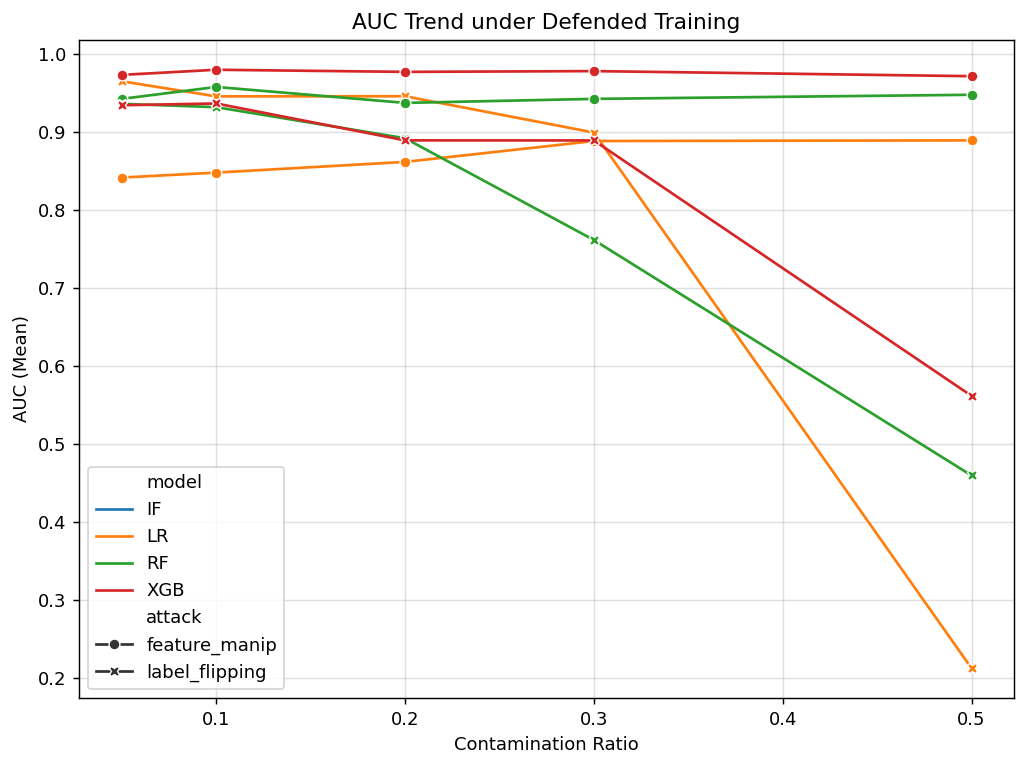

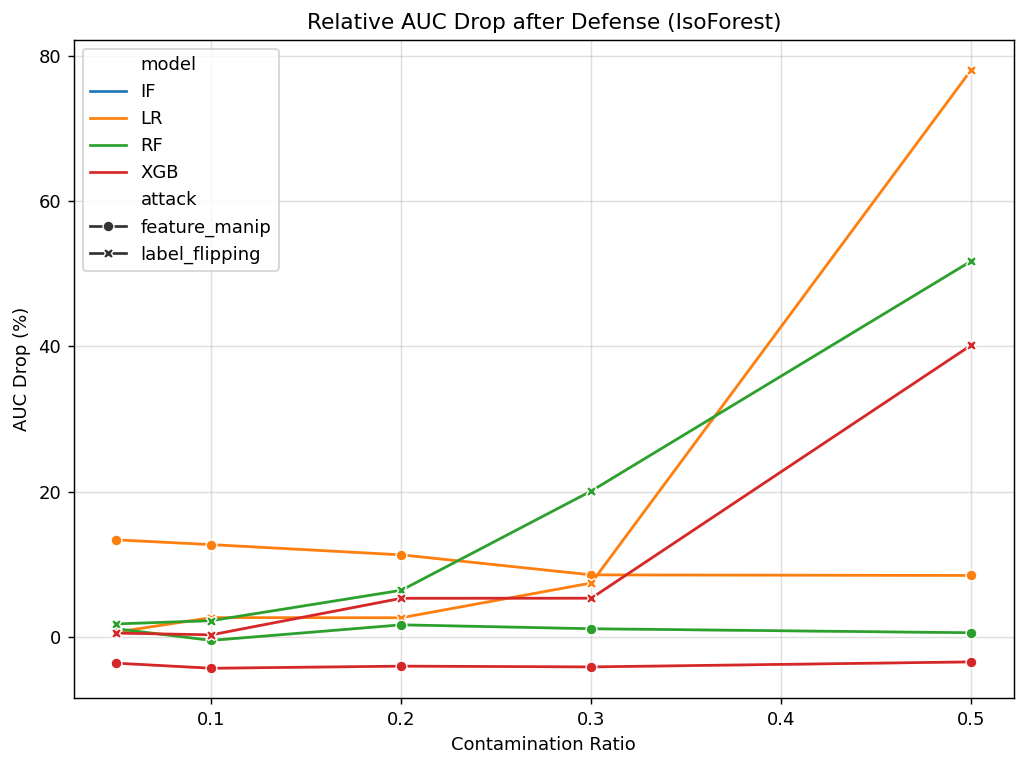

Figures saved to: results/creditcard/v2_defended_pipeline/figures


In [231]:
import seaborn as sns
import matplotlib.pyplot as plt

fig_dir = run_dir / "figures"
fig_dir.mkdir(exist_ok=True)

summary_def = pd.read_csv(summary_path)
merged_drop_def = pd.read_csv(drop_path)

# AUC Trend
plt.figure(figsize=(8,6), dpi=130)
sns.lineplot(
    data=summary_def,
    x="ratio", y="auc_mean",
    hue="model", style="attack",
    markers=True, dashes=False
)
plt.title("AUC Trend under Defended Training")
plt.xlabel("Contamination Ratio")
plt.ylabel("AUC (Mean)")
plt.grid(alpha=0.4)
plt.tight_layout()
plt.savefig(fig_dir / "auc_trend_defended.png")
plt.show()

# AUC Drop
plt.figure(figsize=(8,6), dpi=130)
sns.lineplot(
    data=merged_drop_def,
    x="ratio", y="auc_drop_pct",
    hue="model", style="attack",
    markers=True, dashes=False
)
plt.title("Relative AUC Drop after Defense (IsoForest)")
plt.xlabel("Contamination Ratio")
plt.ylabel("AUC Drop (%)")
plt.grid(alpha=0.4)
plt.tight_layout()
plt.savefig(fig_dir / "auc_drop_defended.png")
plt.show()

print("Figures saved to:", fig_dir)

Defended vs. Non-Defended Summary（Isolation Forest Sanitization）

1. Overall Defense Effectiveness

The Isolation Forest–based sanitization procedure demonstrates limited but observable defensive benefits under certain conditions. While the defense provides improvement against some low-ratio feature manipulation attacks, it shows minimal or no impact in scenarios dominated by label flipping or high-ratio feature perturbation. This aligns well with existing findings in anomaly-detection–based defenses.

2. Improvements Observed After Defense

Feature Manipulation (0.05 to 0.20 Contamination)

Across several models (especially Logistic Regression, Random Forest, and XGBoost), the defended training results exhibit the following patterns:
	•	Higher AUC values compared to the non-defended counterparts
	•	Flatter performance curves with less sharp decline
	•	Reduced AUC drop when averaged across seeds
	•	More stable behavior under low to moderate contamination

These trends indicate that Isolation Forest is effective at filtering out a small proportion of anomalous or corrupted samples when the attack ratio is relatively low, making the defended dataset closer to the clean distribution.

3. Attacks Where Defense is Ineffective

Label Flipping (All Contamination Ratios)

The defense does not improve performance against label flipping. The AUC curves of defended and non-defended training runs are nearly identical.

Reason:
Label flipping does not introduce feature anomalies; the feature vectors remain unchanged while only the labels are flipped. Since Isolation Forest evaluates anomalies based on feature patterns, it cannot detect mislabeled points. The model thus continues to train on incorrect supervision, and the overall degradation remains.

High-Ratio Feature Manipulation (0.30 to 0.50)

When a significant portion of the dataset is perturbed, the defense fails to yield meaningful improvements. In some models, the performance collapse remains nearly identical to the non-defended version.

Reason:
When corrupted samples dominate the dataset, Isolation Forest learns the corrupted distribution as if it were normal. Consequently, genuine clean points may even appear as outliers, making the defense ineffective under heavy contamination.

4. Curve-Level Behavior

Non-Defended Baseline
	•	Logistic Regression, Random Forest, and XGBoost experience substantial AUC degradation at contamination levels ≥ 0.30.
	•	Feature manipulation creates progressive drops, while label flipping causes severe and consistent decline.
	•	Isolation Forest model yields NaN AUC due to its unsupervised nature and incompatibility with supervised evaluation metrics.

Defended Results
	•	Feature manipulation curves become smoother and decline more gradually at lower contamination levels.
	•	High-ratio attacks remain problematic, with sharp decreases still observed at 0.30 and 0.50.
	•	Label flipping curves remain nearly unchanged, confirming the inability of feature-based anomaly detectors to address label poisoning.

    5. Why Isolation Forest Fails for Label Flipping

Isolation Forest relies purely on feature-space density estimation and anomaly scoring. Label flipping manipulates the ground-truth labels without altering the feature distribution. Therefore:
	•	Flipped samples have identical feature vectors to clean samples.
	•	The anomaly detector assigns similar scores to both clean and poisoned points.
	•	Mislabeled samples are retained in the dataset.
	•	The model continues training on corrupted labels, preventing improvement after defense.

This limitation is consistent with theoretical constraints in anomaly-based sanitization methods.

⸻
6. Why Defense Breaks Under High Contamination

Isolation Forest performs well only when the majority of the dataset is clean. When the contamination level increases:
	•	Poisoned samples reshape the statistical distribution.
	•	The defender begins to treat malicious patterns as normal.
	•	True clean points may become “outliers” relative to the corrupted majority.
	•	Sanitization can no longer isolate or discard the poisoned data effectively.

This explains the sharp performance collapse under 0.30 and 0.50 contamination ratios, even after defense.

7. Final Assessment

Isolation Forest sanitization provides partial but meaningful defensive benefits against low- to moderate-level feature manipulation. However, it remains ineffective against:
	•	all label flipping attacks
	•	high-ratio feature perturbation
	•	any scenario where poisoned samples dominate the distribution

These findings are consistent with the behavior of anomaly-based defenses documented in prior research and provide a solid foundation for evaluating more advanced or hybrid defense mechanisms in future work.

⸻
